# Getting Started

This notebook is for running visualizing the analysis results from the `significance_analysis.ipynb` notebook. Be sure to run the `significance_analysis.ipynb` BEFORE running this notebook as it generates files that are required to be loaded here. 

This notebook focuses on plotting forest plots and bar plots. The bar plots are the focus as the forest plots code is more ridged.

In [45]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import os
import glob
import pickle
from functools import partial
from pathlib import Path
from copy import deepcopy

import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statannot import add_stat_annotation
from zepid.graphics import EffectMeasurePlot
from IPython.core.debugger import set_trace
pd.set_option('display.max_rows', 200)

import directory_structure as ds
from analysis_utils import DataFrameIndexWrapper

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Downloading pickle files, CSVs, and Plots

If you did not run the `significance_analysis.ipynb` notebook, optionally, you can download pre-generated pickle files and the corresponding CSVs and Plots this notebook generates by running the below code. Do so my setting `download = True` in the below code cell.

As in the `significance_analysis.ipynb` notebook, there will are two experiment statistical results you can download, given as follows.

- The paper results which correspond to the `v2-analysis-ErrP-variations-March-3-2022.tar.xz` file.

- Replication results which correspond to the `v2-analysis-replication.tar.xz.tar.xz` file.

In [63]:
download = True
if download:
    from analysis_utils import DownloadResults
    result_info = dict(           
        paper_results=dict(
            file="v2-analysis-ErrP-variations-March-3-2022.tar.xz",
            directory='v2-ErrP-variations-March-3-2022',
            url="https://drive.google.com/uc?export=download&id=1CFKI6Yyc3X_7l4rASvD1AcJgPUKEnHoI",
        ),
        replication=dict(
            file="v2-analysis-replication.tar.xz",
            directory="v2-replication",
            url="https://drive.google.com/uc?export=download&id=1LcDOnzln4BFzB7RvLZMvEA-wG7p9GdFk",
        )
    )
    save_dir = Path(ds.ROOT_DIR) / ds.ANALYSIS_DIR
    download_results = DownloadResults(result_info, save_dir)
    download_results()

Extracting v2-analysis-ErrP-variations-March-3-2022.tar.xz...
Extracting v2-analysis-replication.tar.xz...
Done


# Pickle Loading and Stats Summaries

To load the pickle files generated by the `significance_analysis.ipynb` notebook, set the `current_analysis` to the name of the directory within the `../scripts/classification/analysis` directory. If you don't see any `../analysis` directory within the `../scripts/classification` directory, then you might not have successfully ran the `significance_analysis.ipynb` notebook. Optionally, you can use the above code to automatically download the analysis directory used in paper and the additional replication analysis directory (these will also include the pre-generated CSVs and plots).

Note: This code will load the pickle files directly into the global vars.

In [47]:
current_analysis = 'v2-ErrP-variations-March-3-2022'

# Example of pointing to different directory for analysis. 
# Here we point to the v2-replication results
# current_analysis = 'v2-replication'

In [48]:
pickles_path = os.path.join(ds.ROOT_DIR, 'analysis', current_analysis, 'pickles')

def pickle_load(file): 
    with open(file, 'rb') as f:
        return pickle.load(f)
    
for file in os.listdir(pickles_path):
    if file.endswith(".pkl"):
        var = file.split('.')[0]
        abs_file_path = os.path.join(pickles_path, file)
        print(f"Adding '{var}' to globals...")
        globals()[var] = pickle_load(abs_file_path)

Adding 'baseline_analysis' to globals...
Adding 'baseline_multi_analysis' to globals...
Adding 'exps' to globals...
Adding 'same_target_analysis' to globals...
Adding 'within_task_analysis' to globals...
Adding 'same_source_analysis' to globals...
Adding 'within_category_analysis' to globals...


In [49]:
exps

{'eegnet': DataFrameIndexWrapper(shape=(11160, 9),
 'svm': DataFrameIndexWrapper(shape=(11160, 6)}

In [50]:
def stat_summary(df, p_col):
    """ Quickly gathers and displays means, effect sizes/CIs, and p-values """
    p_value_col = 'p.adj'
    summarize = df.swaplevel(0, 1)
    summarize = summarize.drop('PPV', level=0, axis=0)
    summarize = summarize.sort_values(['score', 'group1', 'group2'])
    summarize = summarize.loc[:, [p_col, 'group1', 'group2', 'mean1', 'mean2', 'Hedges_g', 'CI_low', 'CI_high']]
    return summarize

## Baselines

In [51]:
baseline_analysis

group1         group2  mean1  mean2   std1   std2   diff  \
exps   score                                                                    
eegnet PPV    BGSInt-BGSInt  BGSObs-BGSObs  0.056  0.044  0.033  0.024  0.013   
       PPV      OAObs-OAObs    OAOut-OAOut  0.031  0.094  0.025  0.061 -0.064   
       TNR    BGSInt-BGSInt  BGSObs-BGSObs  0.842  0.785  0.073  0.088  0.057   
       TNR      OAObs-OAObs    OAOut-OAOut  0.859  0.934  0.081  0.042 -0.075   
       TPR    BGSInt-BGSInt  BGSObs-BGSObs  0.717  0.632  0.191  0.161  0.085   
       TPR      OAObs-OAObs    OAOut-OAOut  0.541  0.801  0.215  0.167 -0.260   
       bACC   BGSInt-BGSInt  BGSObs-BGSObs  0.780  0.709  0.098  0.084  0.071   
       bACC     OAObs-OAObs    OAOut-OAOut  0.700  0.867  0.099  0.084 -0.167   
svm    PPV    BGSInt-BGSInt  BGSObs-BGSObs  0.034  0.028  0.019  0.012  0.007   
       PPV      OAObs-OAObs    OAOut-OAOut  0.015  0.067  0.007  0.046 -0.052   
       TNR    BGSInt-BGSInt  BGSObs-BGSObs  0.786  0.716  0.063  0.056  0.069   
       TNR      OAObs-OAObs    OAOut-OAOut  0.788  0.925  0.067  0.040 -0.137   
       TPR    BGSInt-BGSInt  BGSObs-BGSObs  0.623  0.585  0.166  0.164  0.038   
       TPR      OAObs-OAObs    OAOut-OAOut  0.495  0.671  0.175  0.210 -0.175   
       bACC   BGSInt-BGSInt  BGSObs-BGSObs  0.705  0.651  0.097  0.093  0.054   
       bACC     OAObs-OAObs    OAOut-OAOut  0.642  0.798  0.083  0.103 -0.156   

              conf.low  conf.high  n1  n2       df      p  Hedges_g    CI  \
exps   score                                                                
eegnet PPV       0.004      0.021  90  90  161.427  0.004     0.433  0.95   
       PPV      -0.077     -0.050  90  90  118.031  0.000    -1.347  0.95   
       TNR       0.033      0.081  90  90  171.537  0.000     0.700  0.95   
       TNR      -0.094     -0.056  90  90  133.123  0.000    -1.155  0.95   
       TPR       0.033      0.137  90  90  172.931  0.001     0.479  0.95   
       TPR      -0.317     -0.203  90  90  167.727  0.000    -1.346  0.95   
       bACC      0.044      0.098  90  90  174.031  0.000     0.774  0.95   
       bACC     -0.194     -0.140  90  90  173.206  0.000    -1.818  0.95   
svm    PPV       0.002      0.011  90  90  149.633  0.005     0.420  0.95   
       PPV      -0.062     -0.042  90  90   93.708  0.000    -1.567  0.95   
       TNR       0.052      0.087  90  90  175.753  0.000     1.148  0.95   
       TNR      -0.153     -0.121  90  90  145.581  0.000    -2.478  0.95   
       TPR      -0.010      0.087  90  90  177.973  0.120     0.232  0.95   
       TPR      -0.232     -0.118  90  90  172.249  0.000    -0.903  0.95   
       bACC      0.026      0.082  90  90  177.612  0.000     0.563  0.95   
       bACC     -0.184     -0.129  90  90  170.213  0.000    -1.664  0.95   

              CI_low  CI_high  
exps   score                   
eegnet PPV     0.138    0.727  
       PPV    -1.682   -1.008  
       TNR     0.398    0.999  
       TNR    -1.476   -0.832  
       TPR     0.183    0.774  
       TPR    -1.669   -1.020  
       bACC    0.471    1.075  
       bACC   -2.164   -1.468  
svm    PPV     0.124    0.714  
       PPV    -1.931   -1.198  
       TNR     0.832    1.462  
       TNR    -2.882   -2.069  
       TPR    -0.060    0.524  
       TPR    -1.208   -0.595  
       bACC    0.265    0.859  
       bACC   -2.003   -1.322

In [52]:
stat_summary(baseline_analysis, p_col='p')

p         group1         group2  mean1  mean2  Hedges_g  \
score exps                                                                  
TNR   eegnet  0.000  BGSInt-BGSInt  BGSObs-BGSObs  0.842  0.785     0.700   
      svm     0.000  BGSInt-BGSInt  BGSObs-BGSObs  0.786  0.716     1.148   
      eegnet  0.000    OAObs-OAObs    OAOut-OAOut  0.859  0.934    -1.155   
      svm     0.000    OAObs-OAObs    OAOut-OAOut  0.788  0.925    -2.478   
TPR   eegnet  0.001  BGSInt-BGSInt  BGSObs-BGSObs  0.717  0.632     0.479   
      svm     0.120  BGSInt-BGSInt  BGSObs-BGSObs  0.623  0.585     0.232   
      eegnet  0.000    OAObs-OAObs    OAOut-OAOut  0.541  0.801    -1.346   
      svm     0.000    OAObs-OAObs    OAOut-OAOut  0.495  0.671    -0.903   
bACC  eegnet  0.000  BGSInt-BGSInt  BGSObs-BGSObs  0.780  0.709     0.774   
      svm     0.000  BGSInt-BGSInt  BGSObs-BGSObs  0.705  0.651     0.563   
      eegnet  0.000    OAObs-OAObs    OAOut-OAOut  0.700  0.867    -1.818   
      svm     0.000    OAObs-OAObs    OAOut-OAOut  0.642  0.798    -1.664   

              CI_low  CI_high  
score exps                     
TNR   eegnet   0.398    0.999  
      svm      0.832    1.462  
      eegnet  -1.476   -0.832  
      svm     -2.882   -2.069  
TPR   eegnet   0.183    0.774  
      svm     -0.060    0.524  
      eegnet  -1.669   -1.020  
      svm     -1.208   -0.595  
bACC  eegnet   0.471    1.075  
      svm      0.265    0.859  
      eegnet  -2.164   -1.468  
      svm     -2.003   -1.322

In [53]:
baseline_multi_analysis

p.adj.signif  p.adj         group1         group2  mean1  mean2  \
exps   score                                                                   
eegnet PPV              *  0.021  BGSInt-BGSInt  BGSObs-BGSObs  0.056  0.044   
       PPV           ****  0.000  BGSInt-BGSInt    OAObs-OAObs  0.056  0.031   
       PPV           ****  0.000  BGSInt-BGSInt    OAOut-OAOut  0.056  0.094   
       PPV             **  0.002  BGSObs-BGSObs    OAObs-OAObs  0.044  0.031   
       PPV           ****  0.000  BGSObs-BGSObs    OAOut-OAOut  0.044  0.094   
       PPV           ****  0.000    OAObs-OAObs    OAOut-OAOut  0.031  0.094   
       TNR           ****  0.000  BGSInt-BGSInt  BGSObs-BGSObs  0.842  0.785   
       TNR             ns  0.452  BGSInt-BGSInt    OAObs-OAObs  0.842  0.859   
       TNR           ****  0.000  BGSInt-BGSInt    OAOut-OAOut  0.842  0.934   
       TNR           ****  0.000  BGSObs-BGSObs    OAObs-OAObs  0.785  0.859   
       TNR           ****  0.000  BGSObs-BGSObs    OAOut-OAOut  0.785  0.934   
       TNR           ****  0.000    OAObs-OAObs    OAOut-OAOut  0.859  0.934   
       TPR             **  0.008  BGSInt-BGSInt  BGSObs-BGSObs  0.717  0.632   
       TPR           ****  0.000  BGSInt-BGSInt    OAObs-OAObs  0.717  0.541   
       TPR              *  0.011  BGSInt-BGSInt    OAOut-OAOut  0.717  0.801   
       TPR             **  0.008  BGSObs-BGSObs    OAObs-OAObs  0.632  0.541   
       TPR           ****  0.000  BGSObs-BGSObs    OAOut-OAOut  0.632  0.801   
       TPR           ****  0.000    OAObs-OAObs    OAOut-OAOut  0.541  0.801   
       bACC          ****  0.000  BGSInt-BGSInt  BGSObs-BGSObs  0.780  0.709   
       bACC          ****  0.000  BGSInt-BGSInt    OAObs-OAObs  0.780  0.700   
       bACC          ****  0.000  BGSInt-BGSInt    OAOut-OAOut  0.780  0.867   
       bACC            ns  0.921  BGSObs-BGSObs    OAObs-OAObs  0.709  0.700   
       bACC          ****  0.000  BGSObs-BGSObs    OAOut-OAOut  0.709  0.867   
       bACC          ****  0.000    OAObs-OAObs    OAOut-OAOut  0.700  0.867   
svm    PPV              *  0.027  BGSInt-BGSInt  BGSObs-BGSObs  0.034  0.028   
       PPV           ****  0.000  BGSInt-BGSInt    OAObs-OAObs  0.034  0.015   
       PPV           ****  0.000  BGSInt-BGSInt    OAOut-OAOut  0.034  0.067   
       PPV           ****  0.000  BGSObs-BGSObs    OAObs-OAObs  0.028  0.015   
       PPV           ****  0.000  BGSObs-BGSObs    OAOut-OAOut  0.028  0.067   
       PPV           ****  0.000    OAObs-OAObs    OAOut-OAOut  0.015  0.067   
       TNR           ****  0.000  BGSInt-BGSInt  BGSObs-BGSObs  0.786  0.716   
       TNR             ns  0.995  BGSInt-BGSInt    OAObs-OAObs  0.786  0.788   
       TNR           ****  0.000  BGSInt-BGSInt    OAOut-OAOut  0.786  0.925   
       TNR           ****  0.000  BGSObs-BGSObs    OAObs-OAObs  0.716  0.788   
       TNR           ****  0.000  BGSObs-BGSObs    OAOut-OAOut  0.716  0.925   
       TNR           ****  0.000    OAObs-OAObs    OAOut-OAOut  0.788  0.925   
       TPR             ns  0.402  BGSInt-BGSInt  BGSObs-BGSObs  0.623  0.585   
       TPR           ****  0.000  BGSInt-BGSInt    OAObs-OAObs  0.623  0.495   
       TPR             ns  0.345  BGSInt-BGSInt    OAOut-OAOut  0.623  0.671   
       TPR             **  0.003  BGSObs-BGSObs    OAObs-OAObs  0.585  0.495   
       TPR              *  0.014  BGSObs-BGSObs    OAOut-OAOut  0.585  0.671   
       TPR           ****  0.000    OAObs-OAObs    OAOut-OAOut  0.495  0.671   
       bACC           ***  0.001  BGSInt-BGSInt  BGSObs-BGSObs  0.705  0.651   
       bACC          ****  0.000  BGSInt-BGSInt    OAObs-OAObs  0.705  0.642   
       bACC          ****  0.000  BGSInt-BGSInt    OAOut-OAOut  0.705  0.798   
       bACC            ns  0.899  BGSObs-BGSObs    OAObs-OAObs  0.651  0.642   
       bACC          ****  0.000  BGSObs-BGSObs    OAOut-OAOut  0.651  0.798   
       bACC          ****  0.000    OAObs-OAObs    OAOut-OAOut  0.642  0.798   

            

Indexing example

In [54]:
stat_summary(baseline_multi_analysis, p_col='p.adj')

p.adj         group1         group2  mean1  mean2  Hedges_g  \
score exps                                                                  
TNR   eegnet  0.000  BGSInt-BGSInt  BGSObs-BGSObs  0.842  0.785     0.700   
      svm     0.000  BGSInt-BGSInt  BGSObs-BGSObs  0.786  0.716     1.148   
      eegnet  0.452  BGSInt-BGSInt    OAObs-OAObs  0.842  0.859    -0.220   
      svm     0.995  BGSInt-BGSInt    OAObs-OAObs  0.786  0.788    -0.036   
      eegnet  0.000  BGSInt-BGSInt    OAOut-OAOut  0.842  0.934    -1.542   
      svm     0.000  BGSInt-BGSInt    OAOut-OAOut  0.786  0.925    -2.621   
      eegnet  0.000  BGSObs-BGSObs    OAObs-OAObs  0.785  0.859    -0.867   
      svm     0.000  BGSObs-BGSObs    OAObs-OAObs  0.716  0.788    -1.151   
      eegnet  0.000  BGSObs-BGSObs    OAOut-OAOut  0.785  0.934    -2.138   
      svm     0.000  BGSObs-BGSObs    OAOut-OAOut  0.716  0.925    -4.242   
      eegnet  0.000    OAObs-OAObs    OAOut-OAOut  0.859  0.934    -1.155   
      svm     0.000    OAObs-OAObs    OAOut-OAOut  0.788  0.925    -2.478   
TPR   eegnet  0.008  BGSInt-BGSInt  BGSObs-BGSObs  0.717  0.632     0.479   
      svm     0.402  BGSInt-BGSInt  BGSObs-BGSObs  0.623  0.585     0.232   
      eegnet  0.000  BGSInt-BGSInt    OAObs-OAObs  0.717  0.541     0.863   
      svm     0.000  BGSInt-BGSInt    OAObs-OAObs  0.623  0.495     0.749   
      eegnet  0.011  BGSInt-BGSInt    OAOut-OAOut  0.717  0.801    -0.465   
      svm     0.345  BGSInt-BGSInt    OAOut-OAOut  0.623  0.671    -0.247   
      eegnet  0.008  BGSObs-BGSObs    OAObs-OAObs  0.632  0.541     0.479   
      svm     0.003  BGSObs-BGSObs    OAObs-OAObs  0.585  0.495     0.527   
      eegnet  0.000  BGSObs-BGSObs    OAOut-OAOut  0.632  0.801    -1.026   
      svm     0.014  BGSObs-BGSObs    OAOut-OAOut  0.585  0.671    -0.452   
      eegnet  0.000    OAObs-OAObs    OAOut-OAOut  0.541  0.801    -1.346   
      svm     0.000    OAObs-OAObs    OAOut-OAOut  0.495  0.671    -0.903   
bACC  eegnet  0.000  BGSInt-BGSInt  BGSObs-BGSObs  0.780  0.709     0.774   
      svm     0.001  BGSInt-BGSInt  BGSObs-BGSObs  0.705  0.651     0.563   
      eegnet  0.000  BGSInt-BGSInt    OAObs-OAObs  0.780  0.700     0.805   
      svm     0.000  BGSInt-BGSInt    OAObs-OAObs  0.705  0.642     0.693   
      eegnet  0.000  BGSInt-BGSInt    OAOut-OAOut  0.780  0.867    -0.961   
      svm     0.000  BGSInt-BGSInt    OAOut-OAOut  0.705  0.798    -0.926   
      eegnet  0.921  BGSObs-BGSObs    OAObs-OAObs  0.709  0.700     0.094   
      svm     0.899  BGSObs-BGSObs    OAObs-OAObs  0.651  0.642     0.103   
      eegnet  0.000  BGSObs-BGSObs    OAOut-OAOut  0.709  0.867    -1.885   
      svm     0.000  BGSObs-BGSObs    OAOut-OAOut  0.651  0.798    -1.493   
      eegnet  0.000    OAObs-OAObs    OAOut-OAOut  0.700  0.867    -1.818   
      svm     0.000    OAObs-OAObs    OAOut-OAOut  0.642  0.798    -1.664   

              CI_low  CI_high  
score exps                     
TNR   eegnet   0.398    0.999  
      svm      0.832    1.462  
      eegnet  -0.511    0.072  
      svm     -0.327    0.255  
      eegnet  -1.882   -1.199  
      svm     -3.034   -2.204  
      eegnet  -1.170   -0.561  
      svm     -1.465   -0.835  
      eegnet  -2.528   -1.744  
      svm     -4.788   -3.693  
      eegnet  -1.476   -0.832  
      svm     -2.882   -2.069  
TPR   eegnet   0.183    0.774  
      svm     -0.060    0.524  
      eegnet   0.558    1.167  
      svm      0.447    1.049  
      eegnet  -0.760   -0.170  
      svm     -0.539    0.045  
      eegnet   0.183    0.774  
      svm      0.230    0.822  
      eegnet  -1.335   -0.715  
      svm     -0.746   -0.156  
      eegnet  -1.669   -1.020  
      svm     -1.208   -0.595  
bACC  eegnet   0.471    1.075  
      svm      0.265    0.859  
      eegnet   0.502    1.107  
      svm      0.392    0.992  
      eegnet  -1.267   -0.652  
      svm     -1.231   -0.619  
      eegnet  -0.197    0.385  
      svm     -0.188    0.394  

## Same Target (i.e., Same Test)

In [55]:
same_target_analysis

p.adj.signif  p.adj         group1         group2  mean1  \
exps   score target                                                            
eegnet PPV   BGSInt         ****  0.000  BGSInt-BGSInt  BGSObs-BGSInt  0.056   
             BGSInt         ****  0.000  BGSInt-BGSInt   OAObs-BGSInt  0.056   
             BGSInt           ns  0.060  BGSInt-BGSInt   OAOut-BGSInt  0.056   
             BGSInt           ns  0.299  BGSObs-BGSInt   OAObs-BGSInt  0.034   
             BGSInt         ****  0.000  BGSObs-BGSInt   OAOut-BGSInt  0.034   
             BGSInt         ****  0.000   OAObs-BGSInt   OAOut-BGSInt  0.036   
             BGSObs           ns  0.389  BGSObs-BGSObs   OAOut-BGSObs  0.044   
             BGSObs            *  0.011  BGSObs-BGSObs   OAObs-BGSObs  0.044   
             BGSObs           ns  0.075   OAObs-BGSObs   OAOut-BGSObs  0.035   
             BGSObs         ****  0.000  BGSInt-BGSObs   OAObs-BGSObs  0.051   
             BGSObs            *  0.050  BGSInt-BGSObs  BGSObs-BGSObs  0.051   
             BGSObs         ****  0.000  BGSInt-BGSObs   OAOut-BGSObs  0.051   
             OAObs          ****  0.000   BGSObs-OAObs    OAOut-OAObs  0.013   
             OAObs          ****  0.000   BGSInt-OAObs   BGSObs-OAObs  0.017   
             OAObs          ****  0.000   BGSInt-OAObs    OAObs-OAObs  0.017   
             OAObs          ****  0.000   BGSInt-OAObs    OAOut-OAObs  0.017   
             OAObs          ****  0.000   BGSObs-OAObs    OAObs-OAObs  0.013   
             OAObs            ns  0.116    OAObs-OAObs    OAOut-OAObs  0.031   
             OAOut          ****  0.000   BGSInt-OAOut   BGSObs-OAOut  0.031   
             OAOut           ***  0.000   BGSInt-OAOut    OAObs-OAOut  0.031   
             OAOut          ****  0.000   BGSInt-OAOut    OAOut-OAOut  0.031   
             OAOut          ****  0.000   BGSObs-OAOut    OAObs-OAOut  0.019   
             OAOut          ****  0.000   BGSObs-OAOut    OAOut-OAOut  0.019   
             OAOut          ****  0.000    OAObs-OAOut    OAOut-OAOut  0.037   
       TNR   BGSInt         ****  0.000  BGSInt-BGSInt  BGSObs-BGSInt  0.842   
             BGSInt           **  0.007  BGSInt-BGSInt   OAObs-BGSInt  0.842   
             BGSInt         ****  0.000  BGSInt-BGSInt   OAOut-BGSInt  0.842   
             BGSInt         ****  0.000  BGSObs-BGSInt   OAObs-BGSInt  0.762   
             BGSInt         ****  0.000  BGSObs-BGSInt   OAOut-BGSInt  0.762   
             BGSInt         ****  0.000   OAObs-BGSInt   OAOut-BGSInt  0.869   
             BGSObs         ****  0.000  BGSObs-BGSObs   OAOut-BGSObs  0.785   
             BGSObs         ****  0.000  BGSObs-BGSObs   OAObs-BGSObs  0.785   
             BGSObs         ****  0.000   OAObs-BGSObs   OAOut-BGSObs  0.880   
             BGSObs         ****  0.000  BGSInt-BGSObs   OAObs-BGSObs  0.843   
             BGSObs         ****  0.000  BGSInt-BGSObs  BGSObs-BGSObs  0.843   
             BGSObs         ****  0.000  BGSInt-BGSObs   OAOut-BGSObs  0.843   
             OAObs          ****  0.000   BGSObs-OAObs    OAOut-OAObs  0.743   
             OAObs          ****  0.000   BGSInt-OAObs   BGSObs-OAObs  0.840   
             OAObs            ns  0.161   BGSInt-OAObs    OAObs-OAObs  0.840   
             OAObs          ****  0.000   BGSInt-OAObs    OAOut-OAObs  0.840   
             OAObs          ****  0.000   BGSObs-OAObs    OAObs-OAObs  0.743   
             OAObs          ****  0.000    OAObs-OAObs    OAOut-OAObs  0.859   
             OAOut          ****  0.000   BGSInt-OAOut   BGSObs-OAOut  0.823   
             OAOut          ****  0.000   BGSInt-OAOut    OAObs-OAOut  0.823   
             OAOut          ****  0.000   BGSInt-OAOut    OAOut-OAOut  0.823   
             OAOut          ****  0.000   BGSObs-OAOut    OAObs-OAOut  0.718   
             OAOut          ****  0.000   BGSObs-OAOut    OAOut-OAOut  0.718   
             OAOut          ****  0.000    OAObs-OAOut    OAOut-OAOut  0.847   
       TPR   BGSInt 

In [56]:
stat_summary(same_target_analysis, p_col='p.adj')

p.adj         group1         group2  mean1  mean2  \
score exps   target                                                      
TNR   eegnet BGSInt  0.000  BGSInt-BGSInt  BGSObs-BGSInt  0.842  0.762   
      svm    BGSInt  0.000  BGSInt-BGSInt  BGSObs-BGSInt  0.786  0.700   
      eegnet BGSInt  0.007  BGSInt-BGSInt   OAObs-BGSInt  0.842  0.869   
      svm    BGSInt  0.630  BGSInt-BGSInt   OAObs-BGSInt  0.786  0.777   
      eegnet BGSInt  0.000  BGSInt-BGSInt   OAOut-BGSInt  0.842  0.920   
      svm    BGSInt  0.000  BGSInt-BGSInt   OAOut-BGSInt  0.786  0.910   
      eegnet BGSObs  0.000  BGSInt-BGSObs  BGSObs-BGSObs  0.843  0.785   
      svm    BGSObs  0.000  BGSInt-BGSObs  BGSObs-BGSObs  0.802  0.716   
      eegnet BGSObs  0.000  BGSInt-BGSObs   OAObs-BGSObs  0.843  0.880   
      svm    BGSObs  0.022  BGSInt-BGSObs   OAObs-BGSObs  0.802  0.792   
      eegnet BGSObs  0.000  BGSInt-BGSObs   OAOut-BGSObs  0.843  0.935   
      svm    BGSObs  0.000  BGSInt-BGSObs   OAOut-BGSObs  0.802  0.920   
      eegnet OAObs   0.000   BGSInt-OAObs   BGSObs-OAObs  0.840  0.743   
      svm    OAObs   0.000   BGSInt-OAObs   BGSObs-OAObs  0.795  0.709   
      eegnet OAObs   0.161   BGSInt-OAObs    OAObs-OAObs  0.840  0.859   
      svm    OAObs   0.800   BGSInt-OAObs    OAObs-OAObs  0.795  0.788   
      eegnet OAObs   0.000   BGSInt-OAObs    OAOut-OAObs  0.840  0.938   
      svm    OAObs   0.000   BGSInt-OAObs    OAOut-OAObs  0.795  0.927   
      eegnet OAOut   0.000   BGSInt-OAOut   BGSObs-OAOut  0.823  0.718   
      svm    OAOut   0.000   BGSInt-OAOut   BGSObs-OAOut  0.792  0.704   
      eegnet OAOut   0.000   BGSInt-OAOut    OAObs-OAOut  0.823  0.847   
      svm    OAOut   0.010   BGSInt-OAOut    OAObs-OAOut  0.792  0.782   
      eegnet OAOut   0.000   BGSInt-OAOut    OAOut-OAOut  0.823  0.934   
      svm    OAOut   0.000   BGSInt-OAOut    OAOut-OAOut  0.792  0.925   
      eegnet BGSInt  0.000  BGSObs-BGSInt   OAObs-BGSInt  0.762  0.869   
      svm    BGSInt  0.000  BGSObs-BGSInt   OAObs-BGSInt  0.700  0.777   
      eegnet BGSInt  0.000  BGSObs-BGSInt   OAOut-BGSInt  0.762  0.920   
      svm    BGSInt  0.000  BGSObs-BGSInt   OAOut-BGSInt  0.700  0.910   
      eegnet BGSObs  0.000  BGSObs-BGSObs   OAObs-BGSObs  0.785  0.880   
      svm    BGSObs  0.000  BGSObs-BGSObs   OAObs-BGSObs  0.716  0.792   
      eegnet BGSObs  0.000  BGSObs-BGSObs   OAOut-BGSObs  0.785  0.935   
      svm    BGSObs  0.000  BGSObs-BGSObs   OAOut-BGSObs  0.716  0.920   
      eegnet OAObs   0.000   BGSObs-OAObs    OAObs-OAObs  0.743  0.859   
      svm    OAObs   0.000   BGSObs-OAObs    OAObs-OAObs  0.709  0.788   
      eegnet OAObs   0.000   BGSObs-OAObs    OAOut-OAObs  0.743  0.938   
      svm    OAObs   0.000   BGSObs-OAObs    OAOut-OAObs  0.709  0.927   
      eegnet OAOut   0.000   BGSObs-OAOut    OAObs-OAOut  0.718  0.847   
      svm    OAOut   0.000   BGSObs-OAOut    OAObs-OAOut  0.704  0.782   
      eegnet OAOut   0.000   BGSObs-OAOut    OAOut-OAOut  0.718  0.934   
      svm    OAOut   0.000   BGSObs-OAOut    OAOut-OAOut  0.704  0.925   
      eegnet BGSInt  0.000   OAObs-BGSInt   OAOut-BGSInt  0.869  0.920   
      svm    BGSInt  0.000   OAObs-BGSInt   OAOut-BGSInt  0.777  0.910   
      eegnet BGSObs  0.000   OAObs-BGSObs   OAOut-BGSObs  0.880  0.935   
      svm    BGSObs  0.000   OAObs-BGSObs   OAOut-BGSObs  0.792  0.920   
      eegnet OAObs   0.000    OAObs-OAObs    OAOut-OAObs  0.859  0.938   
      svm    OAObs   0.000    OAObs-OAObs    OAOut-OAObs  0.788  0.927   
      eegnet OAOut   0.000    OAObs-OAOut    OAOut-OAOut  0.847  0.934   
      svm    OAOut   0.000    OAObs-OAOut    OAOut-OAOut  0.782  0.925   
TPR   eegnet BGSInt  0.224  BGSInt-BGSInt  BGSObs-BGSInt  0.717  0.677   
      svm    BGSInt  0.659  BGSInt-BGSInt  BGSObs-BGSInt  0.623  0.602   
      eegnet BGSInt  0.000  BGSInt-BGSInt   OAObs-BGSInt  0.717  0.367   
      svm    BGSInt  0.000  BGSInt-BGSInt   OAObs-BGSInt  0.623  0.426   
      eegnet BGSInt  0.00

## Same Source (i.e., Same Train)

In [57]:
same_source_analysis

p.adj.signif  p.adj         group1         group2  mean1  \
exps   score source                                                            
eegnet PPV   BGSInt           ns  0.517  BGSInt-BGSInt  BGSInt-BGSObs  0.056   
             BGSInt         ****  0.000  BGSInt-BGSInt   BGSInt-OAObs  0.056   
             BGSInt         ****  0.000  BGSInt-BGSInt   BGSInt-OAOut  0.056   
             BGSInt         ****  0.000  BGSInt-BGSObs   BGSInt-OAObs  0.051   
             BGSInt         ****  0.000  BGSInt-BGSObs   BGSInt-OAOut  0.051   
             BGSInt         ****  0.000   BGSInt-OAObs   BGSInt-OAOut  0.017   
             BGSObs         ****  0.000  BGSObs-BGSObs   BGSObs-OAOut  0.044   
             BGSObs         ****  0.000  BGSObs-BGSObs   BGSObs-OAObs  0.044   
             BGSObs         ****  0.000   BGSObs-OAObs   BGSObs-OAOut  0.013   
             BGSObs         ****  0.000  BGSObs-BGSInt   BGSObs-OAObs  0.034   
             BGSObs          ***  0.001  BGSObs-BGSInt  BGSObs-BGSObs  0.034   
             BGSObs         ****  0.000  BGSObs-BGSInt   BGSObs-OAOut  0.034   
             OAObs            ns  0.589   OAObs-BGSObs    OAObs-OAOut  0.035   
             OAObs            ns  0.989   OAObs-BGSInt   OAObs-BGSObs  0.036   
             OAObs            ns  0.287   OAObs-BGSInt    OAObs-OAObs  0.036   
             OAObs            ns  0.720   OAObs-BGSInt    OAObs-OAOut  0.036   
             OAObs            ns  0.380   OAObs-BGSObs    OAObs-OAObs  0.035   
             OAObs            ns  0.122    OAObs-OAObs    OAObs-OAOut  0.031   
             OAOut          ****  0.000   OAOut-BGSInt   OAOut-BGSObs  0.047   
             OAOut          ****  0.000   OAOut-BGSInt    OAOut-OAObs  0.047   
             OAOut          ****  0.000   OAOut-BGSInt    OAOut-OAOut  0.047   
             OAOut            ns  0.612   OAOut-BGSObs    OAOut-OAObs  0.039   
             OAOut          ****  0.000   OAOut-BGSObs    OAOut-OAOut  0.039   
             OAOut          ****  0.000    OAOut-OAObs    OAOut-OAOut  0.037   
       TNR   BGSInt           ns  1.000  BGSInt-BGSInt  BGSInt-BGSObs  0.842   
             BGSInt           ns  0.996  BGSInt-BGSInt   BGSInt-OAObs  0.842   
             BGSInt           ns  0.104  BGSInt-BGSInt   BGSInt-OAOut  0.842   
             BGSInt           ns  0.919  BGSInt-BGSObs   BGSInt-OAObs  0.843   
             BGSInt         ****  0.000  BGSInt-BGSObs   BGSInt-OAOut  0.843   
             BGSInt         ****  0.000   BGSInt-OAObs   BGSInt-OAOut  0.840   
             BGSObs         ****  0.000  BGSObs-BGSObs   BGSObs-OAOut  0.785   
             BGSObs          ***  0.000  BGSObs-BGSObs   BGSObs-OAObs  0.785   
             BGSObs         ****  0.000   BGSObs-OAObs   BGSObs-OAOut  0.743   
             BGSObs         ****  0.000  BGSObs-BGSInt   BGSObs-OAObs  0.762   
             BGSObs           ns  0.093  BGSObs-BGSInt  BGSObs-BGSObs  0.762   
             BGSObs         ****  0.000  BGSObs-BGSInt   BGSObs-OAOut  0.762   
             OAObs          ****  0.000   OAObs-BGSObs    OAObs-OAOut  0.880   
             OAObs            **  0.005   OAObs-BGSInt   OAObs-BGSObs  0.869   
             OAObs            ns  0.702   OAObs-BGSInt    OAObs-OAObs  0.869   
             OAObs          ****  0.000   OAObs-BGSInt    OAObs-OAOut  0.869   
             OAObs            ns  0.104   OAObs-BGSObs    OAObs-OAObs  0.880   
             OAObs            ns  0.541    OAObs-OAObs    OAObs-OAOut  0.859   
             OAOut          ****  0.000   OAOut-BGSInt   OAOut-BGSObs  0.920   
             OAOut          ****  0.000   OAOut-BGSInt    OAOut-OAObs  0.920   
             OAOut             *  0.021   OAOut-BGSInt    OAOut-OAOut  0.920   
             OAOut            ns  0.671   OAOut-BGSObs    OAOut-OAObs  0.935   
             OAOut            ns  0.994   OAOut-BGSObs    OAOut-OAOut  0.935   
             OAOut            ns  0.843    OAOut-OAObs    OAOut-OAOut  0.938   
       TPR   BGSInt 

In [58]:
stat_summary(same_source_analysis, p_col='p.adj')

p.adj         group1         group2  mean1  mean2  \
score exps   source                                                      
TNR   eegnet BGSInt  1.000  BGSInt-BGSInt  BGSInt-BGSObs  0.842  0.843   
      svm    BGSInt  0.092  BGSInt-BGSInt  BGSInt-BGSObs  0.786  0.802   
      eegnet BGSInt  0.996  BGSInt-BGSInt   BGSInt-OAObs  0.842  0.840   
      svm    BGSInt  0.578  BGSInt-BGSInt   BGSInt-OAObs  0.786  0.795   
      eegnet BGSInt  0.104  BGSInt-BGSInt   BGSInt-OAOut  0.842  0.823   
      svm    BGSInt  0.800  BGSInt-BGSInt   BGSInt-OAOut  0.786  0.792   
      eegnet BGSInt  0.919  BGSInt-BGSObs   BGSInt-OAObs  0.843  0.840   
      svm    BGSInt  0.134  BGSInt-BGSObs   BGSInt-OAObs  0.802  0.795   
      eegnet BGSInt  0.000  BGSInt-BGSObs   BGSInt-OAOut  0.843  0.823   
      svm    BGSInt  0.016  BGSInt-BGSObs   BGSInt-OAOut  0.802  0.792   
      eegnet BGSInt  0.000   BGSInt-OAObs   BGSInt-OAOut  0.840  0.823   
      svm    BGSInt  0.885   BGSInt-OAObs   BGSInt-OAOut  0.795  0.792   
      eegnet BGSObs  0.093  BGSObs-BGSInt  BGSObs-BGSObs  0.762  0.785   
      svm    BGSObs  0.048  BGSObs-BGSInt  BGSObs-BGSObs  0.700  0.716   
      eegnet BGSObs  0.000  BGSObs-BGSInt   BGSObs-OAObs  0.762  0.743   
      svm    BGSObs  0.006  BGSObs-BGSInt   BGSObs-OAObs  0.700  0.709   
      eegnet BGSObs  0.000  BGSObs-BGSInt   BGSObs-OAOut  0.762  0.718   
      svm    BGSObs  0.598  BGSObs-BGSInt   BGSObs-OAOut  0.700  0.704   
      eegnet BGSObs  0.000  BGSObs-BGSObs   BGSObs-OAObs  0.785  0.743   
      svm    BGSObs  0.656  BGSObs-BGSObs   BGSObs-OAObs  0.716  0.709   
      eegnet BGSObs  0.000  BGSObs-BGSObs   BGSObs-OAOut  0.785  0.718   
      svm    BGSObs  0.185  BGSObs-BGSObs   BGSObs-OAOut  0.716  0.704   
      eegnet BGSObs  0.000   BGSObs-OAObs   BGSObs-OAOut  0.743  0.718   
      svm    BGSObs  0.257   BGSObs-OAObs   BGSObs-OAOut  0.709  0.704   
      eegnet OAObs   0.005   OAObs-BGSInt   OAObs-BGSObs  0.869  0.880   
      svm    OAObs   0.000   OAObs-BGSInt   OAObs-BGSObs  0.777  0.792   
      eegnet OAObs   0.702   OAObs-BGSInt    OAObs-OAObs  0.869  0.859   
      svm    OAObs   0.468   OAObs-BGSInt    OAObs-OAObs  0.777  0.788   
      eegnet OAObs   0.000   OAObs-BGSInt    OAObs-OAOut  0.869  0.847   
      svm    OAObs   0.512   OAObs-BGSInt    OAObs-OAOut  0.777  0.782   
      eegnet OAObs   0.104   OAObs-BGSObs    OAObs-OAObs  0.880  0.859   
      svm    OAObs   0.925   OAObs-BGSObs    OAObs-OAObs  0.792  0.788   
      eegnet OAObs   0.000   OAObs-BGSObs    OAObs-OAOut  0.880  0.847   
      svm    OAObs   0.006   OAObs-BGSObs    OAObs-OAOut  0.792  0.782   
      eegnet OAObs   0.541    OAObs-OAObs    OAObs-OAOut  0.859  0.847   
      svm    OAObs   0.826    OAObs-OAObs    OAObs-OAOut  0.788  0.782   
      eegnet OAOut   0.000   OAOut-BGSInt   OAOut-BGSObs  0.920  0.935   
      svm    OAOut   0.000   OAOut-BGSInt   OAOut-BGSObs  0.910  0.920   
      eegnet OAOut   0.000   OAOut-BGSInt    OAOut-OAObs  0.920  0.938   
      svm    OAOut   0.000   OAOut-BGSInt    OAOut-OAObs  0.910  0.927   
      eegnet OAOut   0.021   OAOut-BGSInt    OAOut-OAOut  0.920  0.934   
      svm    OAOut   0.009   OAOut-BGSInt    OAOut-OAOut  0.910  0.925   
      eegnet OAOut   0.671   OAOut-BGSObs    OAOut-OAObs  0.935  0.938   
      svm    OAOut   0.005   OAOut-BGSObs    OAOut-OAObs  0.920  0.927   
      eegnet OAOut   0.994   OAOut-BGSObs    OAOut-OAOut  0.935  0.934   
      svm    OAOut   0.750   OAOut-BGSObs    OAOut-OAOut  0.920  0.925   
      eegnet OAOut   0.843    OAOut-OAObs    OAOut-OAOut  0.938  0.934   
      svm    OAOut   0.952    OAOut-OAObs    OAOut-OAOut  0.927  0.925   
TPR   eegnet BGSInt  0.000  BGSInt-BGSInt  BGSInt-BGSObs  0.717  0.464   
      svm    BGSInt  0.000  BGSInt-BGSInt  BGSInt-BGSObs  0.623  0.408   
      eegnet BGSInt  0.000  BGSInt-BGSInt   BGSInt-OAObs  0.717  0.410   
      svm    BGSInt  0.000  BGSInt-BGSInt   BGSInt-OAObs  0.623  0.340   
      eegnet BGSInt  1.00

## Within Task (i.e., Same Task)

In [59]:
within_task_analysis

group1         group2  mean1  mean2   std1   std2   diff  \
exps   score                                                                    
eegnet PPV    BGSInt-BGSObs  BGSObs-BGSInt  0.051  0.034  0.040  0.018  0.017   
       PPV      OAObs-OAOut    OAOut-OAObs  0.037  0.037  0.029  0.033 -0.000   
       TNR    BGSInt-BGSObs  BGSObs-BGSInt  0.843  0.762  0.096  0.082  0.081   
       TNR      OAObs-OAOut    OAOut-OAObs  0.847  0.938  0.080  0.041 -0.091   
       TPR    BGSInt-BGSObs  BGSObs-BGSInt  0.464  0.677  0.176  0.180 -0.213   
       TPR      OAObs-OAOut    OAOut-OAObs  0.740  0.297  0.203  0.183  0.443   
       bACC   BGSInt-BGSObs  BGSObs-BGSInt  0.653  0.719  0.092  0.101 -0.066   
       bACC     OAObs-OAOut    OAOut-OAObs  0.794  0.618  0.101  0.088  0.176   
svm    PPV    BGSInt-BGSObs  BGSObs-BGSInt  0.029  0.022  0.015  0.010  0.006   
       PPV      OAObs-OAOut    OAOut-OAObs  0.022  0.024  0.013  0.018 -0.001   
       TNR    BGSInt-BGSObs  BGSObs-BGSInt  0.802  0.700  0.068  0.053  0.102   
       TNR      OAObs-OAOut    OAOut-OAObs  0.782  0.927  0.067  0.037 -0.146   
       TPR    BGSInt-BGSObs  BGSObs-BGSInt  0.408  0.602  0.151  0.166 -0.194   
       TPR      OAObs-OAOut    OAOut-OAObs  0.743  0.244  0.183  0.143  0.499   
       bACC   BGSInt-BGSObs  BGSObs-BGSInt  0.605  0.651  0.075  0.096 -0.046   
       bACC     OAObs-OAOut    OAOut-OAObs  0.762  0.586  0.089  0.068  0.177   

              conf.low  conf.high   n1   n2        df      p  Hedges_g    CI  \
exps   score                                                                   
eegnet PPV       0.014      0.020  900  900  1238.008  0.000     0.556  0.95   
       PPV      -0.003      0.003  900  900  1761.964  0.905    -0.006  0.95   
       TNR       0.072      0.089  900  900  1755.974  0.000     0.904  0.95   
       TNR      -0.097     -0.085  900  900  1338.990  0.000    -1.429  0.95   
       TPR      -0.229     -0.196  900  900  1796.919  0.000    -1.194  0.95   
       TPR       0.425      0.461  900  900  1777.770  0.000     2.291  0.95   
       bACC     -0.075     -0.057  900  900  1781.212  0.000    -0.684  0.95   
       bACC      0.167      0.185  900  900  1764.486  0.000     1.868  0.95   
svm    PPV       0.005      0.008  900  900  1524.886  0.000     0.499  0.95   
       PPV      -0.003      0.000  900  900  1667.806  0.111    -0.075  0.95   
       TNR       0.096      0.108  900  900  1698.664  0.000     1.674  0.95   
       TNR      -0.151     -0.141  900  900  1405.658  0.000    -2.708  0.95   
       TPR      -0.209     -0.180  900  900  1781.071  0.000    -1.226  0.95   
       TPR       0.484      0.514  900  900  1697.108  0.000     3.042  0.95   
       bACC     -0.054     -0.038  900  900  1692.487  0.000    -0.536  0.95   
       bACC      0.169      0.184  900  900  1677.201  0.000     2.231  0.95   

              CI_low  CI_high  
exps   score                   
eegnet PPV     0.461    0.651  
       PPV    -0.098    0.087  
       TNR     0.807    1.001  
       TNR    -1.536   -1.322  
       TPR    -1.294   -1.094  
       TPR     2.171    2.410  
       bACC   -0.779   -0.589  
       bACC    1.757    1.979  
svm    PPV     0.405    0.593  
       PPV    -0.168    0.017  
       TNR     1.565    1.782  
       TNR    -2.843   -2.571  
       TPR    -1.326   -1.125  
       TPR     2.904    3.179  
       bACC   -0.630   -0.441  
       bACC    2.111    2.350

In [60]:
stat_summary(within_task_analysis, p_col='p')

p         group1         group2  mean1  mean2  Hedges_g  \
score exps                                                                
TNR   eegnet  0.0  BGSInt-BGSObs  BGSObs-BGSInt  0.843  0.762     0.904   
      svm     0.0  BGSInt-BGSObs  BGSObs-BGSInt  0.802  0.700     1.674   
      eegnet  0.0    OAObs-OAOut    OAOut-OAObs  0.847  0.938    -1.429   
      svm     0.0    OAObs-OAOut    OAOut-OAObs  0.782  0.927    -2.708   
TPR   eegnet  0.0  BGSInt-BGSObs  BGSObs-BGSInt  0.464  0.677    -1.194   
      svm     0.0  BGSInt-BGSObs  BGSObs-BGSInt  0.408  0.602    -1.226   
      eegnet  0.0    OAObs-OAOut    OAOut-OAObs  0.740  0.297     2.291   
      svm     0.0    OAObs-OAOut    OAOut-OAObs  0.743  0.244     3.042   
bACC  eegnet  0.0  BGSInt-BGSObs  BGSObs-BGSInt  0.653  0.719    -0.684   
      svm     0.0  BGSInt-BGSObs  BGSObs-BGSInt  0.605  0.651    -0.536   
      eegnet  0.0    OAObs-OAOut    OAOut-OAObs  0.794  0.618     1.868   
      svm     0.0    OAObs-OAOut    OAOut-OAObs  0.762  0.586     2.231   

              CI_low  CI_high  
score exps                     
TNR   eegnet   0.807    1.001  
      svm      1.565    1.782  
      eegnet  -1.536   -1.322  
      svm     -2.843   -2.571  
TPR   eegnet  -1.294   -1.094  
      svm     -1.326   -1.125  
      eegnet   2.171    2.410  
      svm      2.904    3.179  
bACC  eegnet  -0.779   -0.589  
      svm     -0.630   -0.441  
      eegnet   1.757    1.979  
      svm      2.111    2.350

## Within Category (i.e., Same Sub-Task or Between Tasks)

In [61]:
within_category_analysis

group1        group2  mean1  mean2   std1   std2   diff  \
exps   score                                                                  
eegnet PPV    BGSInt-OAOut  OAOut-BGSInt  0.031  0.047  0.026  0.032 -0.016   
       PPV    BGSObs-OAObs  OAObs-BGSObs  0.013  0.035  0.006  0.030 -0.023   
       TNR    BGSInt-OAOut  OAOut-BGSInt  0.823  0.920  0.083  0.053 -0.097   
       TNR    BGSObs-OAObs  OAObs-BGSObs  0.743  0.880  0.087  0.073 -0.137   
       TPR    BGSInt-OAOut  OAOut-BGSInt  0.719  0.331  0.210  0.228  0.388   
       TPR    BGSObs-OAObs  OAObs-BGSObs  0.496  0.260  0.193  0.153  0.236   
       bACC   BGSInt-OAOut  OAOut-BGSInt  0.771  0.625  0.093  0.098  0.146   
       bACC   BGSObs-OAObs  OAObs-BGSObs  0.619  0.570  0.088  0.064  0.049   
svm    PPV    BGSInt-OAOut  OAOut-BGSInt  0.020  0.035  0.016  0.029 -0.015   
       PPV    BGSObs-OAObs  OAObs-BGSObs  0.008  0.020  0.004  0.010 -0.011   
       TNR    BGSInt-OAOut  OAOut-BGSInt  0.792  0.910  0.076  0.050 -0.118   
       TNR    BGSObs-OAObs  OAObs-BGSObs  0.709  0.792  0.063  0.075 -0.083   
       TPR    BGSInt-OAOut  OAOut-BGSInt  0.604  0.278  0.226  0.227  0.326   
       TPR    BGSObs-OAObs  OAObs-BGSObs  0.390  0.308  0.171  0.165  0.082   
       bACC   BGSInt-OAOut  OAOut-BGSInt  0.698  0.594  0.116  0.101  0.104   
       bACC   BGSObs-OAObs  OAObs-BGSObs  0.549  0.550  0.078  0.064 -0.001   

              conf.low  conf.high   n1   n2        df      p  Hedges_g    CI  \
exps   score                                                                   
eegnet PPV      -0.018     -0.013  900  900  1717.097  0.000    -0.535  0.95   
       PPV      -0.025     -0.021  900  900   979.152  0.000    -1.053  0.95   
       TNR      -0.103     -0.090  900  900  1526.678  0.000    -1.382  0.95   
       TNR      -0.144     -0.129  900  900  1750.189  0.000    -1.704  0.95   
       TPR       0.368      0.408  900  900  1786.349  0.000     1.767  0.95   
       TPR       0.220      0.252  900  900  1705.915  0.000     1.352  0.95   
       bACC      0.137      0.154  900  900  1791.898  0.000     1.521  0.95   
       bACC      0.042      0.057  900  900  1641.655  0.000     0.645  0.95   
svm    PPV      -0.017     -0.013  900  900  1370.694  0.000    -0.642  0.95   
       PPV      -0.012     -0.011  900  900  1198.605  0.000    -1.450  0.95   
       TNR      -0.124     -0.112  900  900  1543.700  0.000    -1.836  0.95   
       TNR      -0.090     -0.077  900  900  1749.055  0.000    -1.206  0.95   
       TPR       0.305      0.347  900  900  1797.949  0.000     1.439  0.95   
       TPR       0.066      0.097  900  900  1795.609  0.000     0.485  0.95   
       bACC      0.094      0.114  900  900  1766.264  0.000     0.953  0.95   
       bACC     -0.008      0.006  900  900  1729.954  0.777    -0.013  0.95   

              CI_low  CI_high  
exps   score                   
eegnet PPV    -0.628   -0.440  
       PPV    -1.156   -0.949  
       TNR    -1.487   -1.277  
       TNR    -1.812   -1.596  
       TPR     1.658    1.876  
       TPR     1.249    1.455  
       bACC    1.416    1.626  
       bACC    0.550    0.740  
svm    PPV    -0.737   -0.546  
       PPV    -1.559   -1.341  
       TNR    -1.949   -1.723  
       TNR    -1.307   -1.105  
       TPR     1.336    1.543  
       TPR     0.392    0.579  
       bACC    0.855    1.051  
       bACC   -0.106    0.079

In [62]:
stat_summary(within_category_analysis, p_col='p')

p        group1        group2  mean1  mean2  Hedges_g  \
score exps                                                                
TNR   eegnet  0.000  BGSInt-OAOut  OAOut-BGSInt  0.823  0.920    -1.382   
      svm     0.000  BGSInt-OAOut  OAOut-BGSInt  0.792  0.910    -1.836   
      eegnet  0.000  BGSObs-OAObs  OAObs-BGSObs  0.743  0.880    -1.704   
      svm     0.000  BGSObs-OAObs  OAObs-BGSObs  0.709  0.792    -1.206   
TPR   eegnet  0.000  BGSInt-OAOut  OAOut-BGSInt  0.719  0.331     1.767   
      svm     0.000  BGSInt-OAOut  OAOut-BGSInt  0.604  0.278     1.439   
      eegnet  0.000  BGSObs-OAObs  OAObs-BGSObs  0.496  0.260     1.352   
      svm     0.000  BGSObs-OAObs  OAObs-BGSObs  0.390  0.308     0.485   
bACC  eegnet  0.000  BGSInt-OAOut  OAOut-BGSInt  0.771  0.625     1.521   
      svm     0.000  BGSInt-OAOut  OAOut-BGSInt  0.698  0.594     0.953   
      eegnet  0.000  BGSObs-OAObs  OAObs-BGSObs  0.619  0.570     0.645   
      svm     0.777  BGSObs-OAObs  OAObs-BGSObs  0.549  0.550    -0.013   

              CI_low  CI_high  
score exps                     
TNR   eegnet  -1.487   -1.277  
      svm     -1.949   -1.723  
      eegnet  -1.812   -1.596  
      svm     -1.307   -1.105  
TPR   eegnet   1.658    1.876  
      svm      1.336    1.543  
      eegnet   1.249    1.455  
      svm      0.392    0.579  
bACC  eegnet   1.416    1.626  
      svm      0.855    1.051  
      eegnet   0.550    0.740  
      svm     -0.106    0.079

# Directory Creation and Kwargs

Below is the directory creation for the plots. Feel free to change `render_paper_plots=True` to render plots similar to the ones seen in the paper. Otherwise, `render_paper_plots=False` will create more detailed plots which include effect size with CIs and display if a result is non-significant. To adjust bar plot arguments feel free to change the returned kwargs dictionary in `get_bar_plot_kwargs()`. These will be the default kwargs for the `mean_bar_plot()` function.

In [19]:
# Set to True to render plots as seen in paper
# Set to False to render more detailed (and more cluttered) plots
render_paper_plots = False

def get_bar_plot_kwargs():
    """ Returns default kwargs to be used by mean_bar_plot() """
    return dict(
        exps=exps,
        dependent_vars=['bACC', 'TPR', 'TNR', 'PPV'],
        fontsize=15,
        legend=False,
        use_xlabel=False,
        file_ext='pdf',
        # Uncomment both below and comment the above line for png saving
        # file_ext='png',
        # savefig_kwargs=dict(dpi=600),
    )

In [20]:
# DO NOT change below code unless you know what you are doing
if render_paper_plots:
    plot_category = 'minimal'
else:
    plot_category = 'annotated'
    
print("--Paths--")
analysis_path = os.path.join(ds.ROOT_DIR, 'analysis', current_analysis)
if plot_category is not None:
    analysis_path = os.path.join(analysis_path, plot_category)
print(analysis_path)

bl_path = os.path.join(analysis_path, 'baseline')
print(bl_path)
bl_plots_path = os.path.join(bl_path, 'plots')
print(bl_plots_path)

strn_path = os.path.join(analysis_path, 'same_source')
print(strn_path)
strn_plots_path = os.path.join(strn_path,  'plots')
print(strn_plots_path)

stst_path = os.path.join(analysis_path, 'same_target')
print(stst_path)
stst_plots_path = os.path.join(stst_path,  'plots')
print(stst_plots_path)

stask_path = os.path.join(analysis_path, 'within_task')
print(stask_path)
stask_plots_path = os.path.join(stask_path, 'plots')
print(stask_plots_path)

ssubtask_path = os.path.join(analysis_path, 'within_category')
print(ssubtask_path)
ssubtask_plots_path = os.path.join(ssubtask_path, 'plots')
print(ssubtask_plots_path)

if not os.path.exists(bl_plots_path): os.makedirs(bl_plots_path)
if not os.path.exists(strn_plots_path): os.makedirs(strn_plots_path)
if not os.path.exists(stst_plots_path): os.makedirs(stst_plots_path)
if not os.path.exists(stask_plots_path): os.makedirs(stask_plots_path) 
if not os.path.exists(ssubtask_plots_path): os.makedirs(ssubtask_plots_path) 

--Paths--
/home/dev/mnt/scripts/classification/analysis/v2-ErrP-variations-March-3-2022/annotated
/home/dev/mnt/scripts/classification/analysis/v2-ErrP-variations-March-3-2022/annotated/baseline
/home/dev/mnt/scripts/classification/analysis/v2-ErrP-variations-March-3-2022/annotated/baseline/plots
/home/dev/mnt/scripts/classification/analysis/v2-ErrP-variations-March-3-2022/annotated/same_source
/home/dev/mnt/scripts/classification/analysis/v2-ErrP-variations-March-3-2022/annotated/same_source/plots
/home/dev/mnt/scripts/classification/analysis/v2-ErrP-variations-March-3-2022/annotated/same_target
/home/dev/mnt/scripts/classification/analysis/v2-ErrP-variations-March-3-2022/annotated/same_target/plots
/home/dev/mnt/scripts/classification/analysis/v2-ErrP-variations-March-3-2022/annotated/within_task
/home/dev/mnt/scripts/classification/analysis/v2-ErrP-variations-March-3-2022/annotated/within_task/plots
/home/dev/mnt/scripts/classification/analysis/v2-ErrP-variations-March-3-2022/annota

# Plotting and Util Functions
Below are the plotting functions for generating the forest and bar plots.

## Forest Plots

In [21]:
def forest_plot(
    labels, measure, lcl, ucl, subtitle, ci, 
    measure_label, table_adjust, figsize
):
    p = EffectMeasurePlot(
        label=labels, 
        effect_measure=measure, 
        lcl=lcl, 
        ucl=ucl,
    )

    p.labels(effectmeasure=measure_label)
    p.labels(conf_int=f'{ci} CI', center=0)
    p.colors(pointshape="D")
    pad = 1.4
    ax = p.plot(figsize=figsize, 
                t_adjuster=table_adjust,
                max_value=np.round(np.max(ucl)*pad, 4), 
                min_value=np.round(np.min(lcl)*pad, 4))
    plt.suptitle(subtitle)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(True)
    ax.spines['left'].set_visible(False)

    return p, ax

def make_labels(df, tmplt, use_columns):
    labels = []
    for idx, row in df.iterrows():
        fill = [row[c] for c in use_columns]
        labels.append(tmplt.format(*fill))
    return labels

#  label= "Source: {}\nTarget: {}"
def get_train_test_labels(ax, label=u"{}\u2192{}"):
    new_labels = []
    for text in ax.get_xticklabels():
        source, target = text._text.split('-')
        _label = label.format(source, target)
        new_labels.append(_label)
    return new_labels
    
def construct_mean_df(df, exp_name, score, idx):
    df['group'] = df['tst_dataset'] + '-' + df['dataset']
    df['exp'] = exp_name
    # df.drop(['tst_dataset', 'dataset'], axis=1, inplace=True)
    return df.loc[idx, ['exp', 'group', 'tst_dataset',  'dataset', score]]

def save_results(path, df, prefix=''):
    if not os.path.exists(path):
        os.makedirs(path)
    csv = os.path.join(path, prefix+'results.csv')
    df.to_csv(csv)

## Bar Plots

In [22]:
def get_mean_bar_plot(
    sdf, 
    score, 
    save_path=None, 
    title='', 
    order=None, 
    legend=False,
    use_xlabel=True,
    xticklabels_func=None,
    fontsize=None,
    add_annotations_func=None,
):
    xticklabels_func = get_train_test_labels if xticklabels_func is None else xticklabels_func
    fig, ax = plt.subplots(figsize=(12,6))
  
    # Determine order of x-axis labels
    order = sdf['group'].unique() if order is None else order
    
    kwargs = dict(x='group', y=score, hue='exp', data=sdf, 
                  order=order, ax=ax)
    sns.barplot(**kwargs, ci='sd', errwidth=2, alpha=.66, capsize=.1,)
    sns.swarmplot(**kwargs, dodge=True)
    
    h,l = ax.get_legend_handles_labels()
    exp_count = len(sdf['exp'].unique())
    if legend:
        ax.legend(h[-exp_count:],l[-exp_count:],bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0.)
    else:
        ax.get_legend().remove()
    
    if not use_xlabel:
        ax.set(xlabel=None)
        
    ax.set_ylim(0, 1)
    ax.set_title(title)
    
    if add_annotations_func is not None:
        task_groups = sdf.group.unique()
        add_annotations_func(
            score=score, 
            task_groups=task_groups, 
            plot_kwargs=kwargs
        )
    
    if fontsize:
        elements =  [ax.title, ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()
        for item in (elements):
            item.set_fontsize(fontsize)

        
    ax.set_xticklabels(xticklabels_func(ax))
    
    return ax

def mean_bar_plot(
    exps, 
    dependent_vars,
    loc_func,
    filename_func,
    title_func=None, 
    task_plot_vars=None, 
    add_annotations_func=None,
    order_func=None, 
    save_path=None,
    legend=False, 
    use_xlabel=None,
    xticklabels_func=None,
    fontsize=None,
    file_ext = 'jpg',
    savefig_kwargs=None
):
    task_plot_vars = dict(plot1=None) if task_plot_vars is None else task_plot_vars
    # Determines sub-plot number
    for dv in dependent_vars:
        # Further determines subplot number
        for _, task in task_plot_vars.items():
            sdf = []
            for exp_name, exp in exps.items():
                kwargs = dict(dv=dv, task=task, exp_name=exp_name)

                # Assert grand mean and mean are equal by checking
                # subjects all have same number of samples
                assert_equal_means(exp.loc(dv).groupby(['tst_subject']))
                    
                sub_means = exp.loc(dv).groupby(
                    level=['tst_subject', 'tst_dataset','dataset']
                ).mean().reset_index([1,2])
                idx = loc_func(sub_means, **kwargs)
                sub_means = construct_mean_df(sub_means, exp_name, dv, idx)
                sdf.append(sub_means)
                
            kwargs.pop('exp_name')
            sdf = pd.concat(sdf)
            title = title_func(**kwargs) if title_func is not None else ''
            order = order_func(sdf) if order_func else None

            bar = get_mean_bar_plot(
                sdf, 
                score=dv, 
                title=title, 
                order=order, 
                legend=legend,
                add_annotations_func=add_annotations_func,
                use_xlabel=use_xlabel,
                xticklabels_func=xticklabels_func,
                fontsize=fontsize
            )
            
            if save_path is not None:
                filename = filename_func(**kwargs) + f'.{file_ext}'
                filepath = os.path.join(save_path, filename)
                savefig_kwargs = {} if savefig_kwargs is None else savefig_kwargs
                plt.savefig(filepath, bbox_inches='tight', **savefig_kwargs)
        
            
            plt.show(bar)
            
def assert_equal_means(group):
    grp_len = None
    for name, grp in group:
        if grp_len is None:
            grp_len = len(grp)
            continue
        assert grp_len == len(grp), f"group {name} has different sample size."

### Annotations

This code is for generating annotations that can be added onto the bar plots.

In [23]:
def truncate(f, n):
    return np.floor(f * 10 ** n) / 10 ** n

def get_significance(pvalues, thresh=0.05):
    sign = np.empty(pvalues.shape, dtype='U70')
    sign.fill('')
    sign[pvalues >= thresh] = 'ns'
    return sign

def get_value_rep(values):
    value_rep = np.array(values, dtype='U70')
    return value_rep

def get_ci_rep(values, ci):
    def get_ci_reps(x):
        str_rep = "({},{})".format(x[0], x[1]) 
        return np.array(str_rep, dtype='U70')
    
    ci_rep = np.empty(values.shape, dtype='U70')
    ci_rep = np.apply_along_axis(get_ci_reps, 2, ci.astype('U70'))
    return ci_rep

def add_effect_size_rep(values, rep=['VS', 'S', 'M', 'L'], thresh=[.2, .5, .8]):
    es_reps = np.empty(values.shape, dtype='U70')
    fill_at_end = False
    if isinstance(rep, str):
        reps = [rep*(i+1) for i in range(1, len(thresh)+1)[::-1]]
        es_reps.fill(rep)
    elif isinstance(rep ,(tuple, list)): 
        es_reps.fill('')
        default = rep[0]
        reps = rep[1:][::-1]
        fill_at_end = True
        assert len(reps) == len(thresh)
    else:
        err = f"rep must be string, list, or tuple, got {type(rep)}"
        raise ValueErorr(err)
    
    thresh_range = range(len(thresh))[::-1]
    abs_values = np.abs(values)
    for t, r in zip(thresh_range, reps):
        
        if t+1 == len(thresh):
            condi = abs_values >= thresh[t]
        else:
            condi = np.logical_and(thresh[t] <= abs_values, abs_values < thresh[t+1])

        es_reps[condi] = np.char.add(f"{r}",  es_reps[condi])
    
    if fill_at_end:
        es_reps[es_reps == ''] = default
        
    return es_reps
    
def get_metric_reps(
    values, 
    rep=['VS', 'S', 'M', 'L'],
    rep_thresh=[.2, .5, .8],
    with_value=False,
    pvalues=None,
    ci=None,
):
    reps = np.empty(values.shape, dtype='U70')
    if pvalues is not None:
        sign_rep = get_significance(pvalues)
        reps= np.char.add(reps, sign_rep)
        
    if rep is not None:
        es_rep = add_effect_size_rep(values, rep, rep_thresh)
        reps = np.char.add(reps, es_rep)
   
    if with_value:
        value_rep = get_value_rep(values)
        reps = np.char.add(reps, ' ')
        reps = np.char.add(reps, value_rep)
        
    if ci is not None:
        ci_rep = get_ci_rep(values, ci)
        reps = np.char.add(reps, ' ')
        reps = np.char.add(reps, ci_rep)
    
    return [", ".join(row) for row in reps]


def enforce_left_to_right_order(xticks, pairs, effect_size, ci=None):
    xticks = np.array(xticks)
    new_pairs = deepcopy(pairs)
    new_es = deepcopy(effect_size)
    new_ci = deepcopy(ci) if ci is not None else None
    print(xticks)
    for i, p in enumerate(pairs):
        p0_loc = np.where(p[0] == xticks)[0]
        p1_loc = np.where(p[1] == xticks)[0]

        # if p0 comes before p1 then continue
        if p0_loc < p1_loc:
            continue
        print(p, p0_loc, p1_loc)
        new_pairs[i] = (p[1], p[0])
        new_es[i] = new_es[i] * -1
        if new_ci is not None:
            new_ci[i] = new_ci[i] * -1
            old = new_ci[i][:, 0].copy()
            new_ci[i][:, 0] = new_ci[i][:, 1]
            new_ci[i][:, 1] = old

    return new_pairs, new_es, new_ci

        
def add_annotations(
    score, 
    task_groups, 
    pdf,
    plot_kwargs,
    rep=['VS', 'S', 'M', 'L'],
    rep_thresh=[.2, .5, .8],
    show_means=True,
    show_effect_size=True,
    show_effect_size_value=True,
    show_effect_size_ci=True,
    show_not_significant=True,
    adhoc_score='Hedges_g'
):
    def build_ci(x):
        low = x.CI_low.values
        high = x.CI_high.values
        ci = [[l, h]  for l, h in zip(low, high)]
        
        return np.array(ci)
    ax = plot_kwargs['ax']
    
    if show_effect_size:
        # Generate pairs for plotting annotations
        pairs, pdf_subset = generate_annotation_pairs(
            pdf=pdf, 
            score=score, 
            task_groups=task_groups
        )
        
        pvalues = None
        if show_not_significant:
            p_name = 'p'
            if 'p.adj' in pdf.columns:
                p_name = 'p.adj'
            pvalues = pdf_subset.groupby(['group1', 'group2']).apply(lambda x: getattr(x, p_name)).values

        # Get adhoc scores based on adhoc_|score column name
        effect_size = pdf_subset.groupby(['group1', 'group2']).apply(lambda x: getattr(x, adhoc_score)).values
        effect_size = np.round(effect_size, 2)
        assert len(pairs) == len(effect_size)
        
        ci = None
        if show_effect_size_ci:
            ci = pdf_subset.groupby(['group1', 'group2']).apply(build_ci).values
            ci =  np.round(np.stack(ci), 2)
            assert len(effect_size) == len(ci)
        
        pairs, effect_size, ci = enforce_left_to_right_order(
            xticks=[x.get_text() for x in ax.get_xticklabels()],
            pairs=pairs,
            effect_size=effect_size,
            ci=ci,
        )

        # Get string reps of adhoc scores
        metric_reps = get_metric_reps(
            effect_size, 
            rep=rep,
            rep_thresh=rep_thresh,
            with_value=show_effect_size_value,
            ci=ci,
            pvalues=pvalues
        )

        plot_kwargs.pop('hue')
        add_stat_annotation(
            **plot_kwargs,
            box_pairs=pairs, 
            perform_stat_test=False,
            text_annot_custom=metric_reps,
            pvalues=effect_size,
            loc='inside', 
            verbose=0
        )

    if show_means:
        for bars in ax.containers:
            for rec in bars:
                ax.text(
                    rec.get_x() + rec.get_width()/2., 
                    rec._y0 + .05,
                    # Height is equal to the mean value
                    "{:.2f}".format(rec.get_height()),
                    ha='center',
                    va='bottom',
                    size='large',
                    weight='bold',
                )

def generate_annotation_pairs(
    pdf, 
    score,
    task_groups,
    groupby=['exps']
):
    adhoc_scores = []

    pdf_score = pdf.loc[(slice(None), score), :]
    pdf_subset_locs = pdf_score.loc[:, ['group1', 'group2']].isin(task_groups).all(axis=1)
    pdf_subset = pdf_score.loc[pdf_subset_locs]
    
    pdf_subset = pdf_subset.assign(sorton=lambda x: x.group1 + ' ' + x.group2)
    pdf_pair = pdf_subset.loc['eegnet', :].reset_index().sort_values(['sorton']).reset_index(drop=True)
    pdf_pair.drop('sorton', inplace=True, axis=1)
    pair_func = lambda x: (x.group1, x.group2)
    pairs = pdf_pair.apply(pair_func, axis=1).tolist()

    return pairs, pdf_subset

# Plots and Info Saving

Below code displays and saves the plots to disk. Plots are broken up by experiment.

## Baselines

### Pairwise Forest Plots

In [24]:
def baseline_forest_plot(df, save_path=None, file_ext='jpg'):
    df = df.copy()
    df['group1'] = df['group1'].str.split('-').str[0]
    df['group2'] = df['group2'].str.split('-').str[0]
#     df = df.sort_values('group1')
    groups = df.groupby(['score'])
    
    plots = []
    for name, gdf in groups:
        gdf = gdf.reset_index()
        gdf = gdf.sort_values(by=['group1'])
        
        score = gdf['score'][0]

        labels = make_labels(
            df=gdf,   
            tmplt=u"{} {} vs {}\n(m1={:.2f}, m2= {:.2f}, p={:.2f})",
            use_columns=['exps', 'group1', 'group2', 'mean1', 'mean2', 'p']
        )
        
        p, ax = forest_plot(
            labels=labels,
            measure=np.round(gdf['Hedges_g'].values, 2),
            lcl=np.round(gdf['CI_low'].values, 2),
            ucl=np.round(gdf['CI_high'].values, 2),
            subtitle=f"Score: {score}",
            ci=.95,
            measure_label='g*',
            table_adjust=0.09,
            figsize=(10,5)
        )

        if save_path is not None:
            filename = f"FOREST_{score}" + f'.{file_ext}'
            filepath = os.path.join(save_path, filename)
            plt.savefig(filepath, bbox_inches='tight')

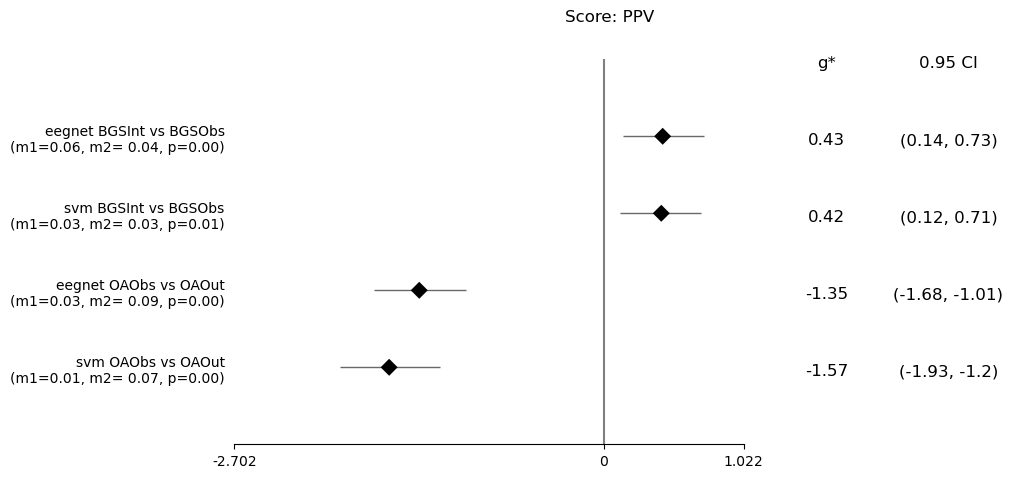

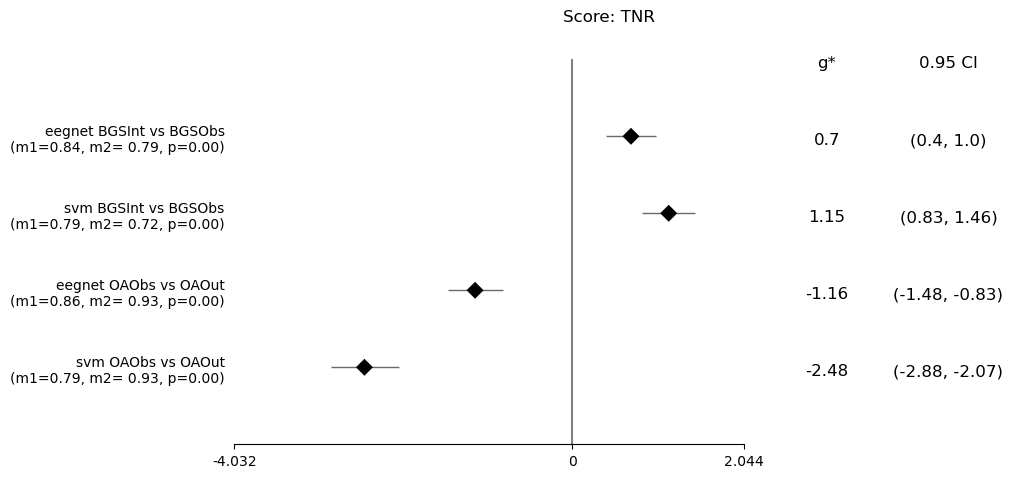

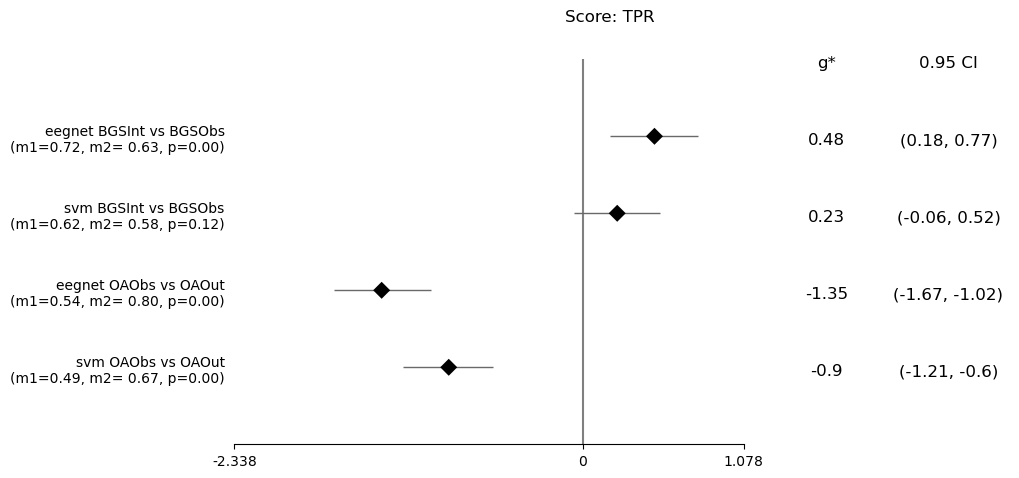

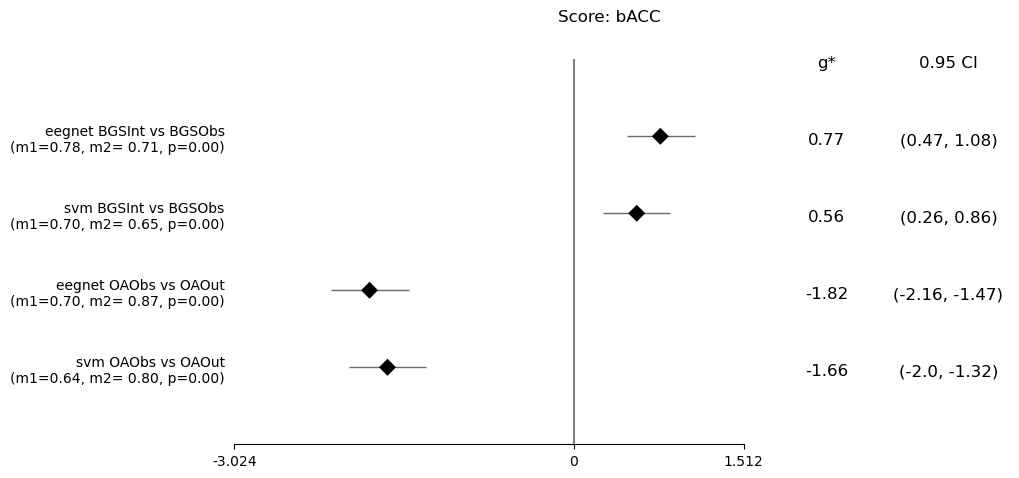

In [25]:
baseline_forest_plot(baseline_analysis, save_path=bl_plots_path, file_ext='pdf');

### Multi-Analysis Bar Plots

['BGSInt-BGSInt' 'BGSObs-BGSObs' 'OAObs-OAObs' 'OAOut-OAOut']


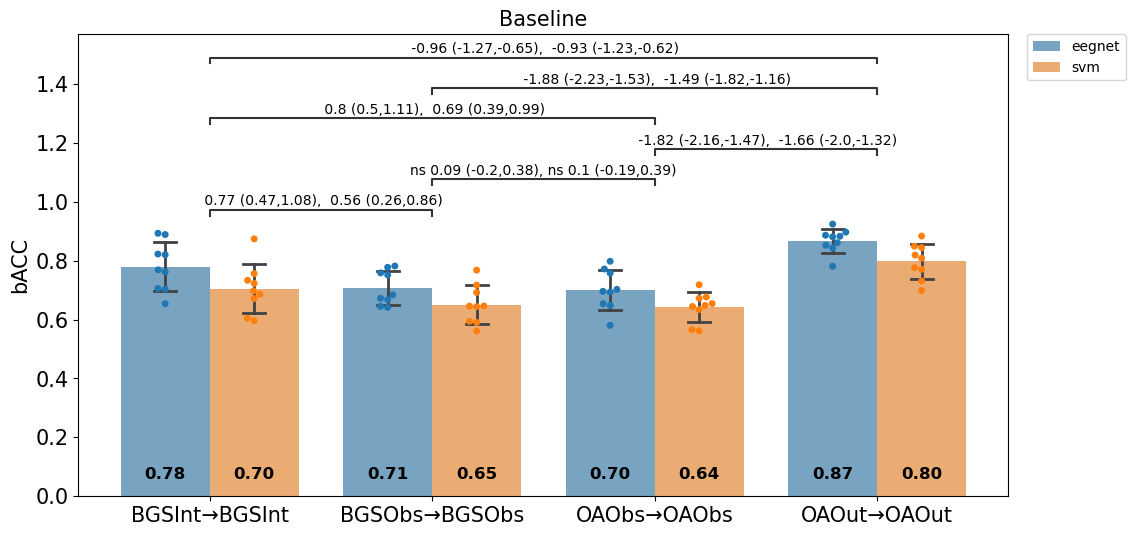

['BGSInt-BGSInt' 'BGSObs-BGSObs' 'OAObs-OAObs' 'OAOut-OAOut']


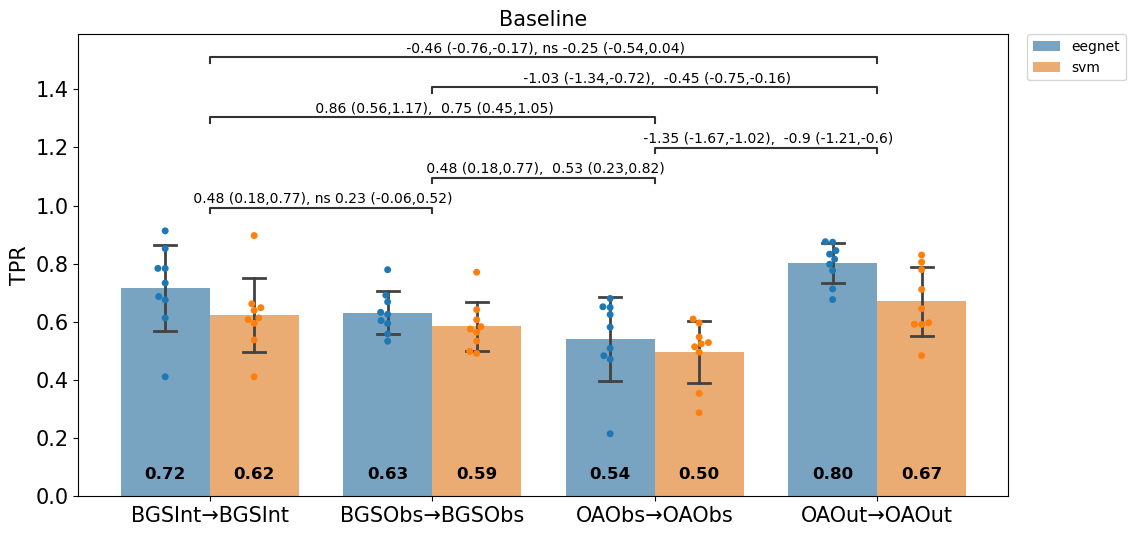

['BGSInt-BGSInt' 'BGSObs-BGSObs' 'OAObs-OAObs' 'OAOut-OAOut']


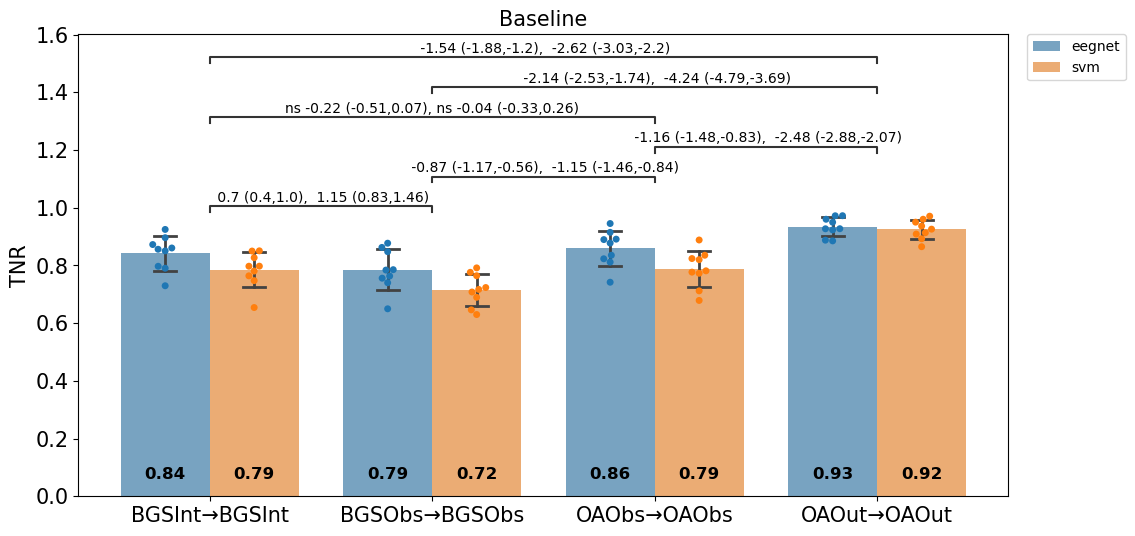

['BGSInt-BGSInt' 'BGSObs-BGSObs' 'OAObs-OAObs' 'OAOut-OAOut']


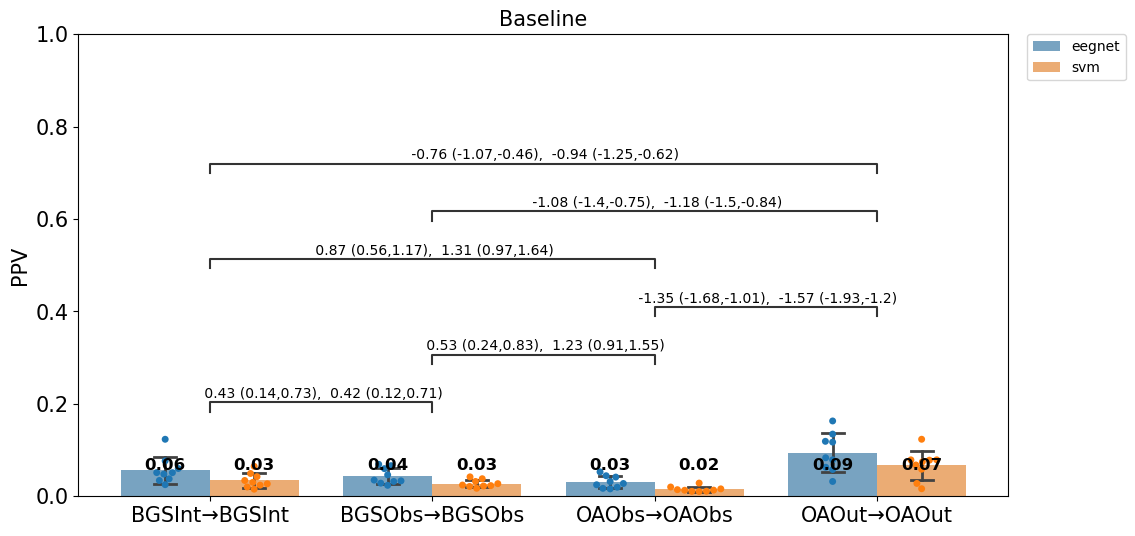

In [26]:
def get_baseline_set_locs(df, **kwargs):
    return df['tst_dataset'] == df['dataset']

def baseline_title(**kwargs):
    return f"Baseline"

def baseline_filename(**kwargs):
    return f"BAR_{kwargs['dv']}"

bp_kwargs = get_bar_plot_kwargs()
# Defaults
bp_kwargs['loc_func'] = get_baseline_set_locs
bp_kwargs['filename_func'] = baseline_filename
bp_kwargs['save_path'] = bl_plots_path

if not render_paper_plots:
    # Default kwargs when rending detailed plots (annotation plots)
    bp_kwargs['add_annotations_func'] = partial(
        add_annotations, 
        pdf=baseline_multi_analysis,
        rep=None,
        show_effect_size_value=True,
        show_effect_size_ci=True,
     )
    bp_kwargs['legend'] = True
    bp_kwargs['title_func'] = baseline_title
else:
    # Default kwargs when rending plots for paper (minimial plots)
    bp_kwargs['add_annotations_func'] = partial(
        add_annotations, 
        pdf=baseline_multi_analysis,
        rep=None,
        show_effect_size=False,
 )
       
mean_bar_plot(**bp_kwargs)

#### Save Multi-Analysis Results

In [27]:
save_results(bl_path, baseline_multi_analysis)

## Transfer

In [28]:
def same_forest_plot(df, same_set, save_path=None, file_ext='jpg'):
    if same_set not in ['target', 'source']:
        err = f"same_set must be set to either 'target' or 'source': recieved {same_set}"
        raise ValueError(err)
    
    def swap(x, target):
        def _swap(a, idx1, idx2):
            old  = a[idx1]
            a[idx1] = a[idx2]
            a[idx2] = old
        
        default = [x['group1'], x['group2'], x['mean1'], x['mean2'],
                   x['std1'], x['std2'], x['n1'], x['n2'],
                   x['Hedges_g'], x['CI_low'], x['CI_high'], x['diff'], 
                   x['conf.low'], x['conf.high']]

        if target in x['group2']:
            _swap(default, 0, 1)
            _swap(default, 2, 3)
            _swap(default, 4, 5)
            _swap(default, 6, 7)
            if np.sign(x['Hedges_g']) == -1:
                default[8:] = [-1*i for i in default[8:]]
        return default

    df = df.copy()
    keep_idx = 0 if same_set == 'target' else 1
    df['group1'] = df['group1'].str.split('-').str[keep_idx]
    df['group2'] = df['group2'].str.split('-').str[keep_idx]
    groups = df.groupby(['score', same_set])
    invert = ['group1', 'group2', 'mean1', 'mean2', 'std1', 'std2', 'n1', 'n2',
              'Hedges_g', 'CI_low', 'CI_high','diff', 'conf.low', 'conf.high']
    for name, gdf in groups:
        gdf = gdf.reset_index(drop=False)
        score, set_  = gdf['score'][0], gdf[same_set][0]
        new_grps = gdf.apply(swap, axis=1, target=set_, result_type='expand')
        gdf[invert] = pd.DataFrame(new_grps)

        # Set correct order
        gdf["name_order"] = 1
        name_idx = (gdf['group1'] == set_) | (gdf['group2'] == set_)
        gdf.loc[name_idx, "name_order"] = 0
        gdf = gdf.sort_values(['name_order', 'group1', 'group2',])
        
        labels = make_labels(
            df=gdf,
            tmplt="{}\n {} vs {}\n(m1={}, m2={}, p.adj={})",
            use_columns=['exps', 'group1', 'group2', 'mean1', 'mean2', 'p.adj']
        )
        
        p, ax = forest_plot(
            labels=labels,
            measure=gdf['Hedges_g'].values,
            lcl=gdf['CI_low'].values,
            ucl=gdf['CI_high'].values,
            subtitle=f"Score: {score} {same_set.capitalize()}: {set_}",
            ci=.95,
            measure_label='g*',
            table_adjust=0.04,
            figsize=(10,10)
        )
        ax.axhline(5.5, 0, 1)
        
        if save_path is not None:
            filename = f"FOREST_{score}-{set_}" + f'.{file_ext}'
            filepath = os.path.join(save_path, filename)
            plt.savefig(filepath, bbox_inches='tight')


### Same Target (Same Test)

#### Forest Plots

In [29]:
# same_forest_plot(same_target_analysis, same_set='target', save_path=stst_plots_path, file_ext='pdf');

#### Bar Plots

['BGSInt-BGSInt' 'BGSObs-BGSInt' 'OAObs-BGSInt' 'OAOut-BGSInt']


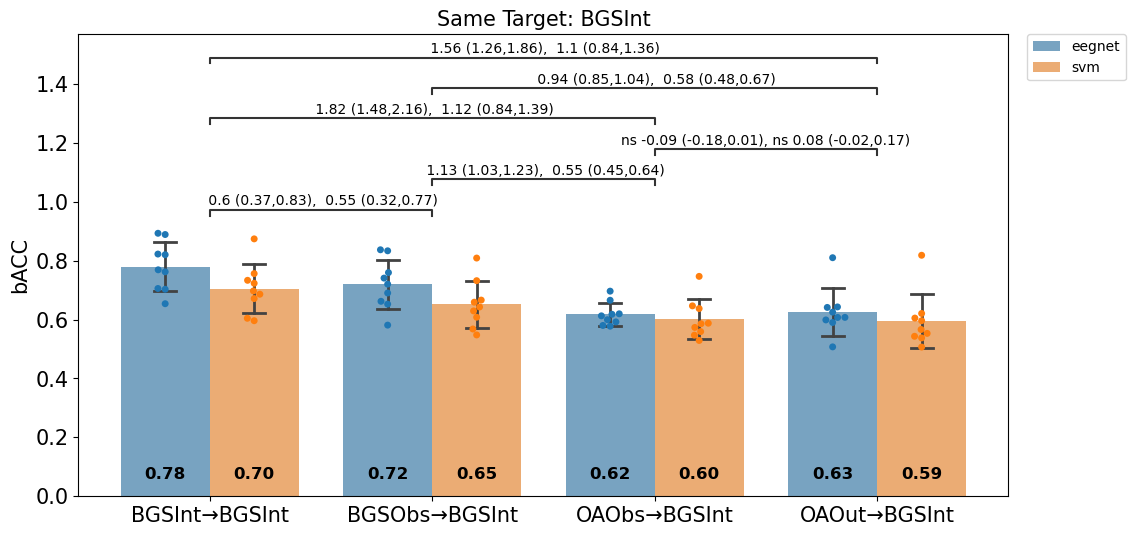

['BGSObs-BGSObs' 'BGSInt-BGSObs' 'OAObs-BGSObs' 'OAOut-BGSObs']
('BGSInt-BGSObs', 'BGSObs-BGSObs') [1] [0]


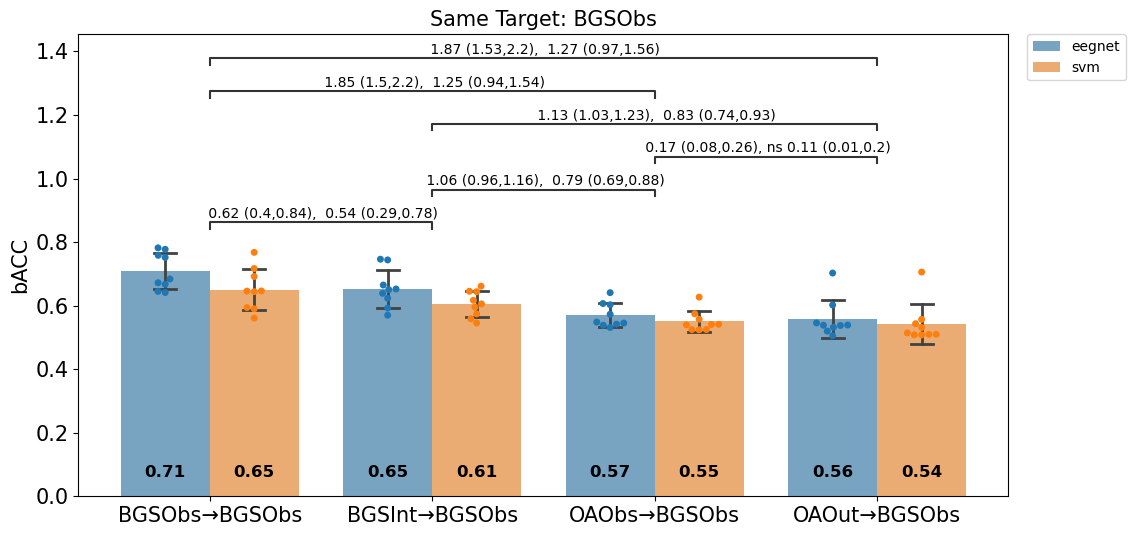

['OAOut-OAOut' 'BGSObs-OAOut' 'OAObs-OAOut' 'BGSInt-OAOut']
('BGSInt-OAOut', 'BGSObs-OAOut') [3] [1]
('BGSInt-OAOut', 'OAObs-OAOut') [3] [2]
('BGSInt-OAOut', 'OAOut-OAOut') [3] [0]
('BGSObs-OAOut', 'OAOut-OAOut') [1] [0]
('OAObs-OAOut', 'OAOut-OAOut') [2] [0]


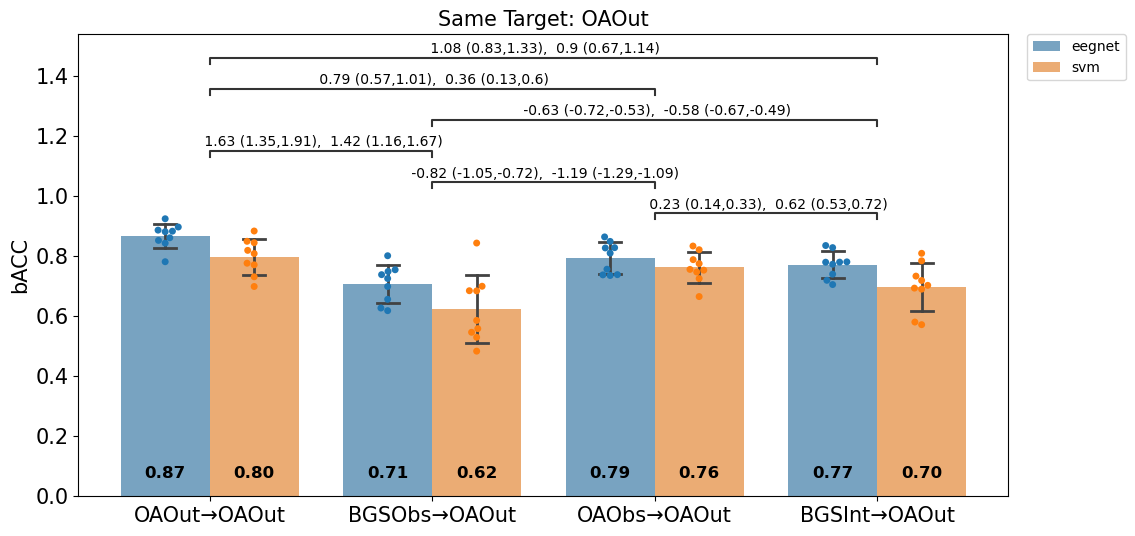

['OAObs-OAObs' 'BGSObs-OAObs' 'BGSInt-OAObs' 'OAOut-OAObs']
('BGSInt-OAObs', 'BGSObs-OAObs') [2] [1]
('BGSInt-OAObs', 'OAObs-OAObs') [2] [0]
('BGSObs-OAObs', 'OAObs-OAObs') [1] [0]


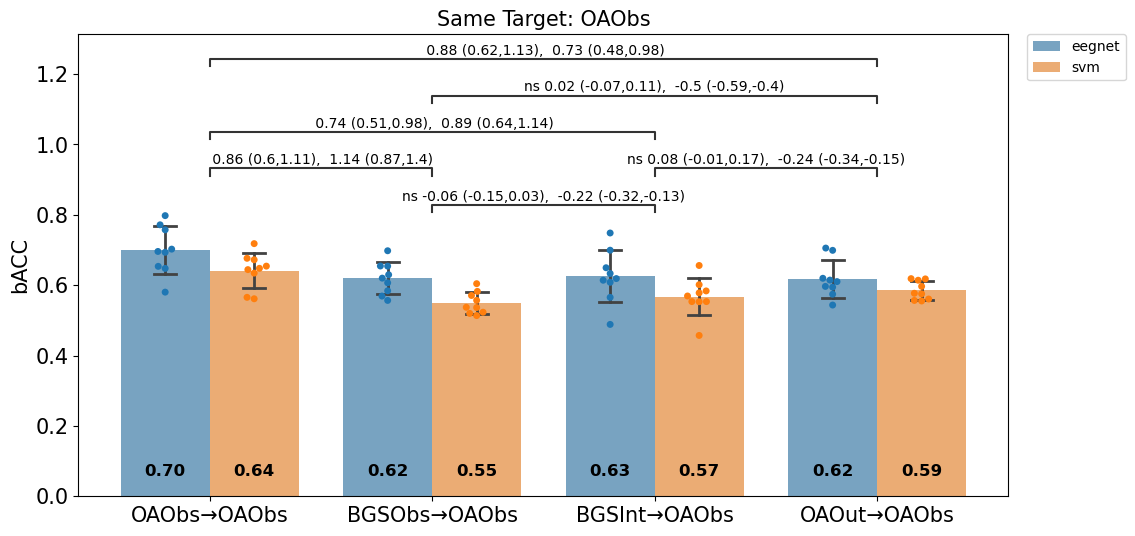

['BGSInt-BGSInt' 'BGSObs-BGSInt' 'OAObs-BGSInt' 'OAOut-BGSInt']


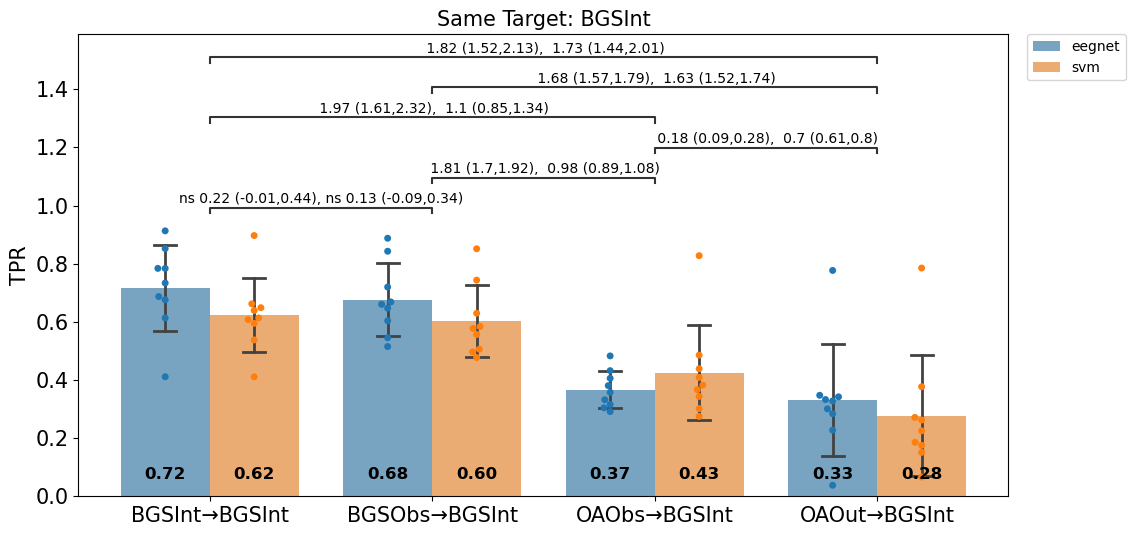

['BGSObs-BGSObs' 'BGSInt-BGSObs' 'OAObs-BGSObs' 'OAOut-BGSObs']
('BGSInt-BGSObs', 'BGSObs-BGSObs') [1] [0]


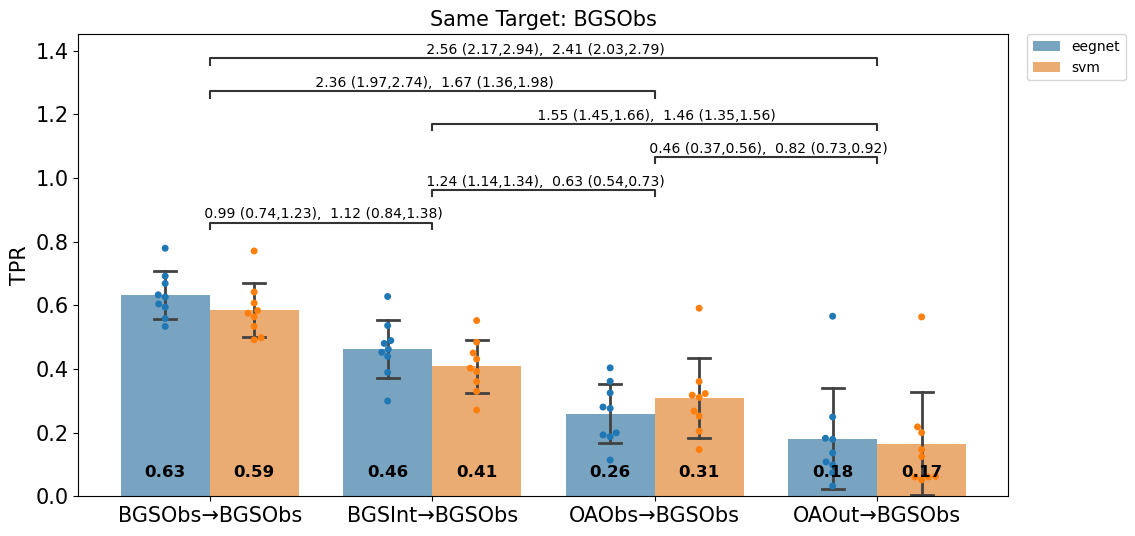

['OAOut-OAOut' 'BGSObs-OAOut' 'OAObs-OAOut' 'BGSInt-OAOut']
('BGSInt-OAOut', 'BGSObs-OAOut') [3] [1]
('BGSInt-OAOut', 'OAObs-OAOut') [3] [2]
('BGSInt-OAOut', 'OAOut-OAOut') [3] [0]
('BGSObs-OAOut', 'OAOut-OAOut') [1] [0]
('OAObs-OAOut', 'OAOut-OAOut') [2] [0]


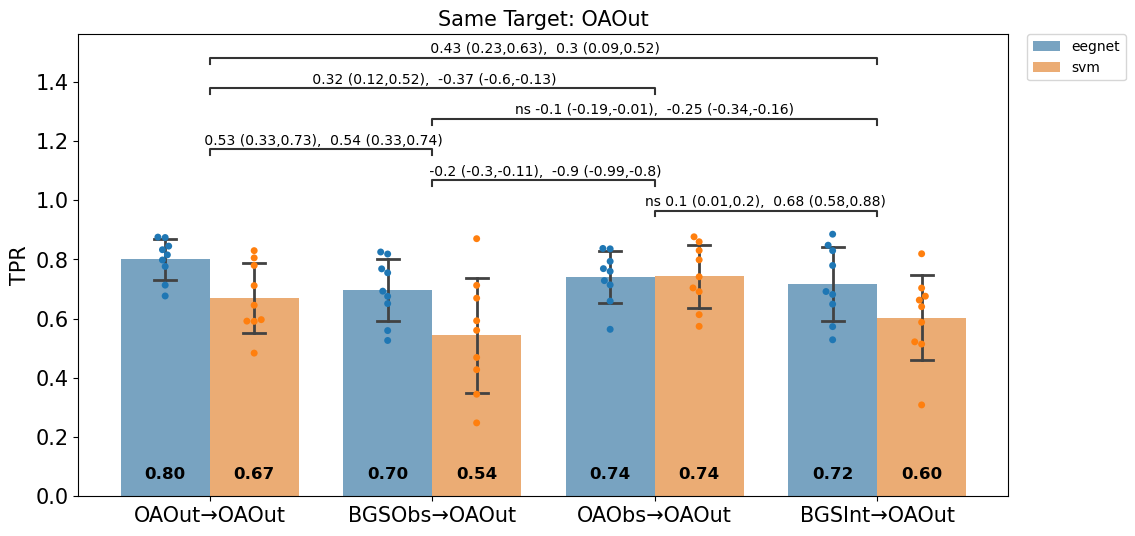

['OAObs-OAObs' 'BGSObs-OAObs' 'BGSInt-OAObs' 'OAOut-OAObs']
('BGSInt-OAObs', 'BGSObs-OAObs') [2] [1]
('BGSInt-OAObs', 'OAObs-OAObs') [2] [0]
('BGSObs-OAObs', 'OAObs-OAObs') [1] [0]


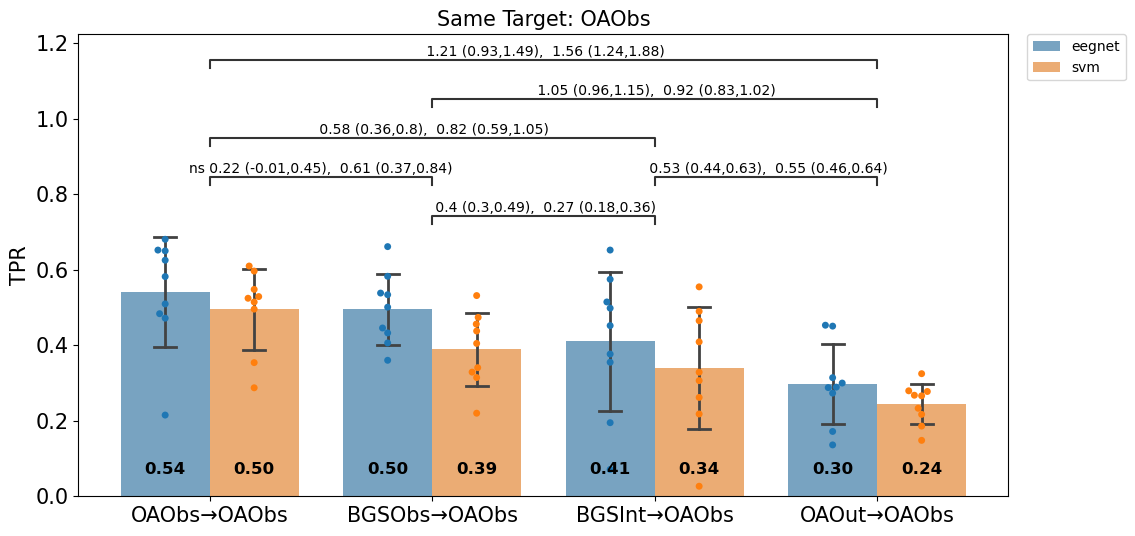

['BGSInt-BGSInt' 'BGSObs-BGSInt' 'OAObs-BGSInt' 'OAOut-BGSInt']


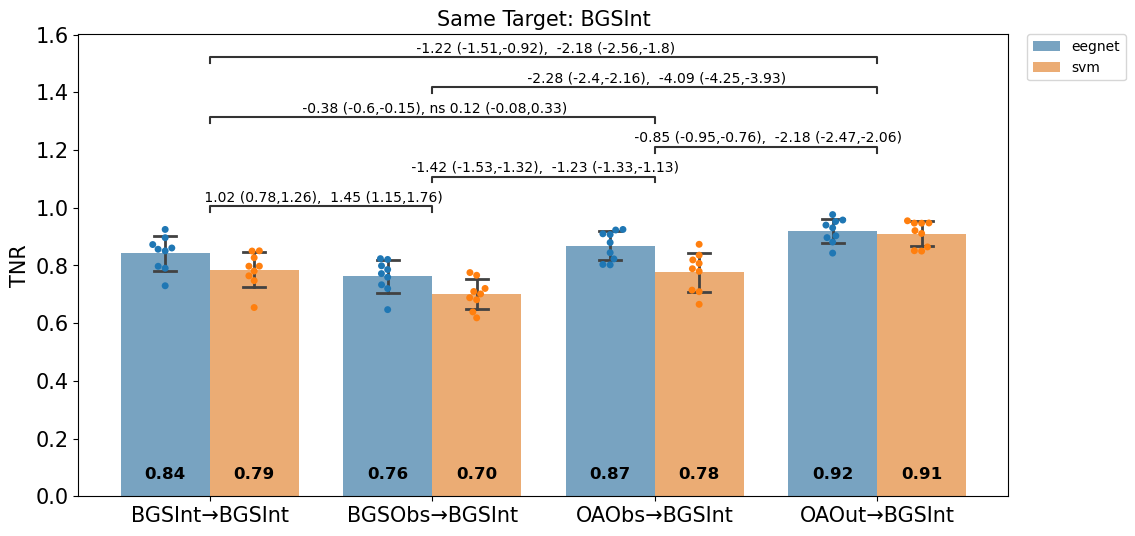

['BGSObs-BGSObs' 'BGSInt-BGSObs' 'OAObs-BGSObs' 'OAOut-BGSObs']
('BGSInt-BGSObs', 'BGSObs-BGSObs') [1] [0]


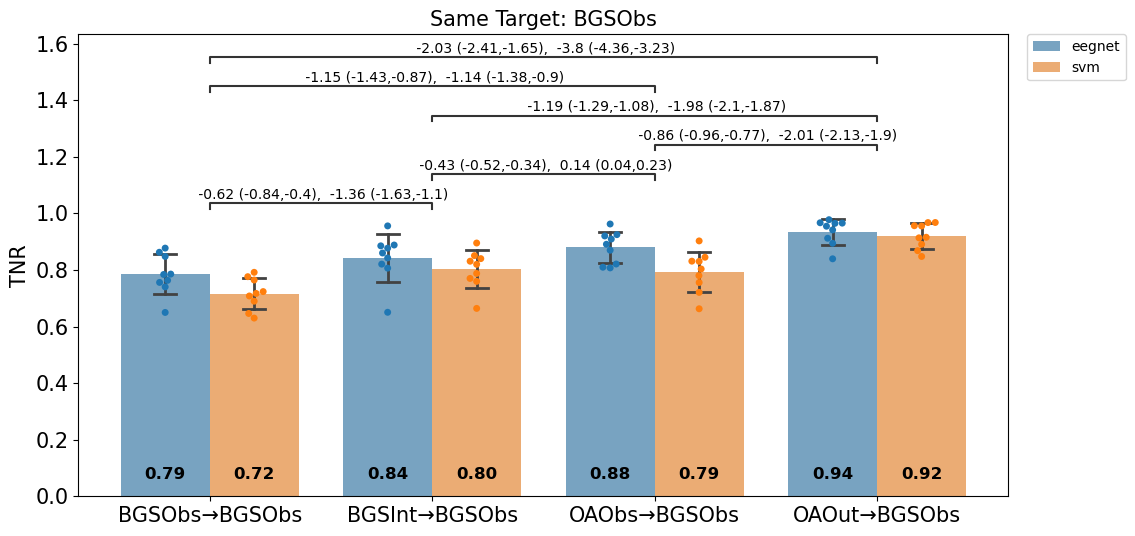

['OAOut-OAOut' 'BGSObs-OAOut' 'OAObs-OAOut' 'BGSInt-OAOut']
('BGSInt-OAOut', 'BGSObs-OAOut') [3] [1]
('BGSInt-OAOut', 'OAObs-OAOut') [3] [2]
('BGSInt-OAOut', 'OAOut-OAOut') [3] [0]
('BGSObs-OAOut', 'OAOut-OAOut') [1] [0]
('OAObs-OAOut', 'OAOut-OAOut') [2] [0]


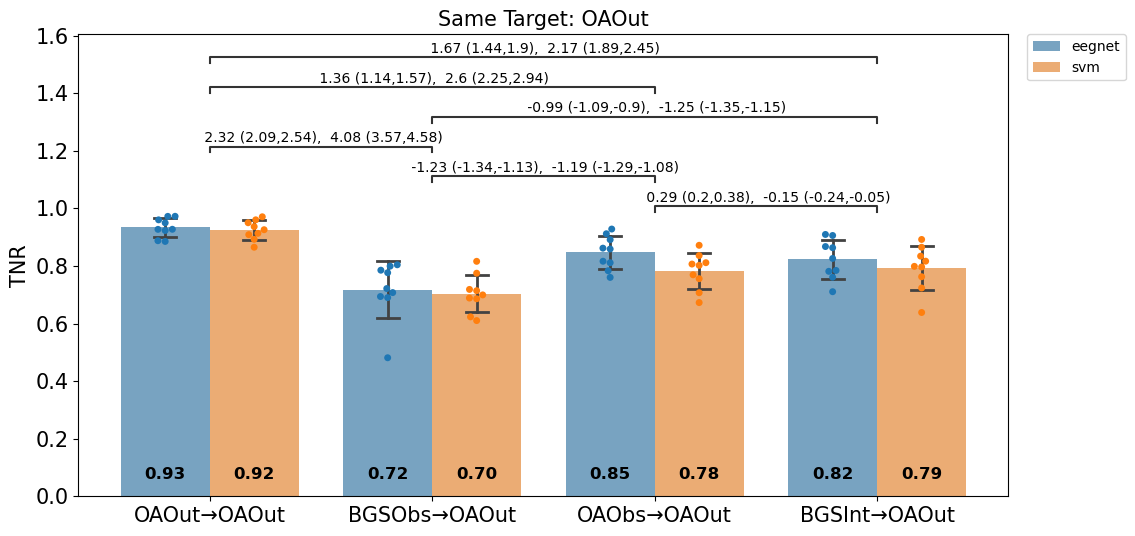

['OAObs-OAObs' 'BGSObs-OAObs' 'BGSInt-OAObs' 'OAOut-OAObs']
('BGSInt-OAObs', 'BGSObs-OAObs') [2] [1]
('BGSInt-OAObs', 'OAObs-OAObs') [2] [0]
('BGSObs-OAObs', 'OAObs-OAObs') [1] [0]


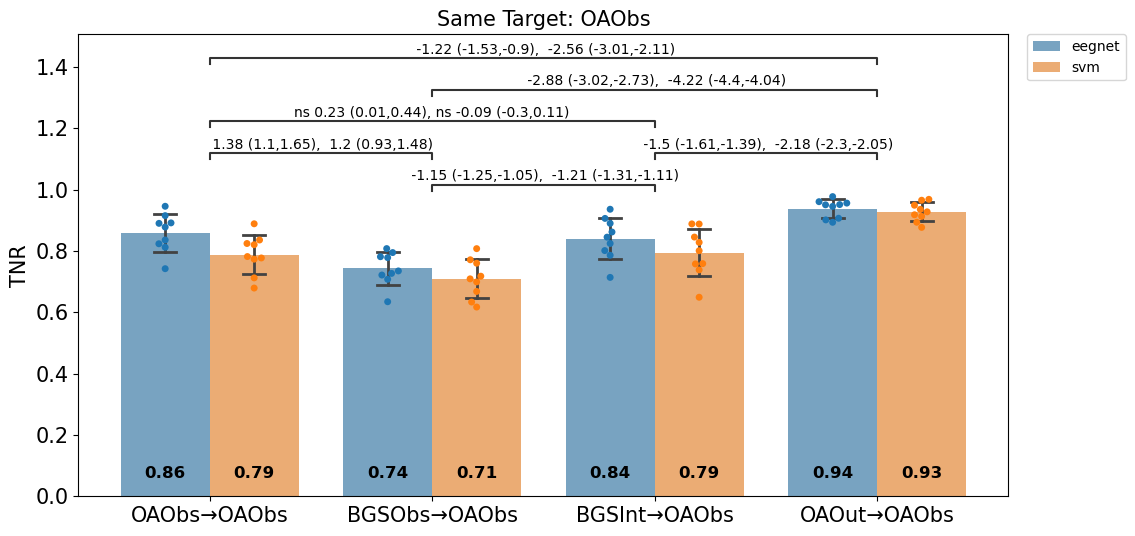

['BGSInt-BGSInt' 'BGSObs-BGSInt' 'OAObs-BGSInt' 'OAOut-BGSInt']


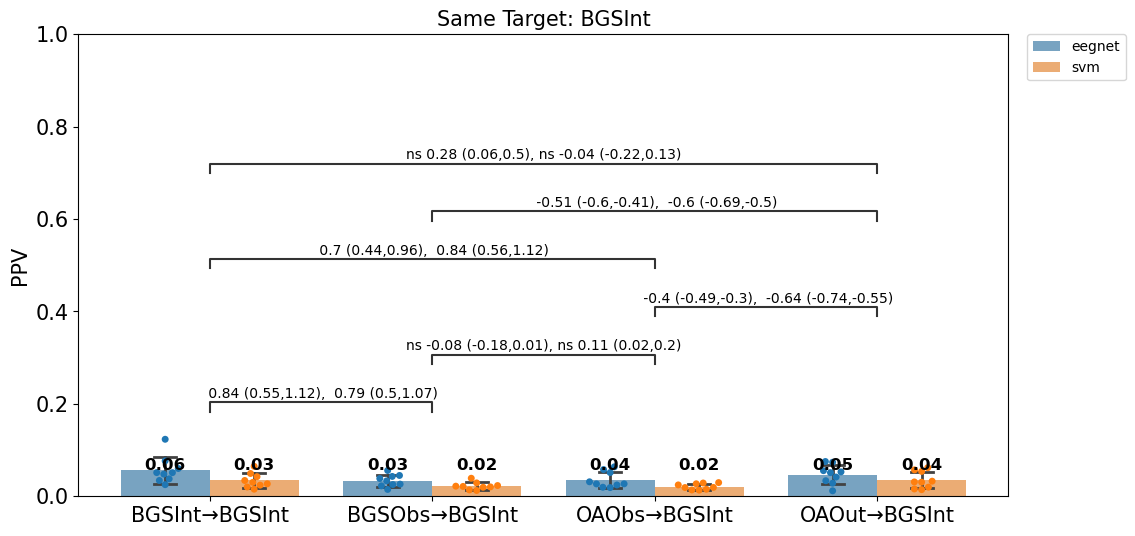

['BGSObs-BGSObs' 'BGSInt-BGSObs' 'OAObs-BGSObs' 'OAOut-BGSObs']
('BGSInt-BGSObs', 'BGSObs-BGSObs') [1] [0]


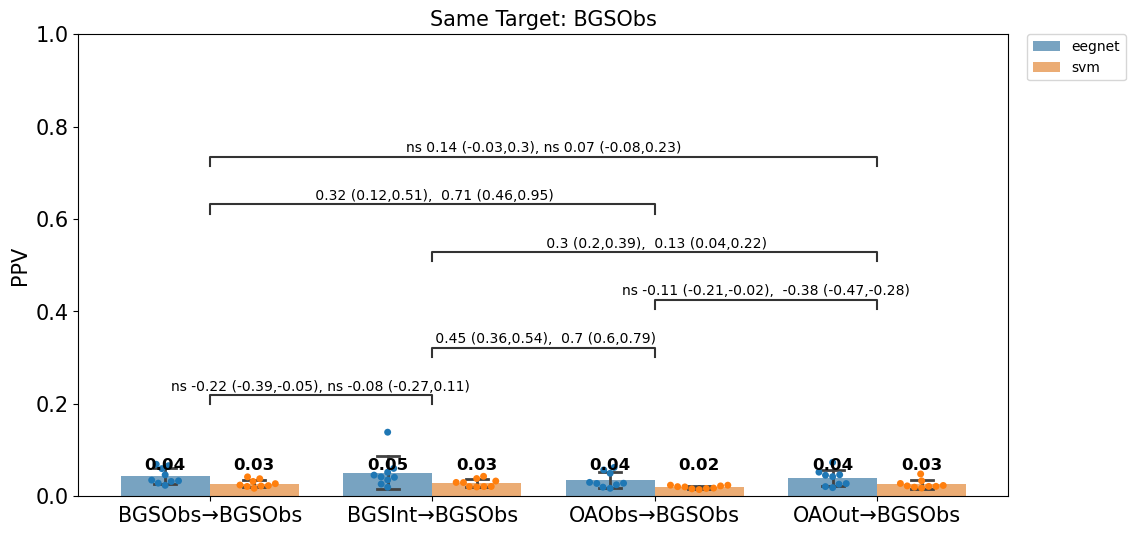

['OAOut-OAOut' 'BGSObs-OAOut' 'OAObs-OAOut' 'BGSInt-OAOut']
('BGSInt-OAOut', 'BGSObs-OAOut') [3] [1]
('BGSInt-OAOut', 'OAObs-OAOut') [3] [2]
('BGSInt-OAOut', 'OAOut-OAOut') [3] [0]
('BGSObs-OAOut', 'OAOut-OAOut') [1] [0]
('OAObs-OAOut', 'OAOut-OAOut') [2] [0]


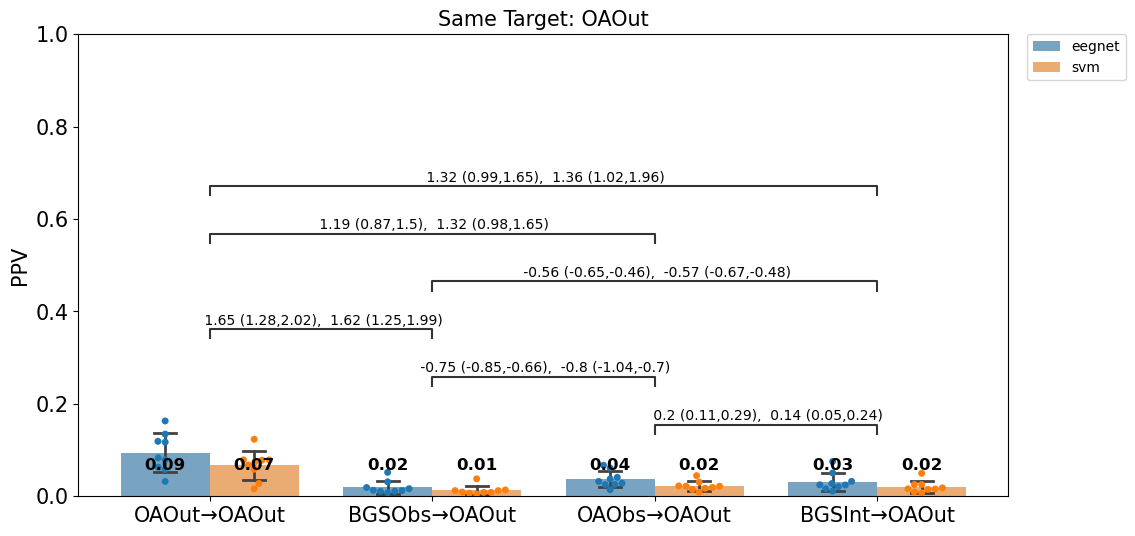

['OAObs-OAObs' 'BGSObs-OAObs' 'BGSInt-OAObs' 'OAOut-OAObs']
('BGSInt-OAObs', 'BGSObs-OAObs') [2] [1]
('BGSInt-OAObs', 'OAObs-OAObs') [2] [0]
('BGSObs-OAObs', 'OAObs-OAObs') [1] [0]


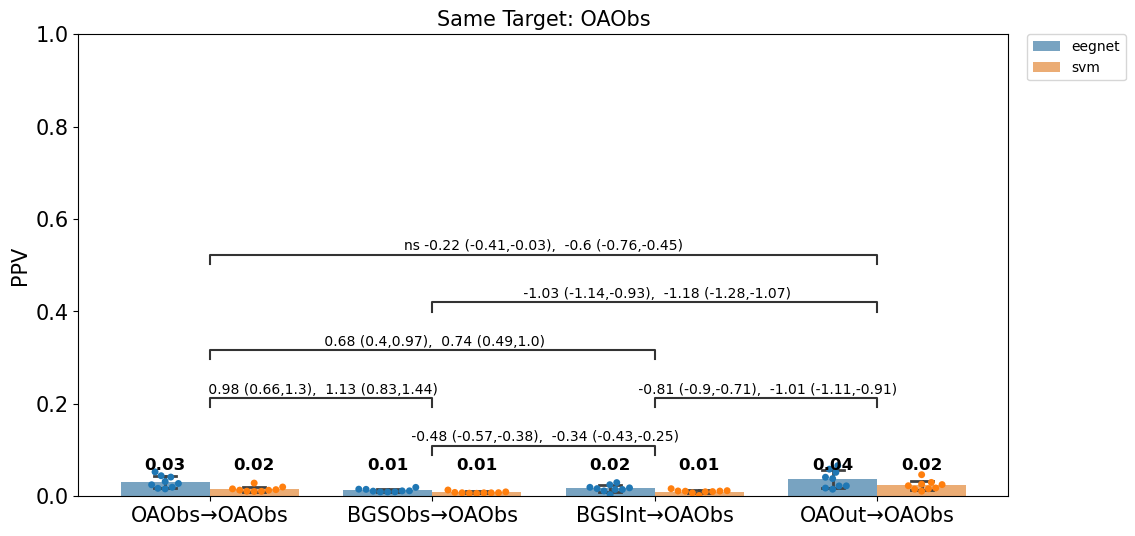

In [30]:
def same_source_test_filename(**kwargs):
    return f"BAR_{kwargs['dv']}-{kwargs['task']}"

def same_source_test_title(**kwargs):
    return f"Same {kwargs['same_set'].capitalize()}: {kwargs['task']}"

def get_same_set_locs(same_set):
    
    def _get_same_set_locs(df, column_name, **kwargs):
        return df[column_name] == kwargs['task']
    
    if same_set.lower() == 'target':
        target_col = 'dataset'
    elif same_set.lower() == 'source':
        target_col = 'tst_dataset'
    else:
        err = f"same_set must be set to either 'target' or 'source': received {same_set}"
        raise ValueError(err)
    
    return partial(_get_same_set_locs, column_name=target_col)

def source_task_first(df):
    values = df['group'].unique()

    for i, v in enumerate(values):
        source, target = v.split('-')
        if source == target:
            old = values[0]
            values[0] = v
            values[i] = old
            break

    return values

same_set = 'target'
bp_kwargs = get_bar_plot_kwargs()
# Defaults
bp_kwargs['loc_func'] = get_same_set_locs(same_set=same_set)
bp_kwargs['task_plot_vars'] = dict(
    plot1='BGSInt', 
    plot2='BGSObs', 
    plot3='OAOut',
    plot4='OAObs'
)
bp_kwargs['order_func'] = source_task_first
bp_kwargs['filename_func'] = same_source_test_filename
bp_kwargs['save_path'] = stst_plots_path


if not render_paper_plots:
    # Default kwargs when rending detailed plots (annotation plots)
    bp_kwargs['add_annotations_func'] = partial(
         add_annotations, 
         pdf=same_target_analysis,
         rep=None,
        show_effect_size_value=True,
        show_effect_size_ci=True,
    )
    bp_kwargs['legend'] = True
    bp_kwargs['title_func'] = partial(same_source_test_title, same_set=same_set)
else:
    # Default kwargs when rending plots for paper (minimal plots)
    bp_kwargs['add_annotations_func'] = partial(
        add_annotations, 
        pdf=same_target_analysis,
        rep=None,
        show_effect_size=False,
    )
mean_bar_plot(**bp_kwargs)

#### Save Results

In [31]:
stst_path = os.path.join(analysis_path, 'same_target')
save_results(stst_path, same_target_analysis)

### Same Source ( Same Train)

#### Forest Plots

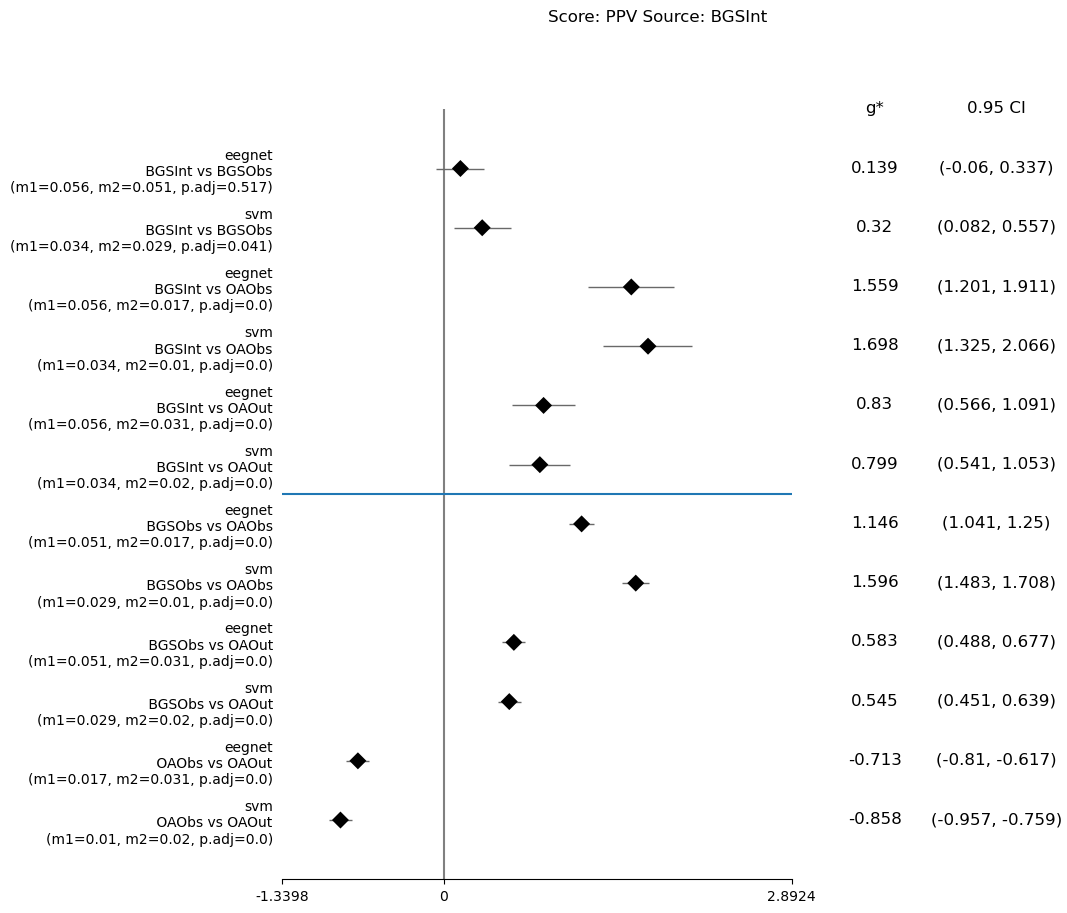

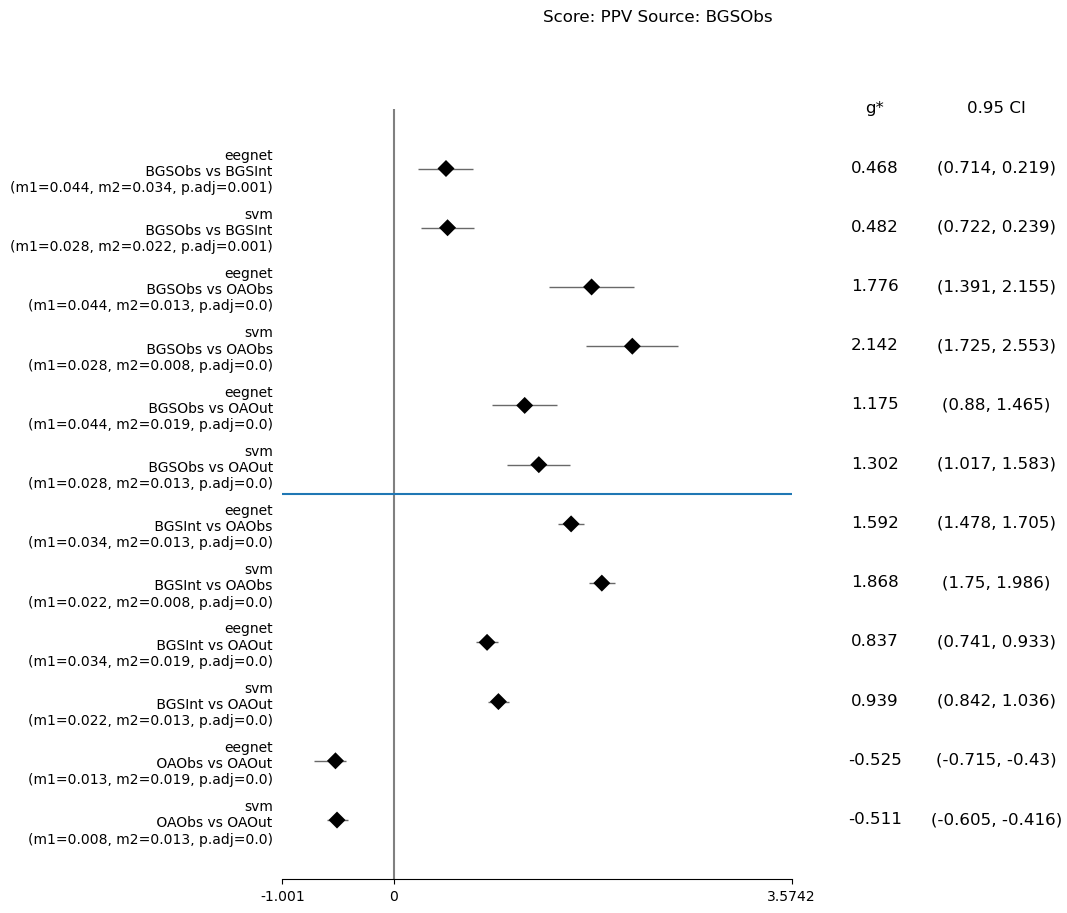

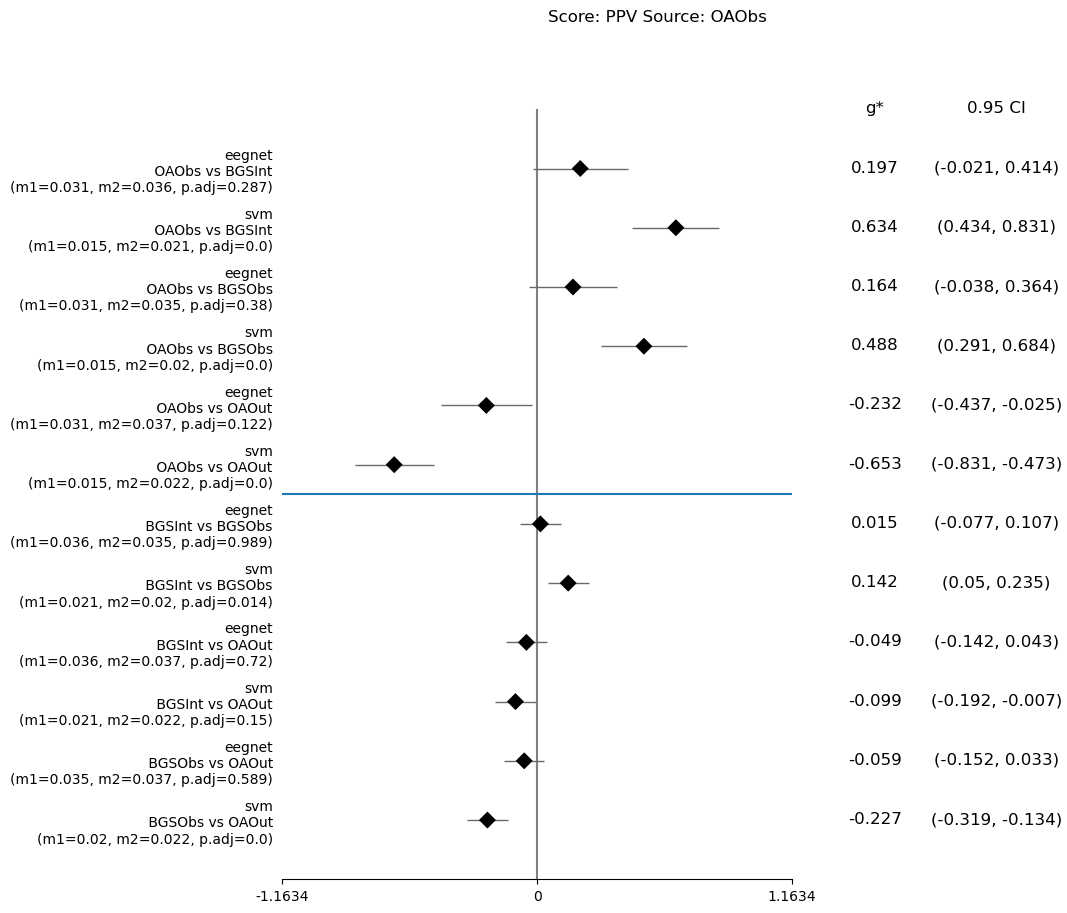

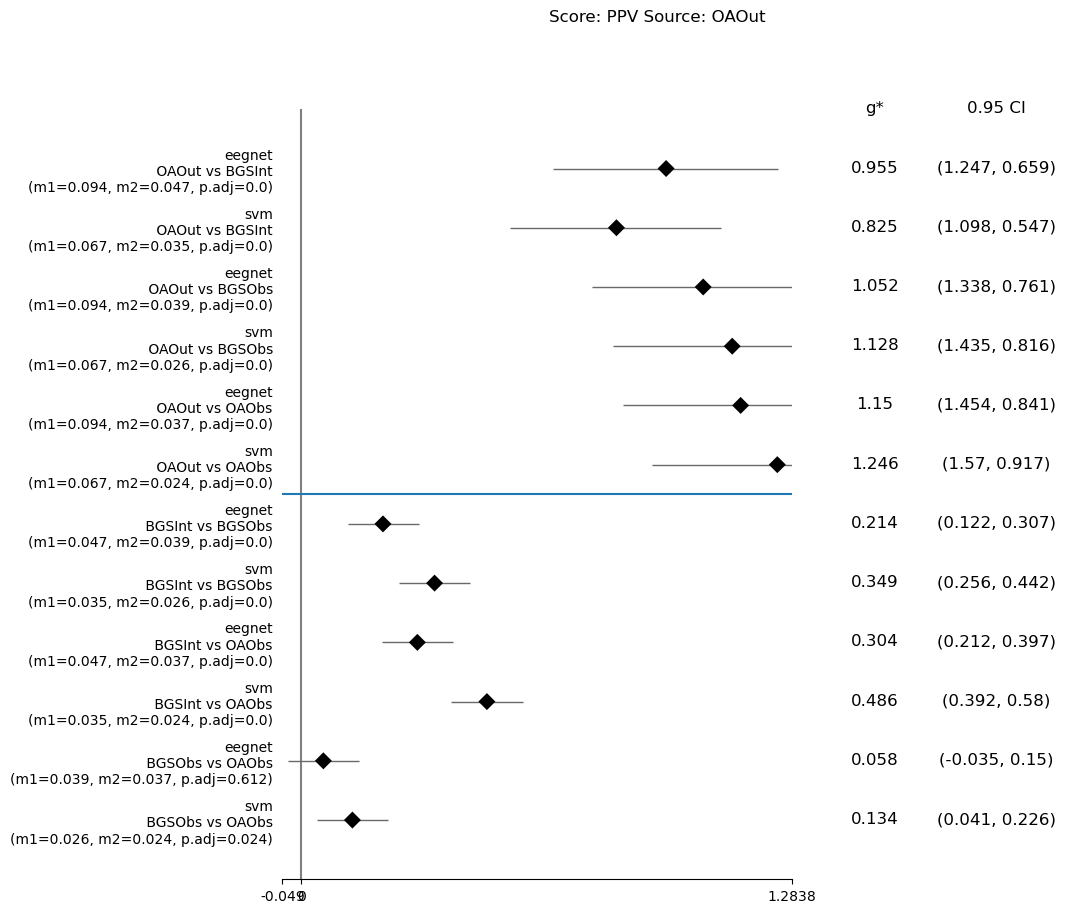

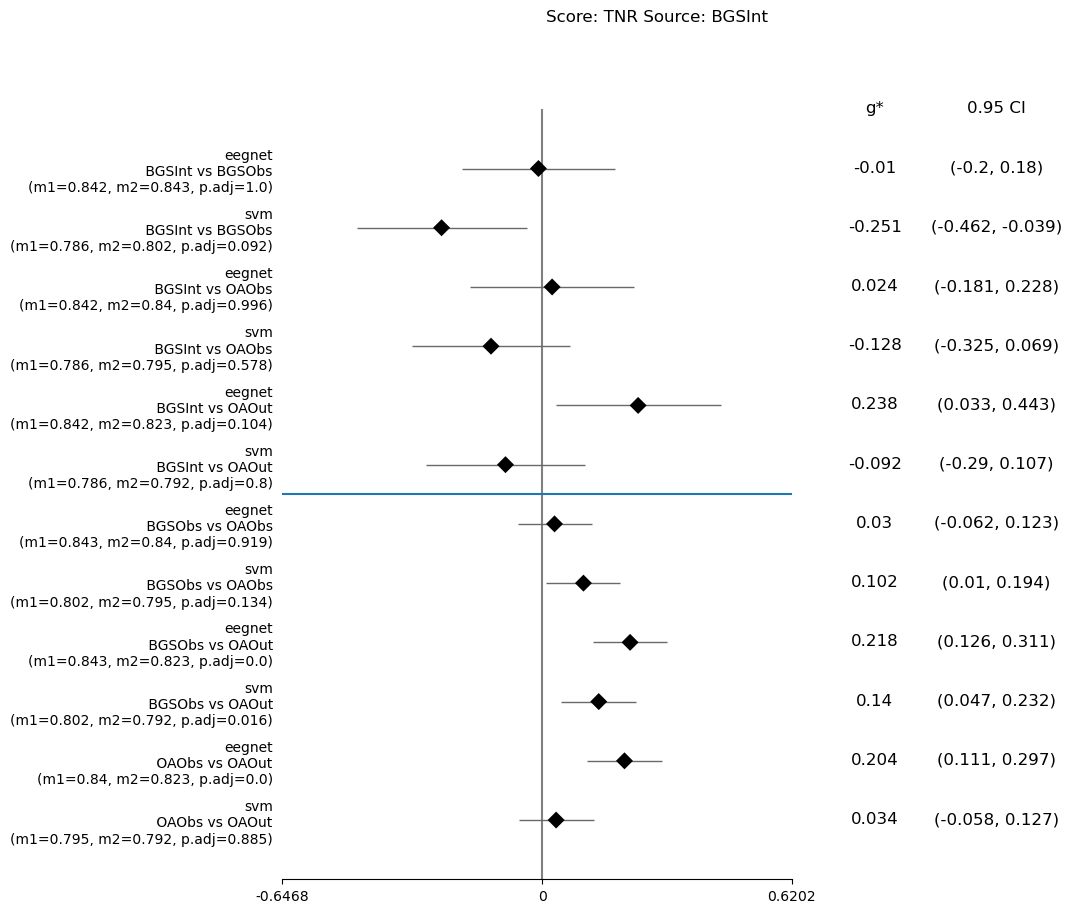

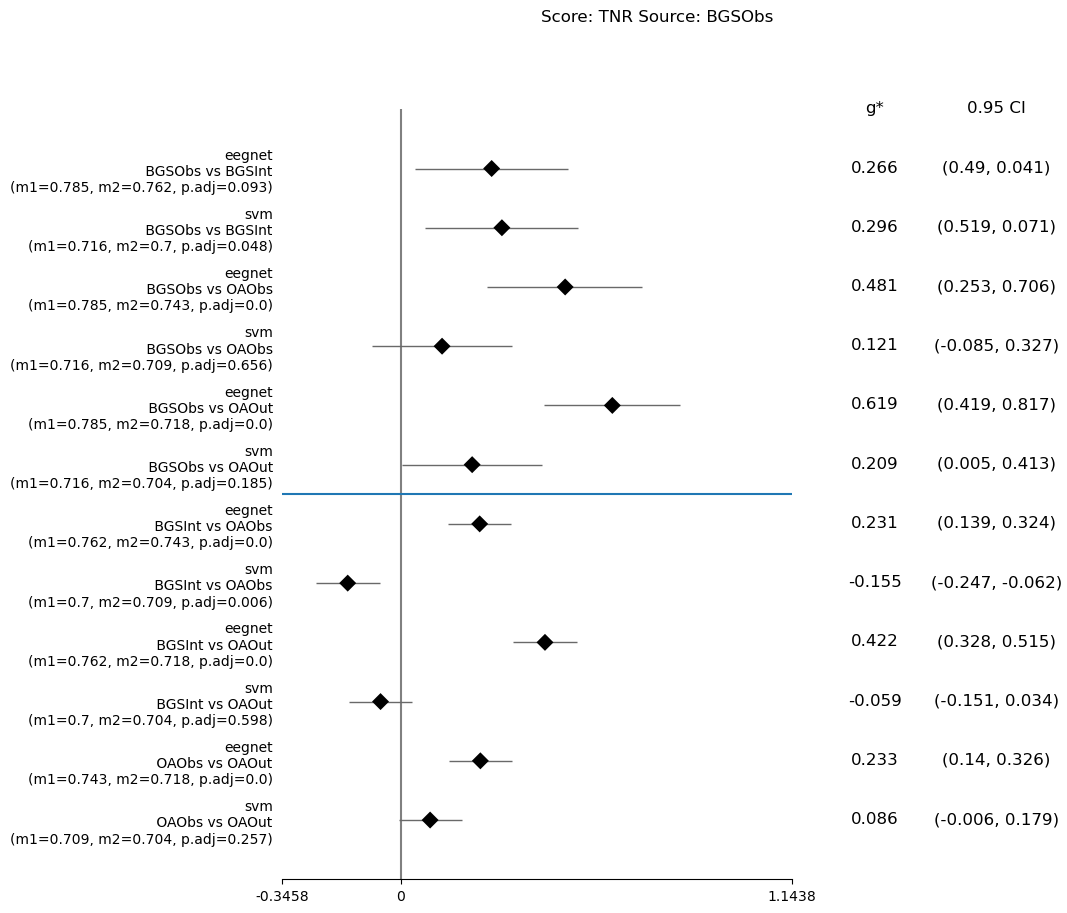

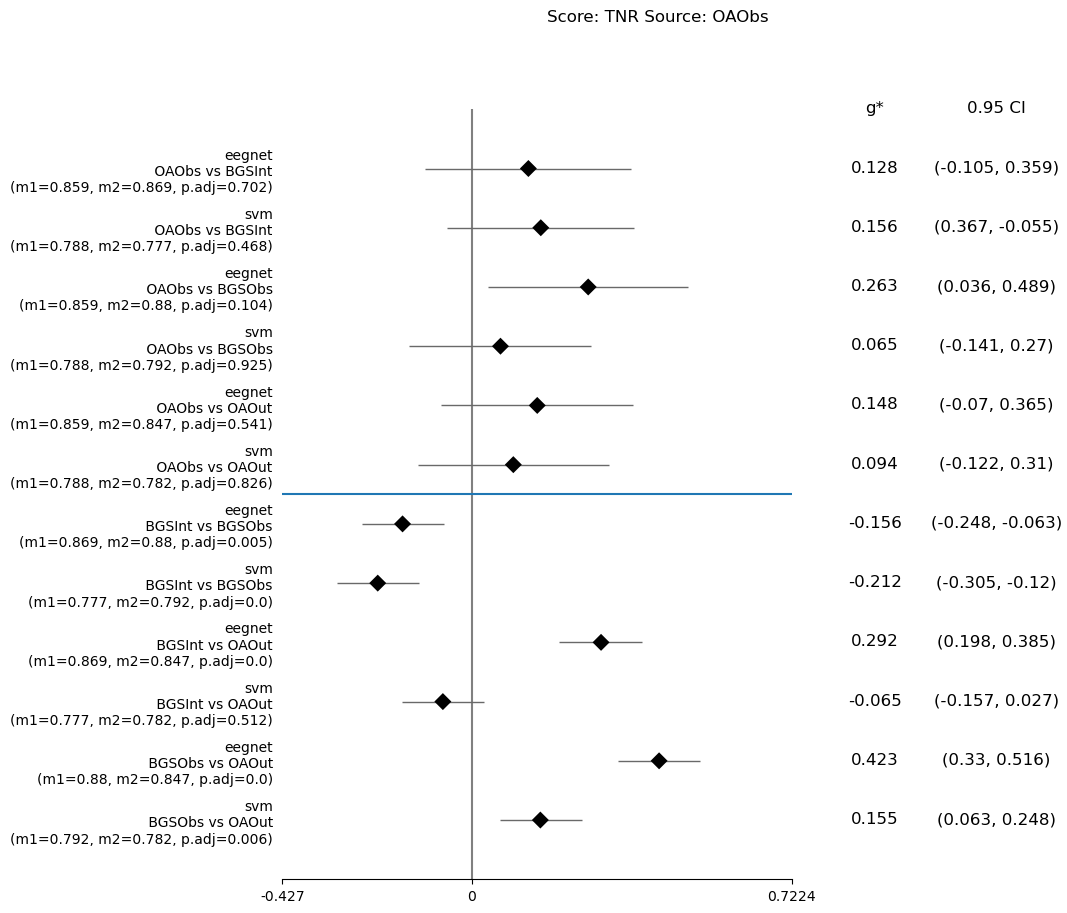

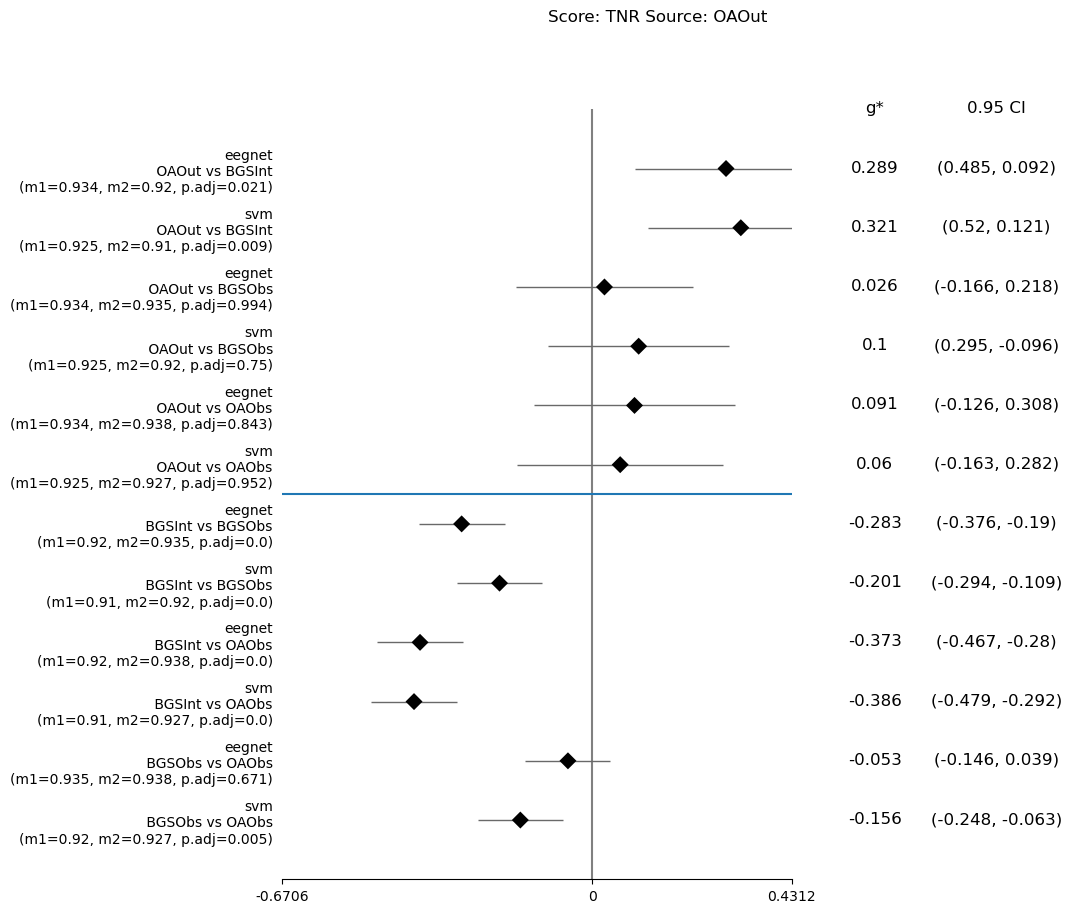

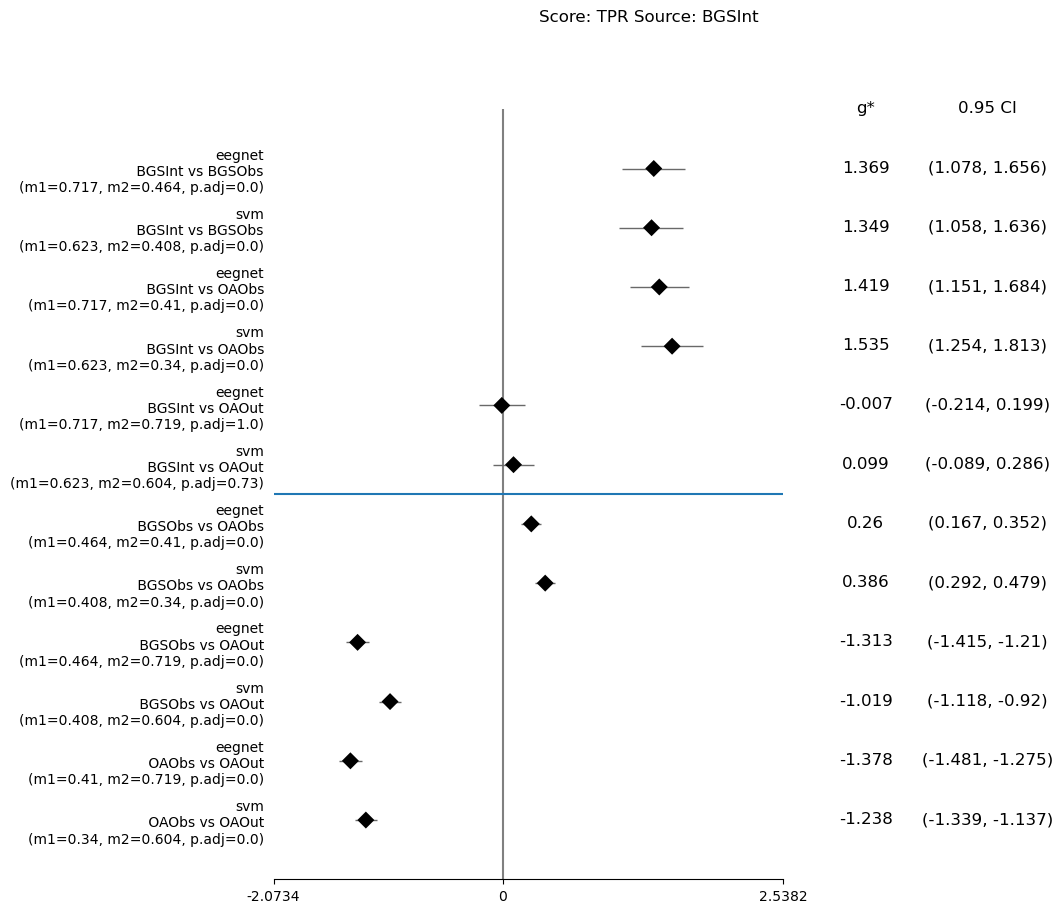

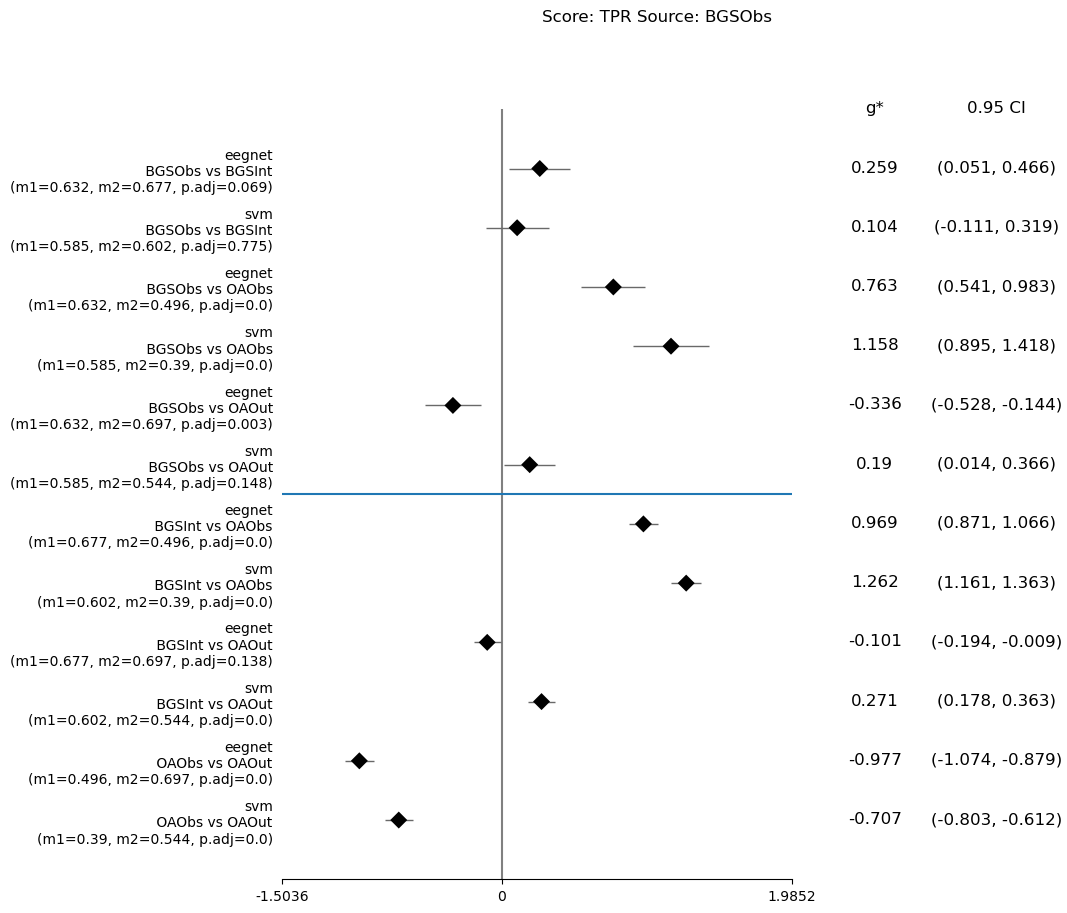

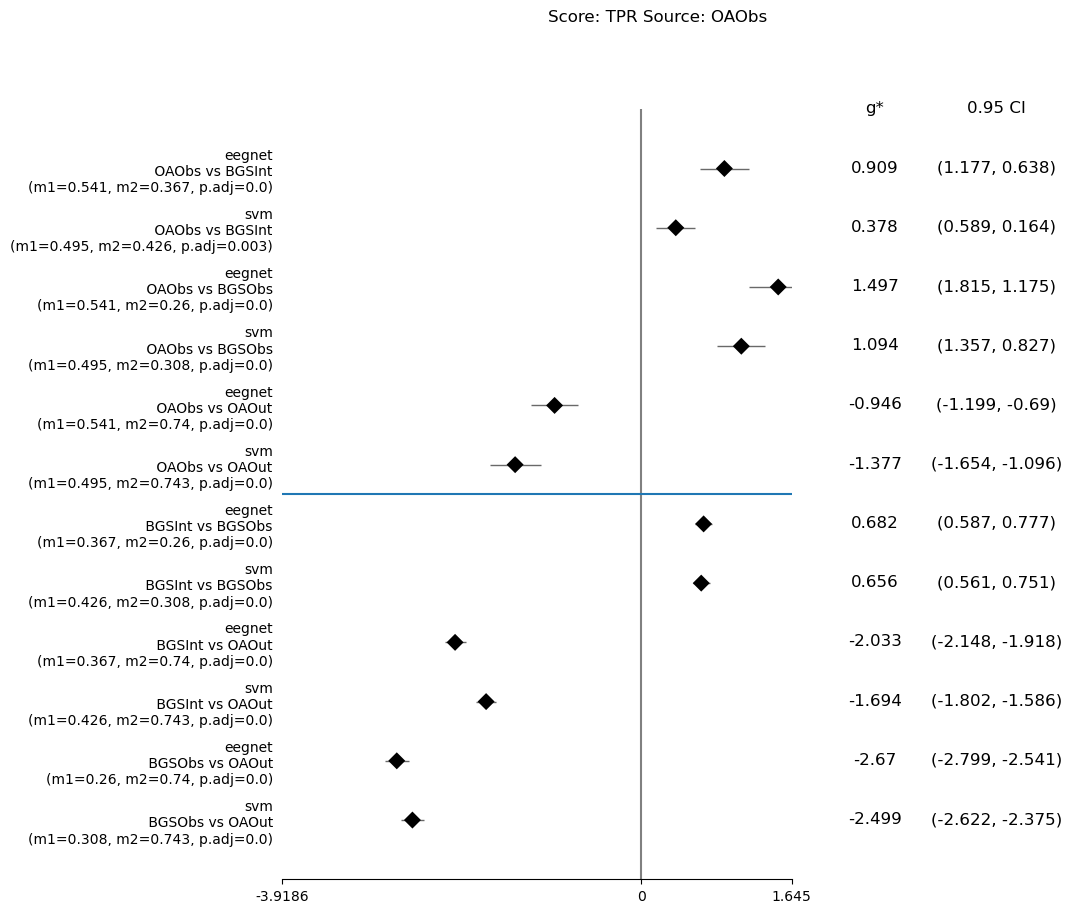

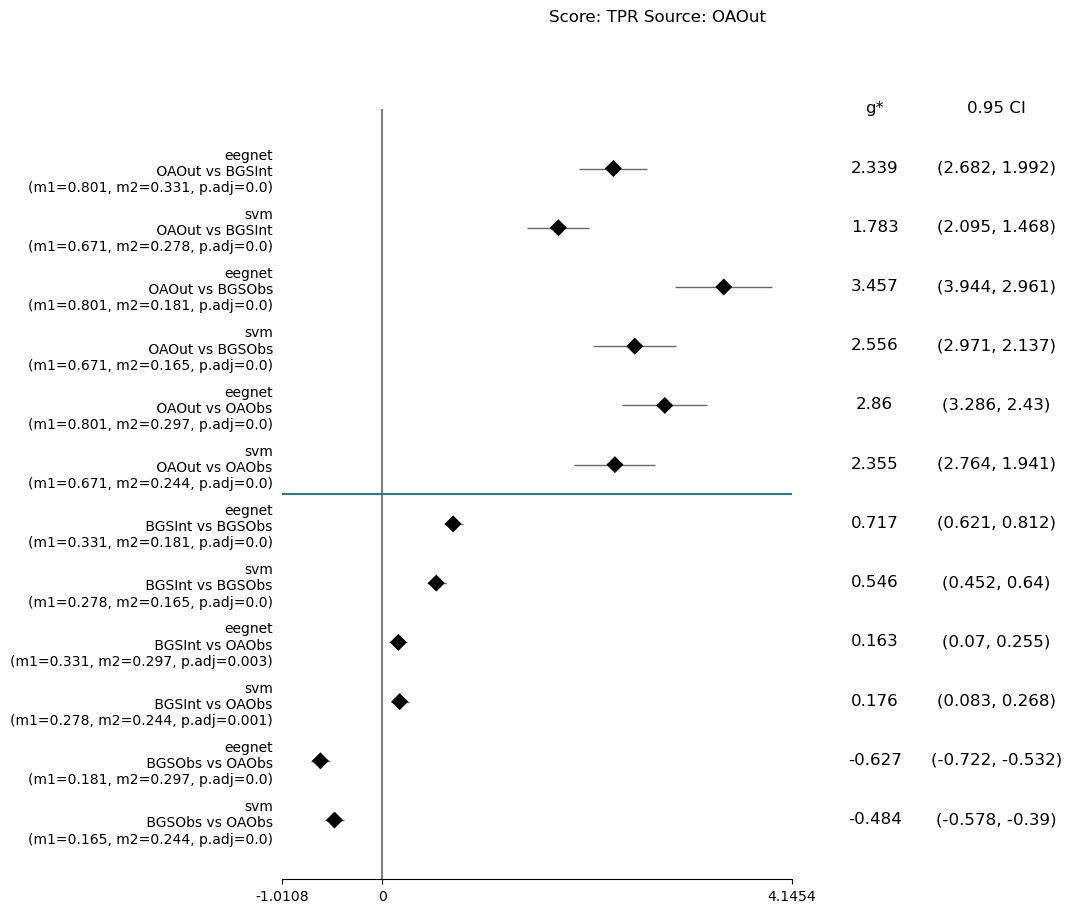

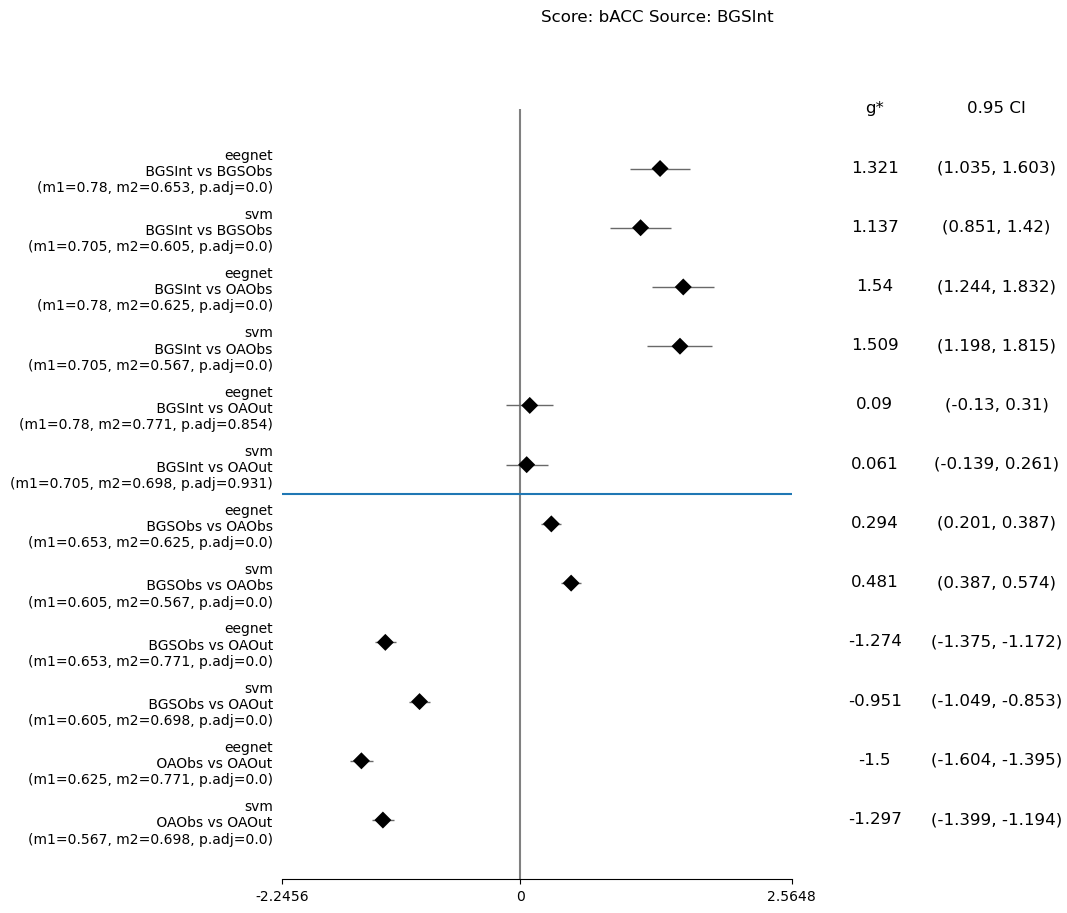

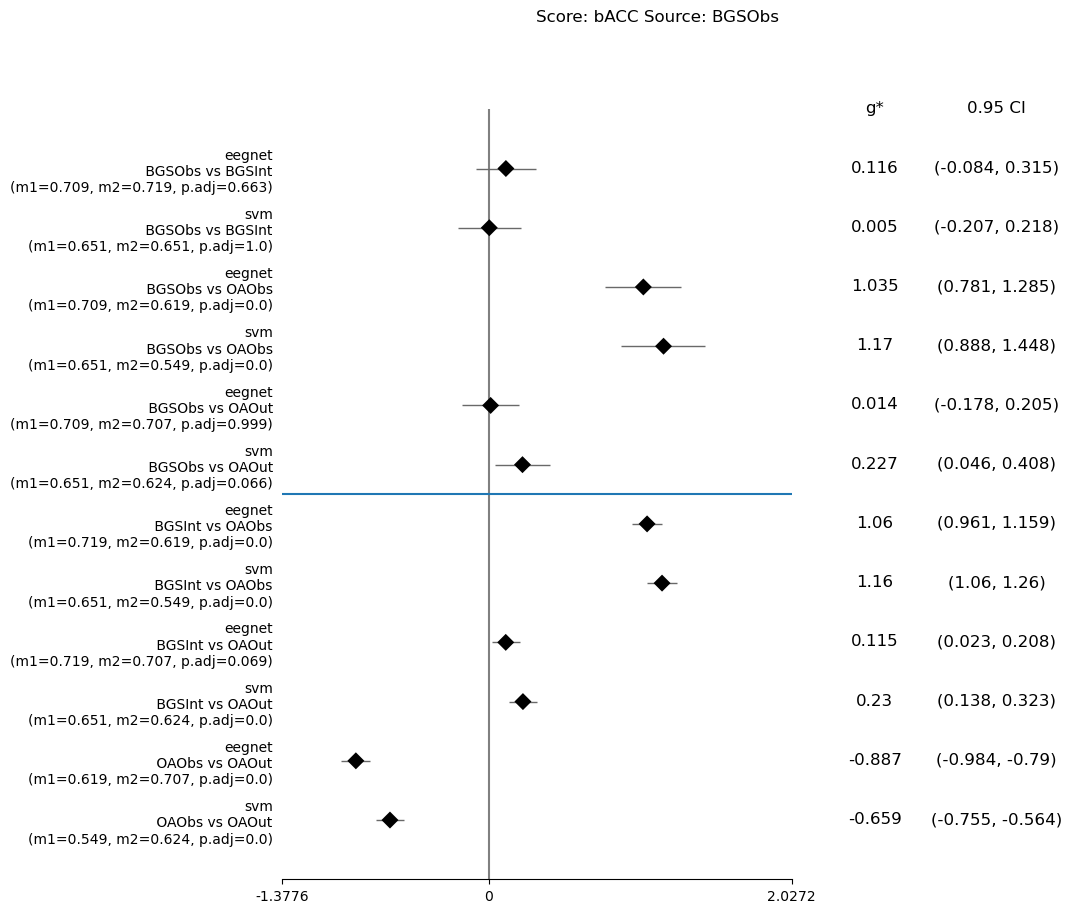

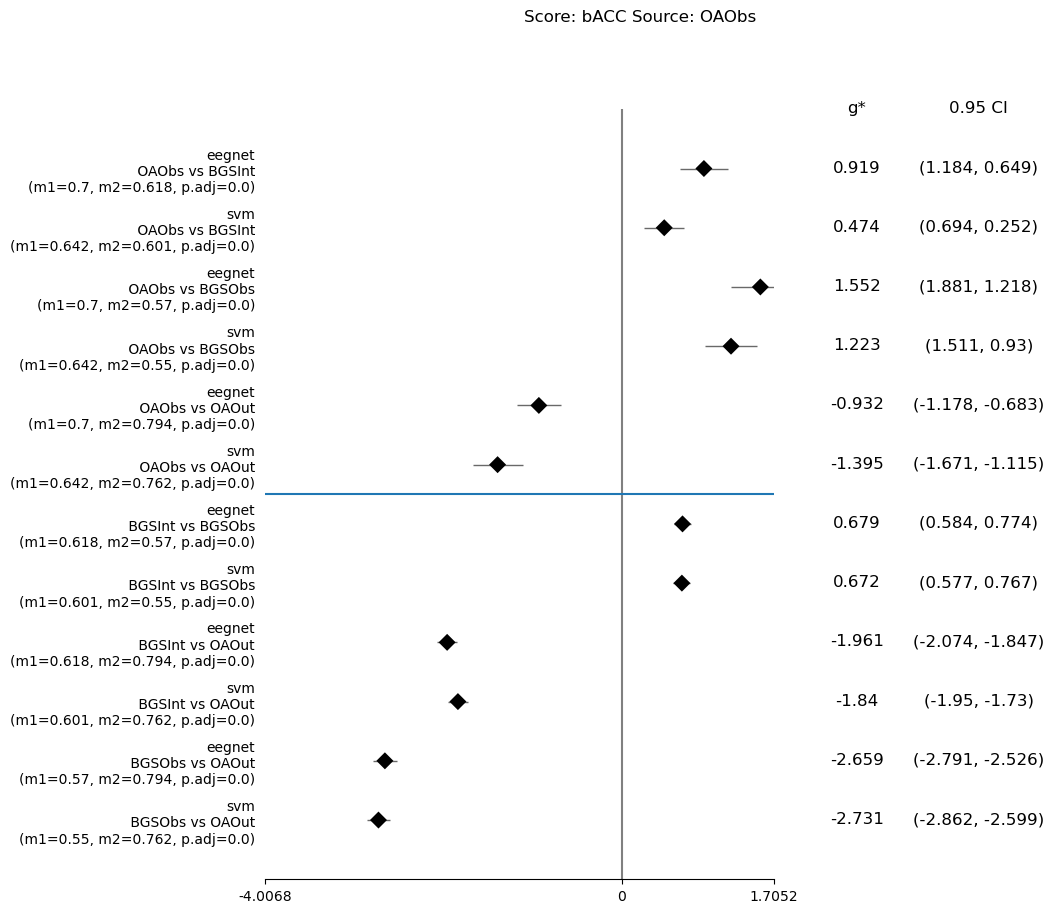

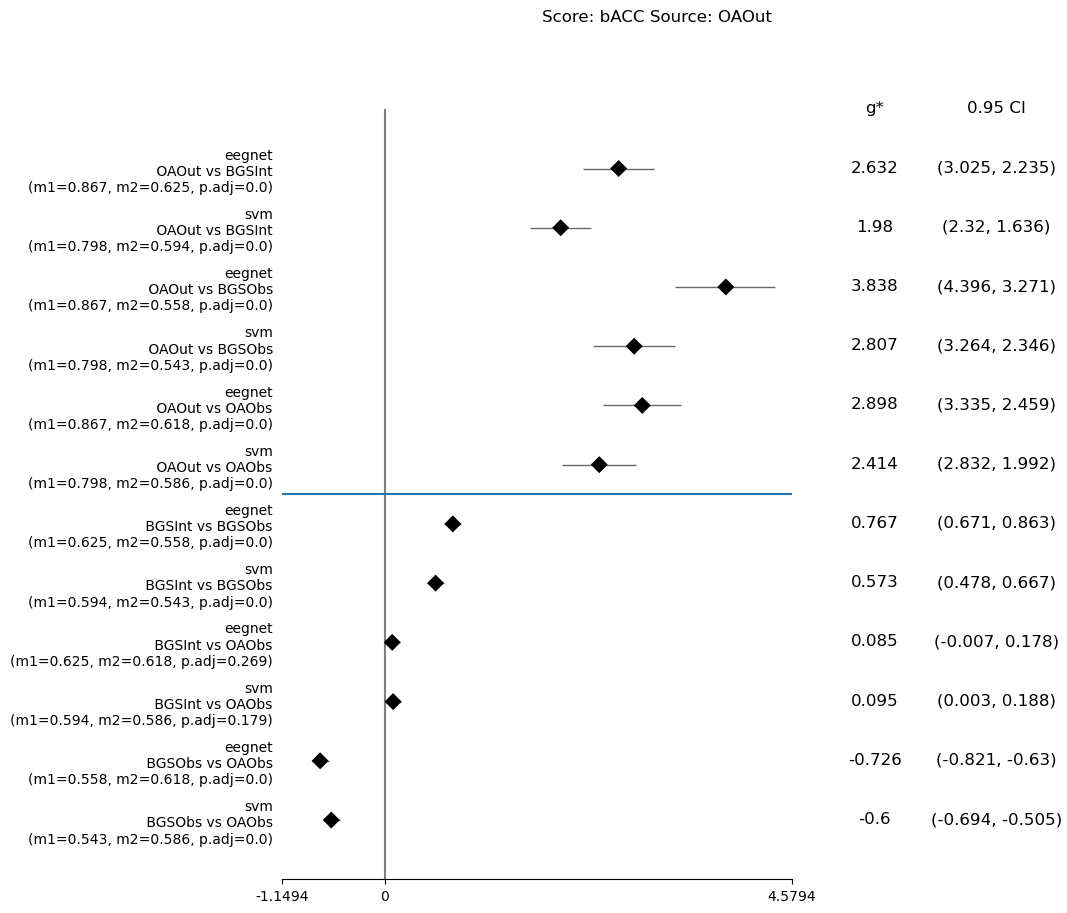

In [32]:
same_forest_plot(same_source_analysis, same_set='source', save_path=strn_plots_path, file_ext='pdf');

#### Bar Plots

['BGSInt-BGSInt' 'BGSInt-BGSObs' 'BGSInt-OAObs' 'BGSInt-OAOut']


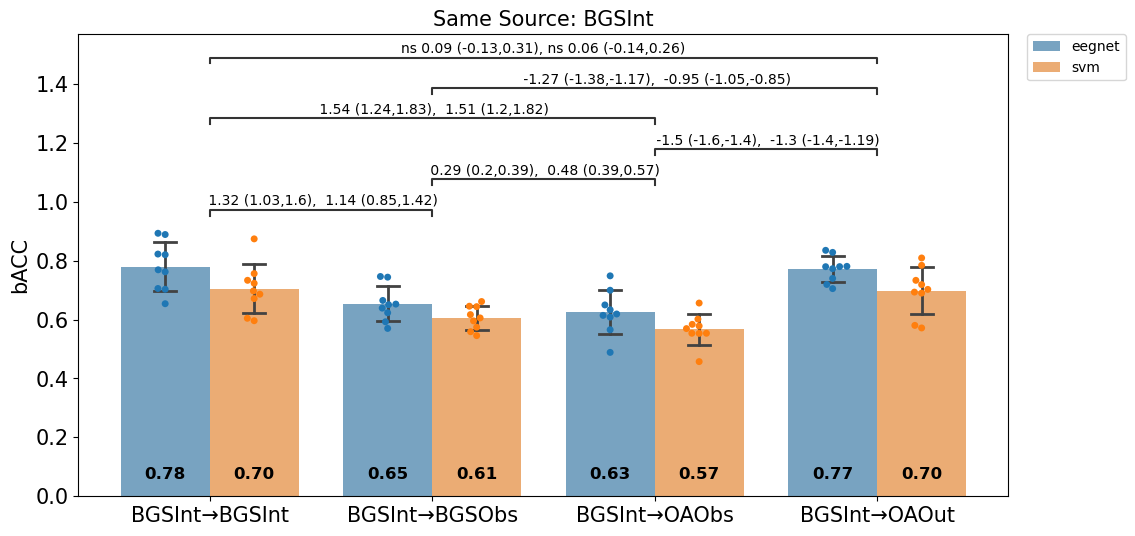

['BGSObs-BGSObs' 'BGSObs-BGSInt' 'BGSObs-OAObs' 'BGSObs-OAOut']
('BGSObs-BGSInt', 'BGSObs-BGSObs') [1] [0]


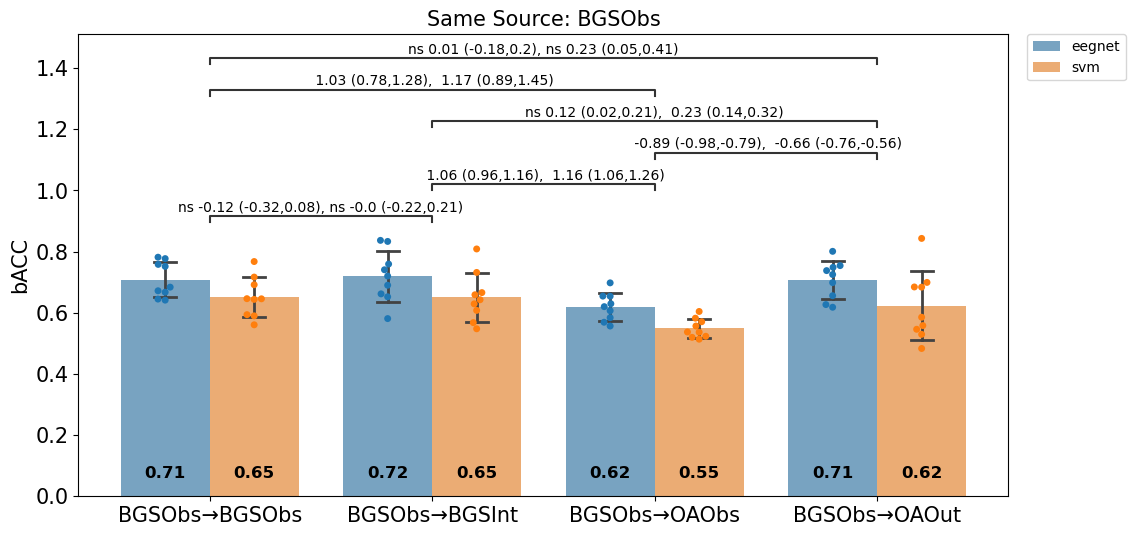

['OAOut-OAOut' 'OAOut-BGSObs' 'OAOut-OAObs' 'OAOut-BGSInt']
('OAOut-BGSInt', 'OAOut-BGSObs') [3] [1]
('OAOut-BGSInt', 'OAOut-OAObs') [3] [2]
('OAOut-BGSInt', 'OAOut-OAOut') [3] [0]
('OAOut-BGSObs', 'OAOut-OAOut') [1] [0]
('OAOut-OAObs', 'OAOut-OAOut') [2] [0]


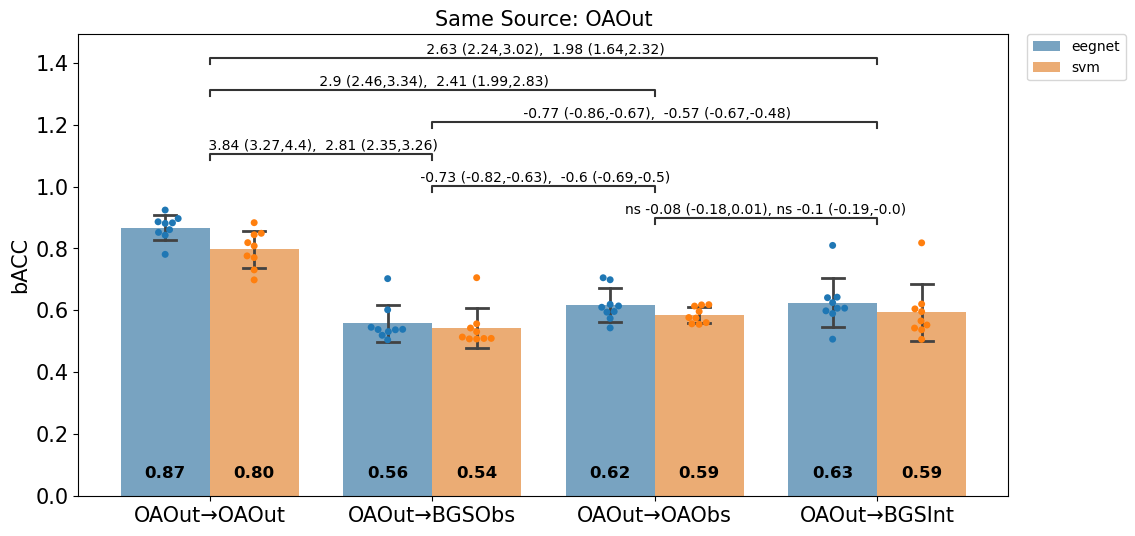

['OAObs-OAObs' 'OAObs-BGSObs' 'OAObs-BGSInt' 'OAObs-OAOut']
('OAObs-BGSInt', 'OAObs-BGSObs') [2] [1]
('OAObs-BGSInt', 'OAObs-OAObs') [2] [0]
('OAObs-BGSObs', 'OAObs-OAObs') [1] [0]


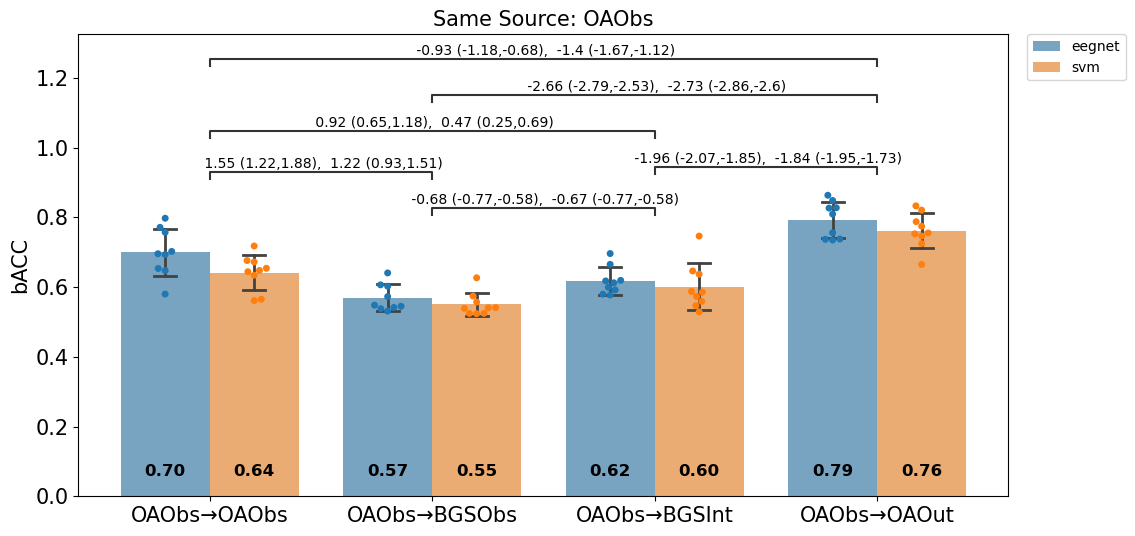

['BGSInt-BGSInt' 'BGSInt-BGSObs' 'BGSInt-OAObs' 'BGSInt-OAOut']


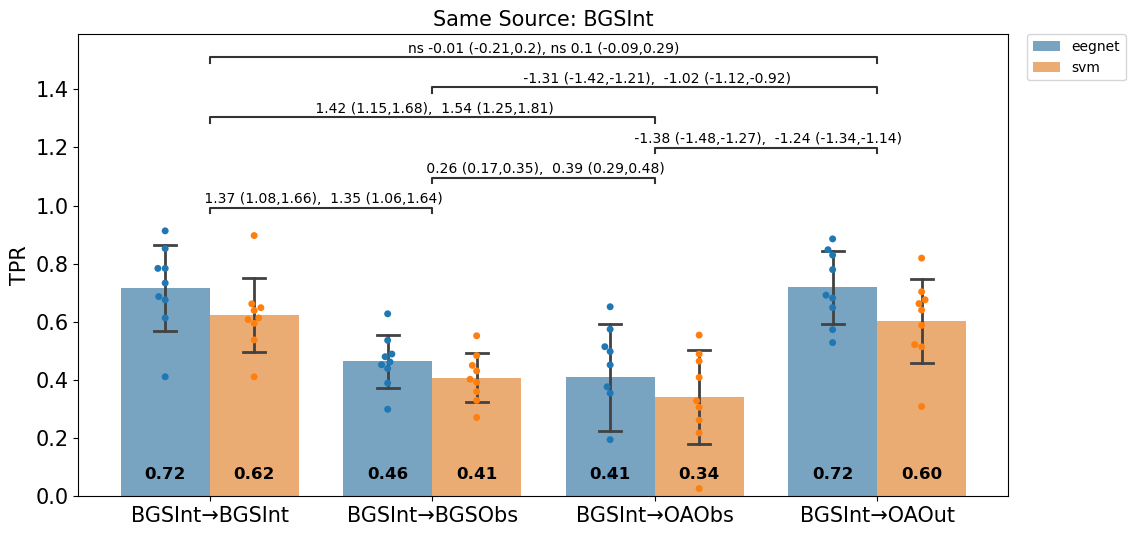

['BGSObs-BGSObs' 'BGSObs-BGSInt' 'BGSObs-OAObs' 'BGSObs-OAOut']
('BGSObs-BGSInt', 'BGSObs-BGSObs') [1] [0]


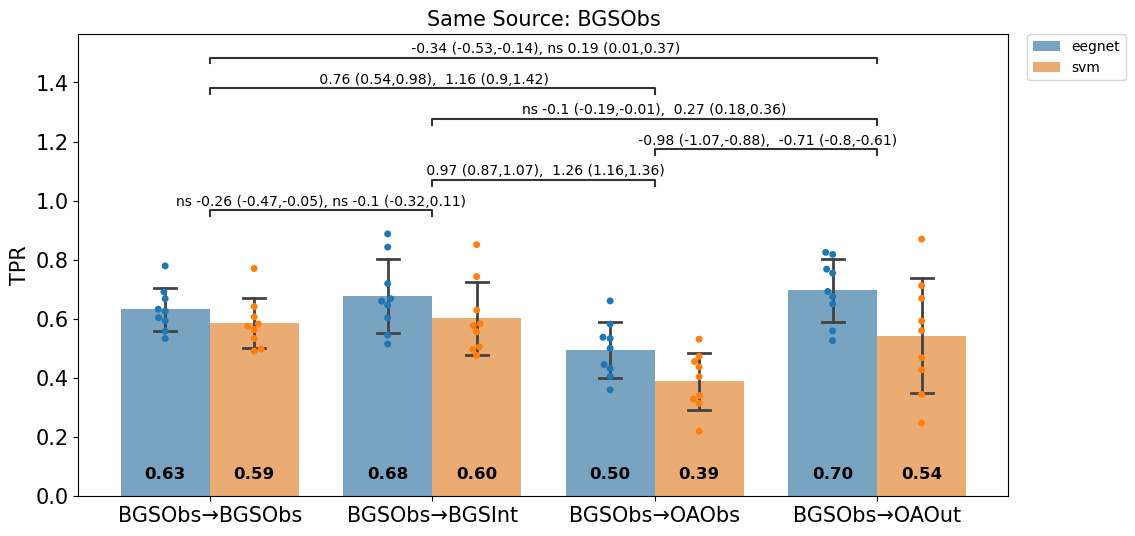

['OAOut-OAOut' 'OAOut-BGSObs' 'OAOut-OAObs' 'OAOut-BGSInt']
('OAOut-BGSInt', 'OAOut-BGSObs') [3] [1]
('OAOut-BGSInt', 'OAOut-OAObs') [3] [2]
('OAOut-BGSInt', 'OAOut-OAOut') [3] [0]
('OAOut-BGSObs', 'OAOut-OAOut') [1] [0]
('OAOut-OAObs', 'OAOut-OAOut') [2] [0]


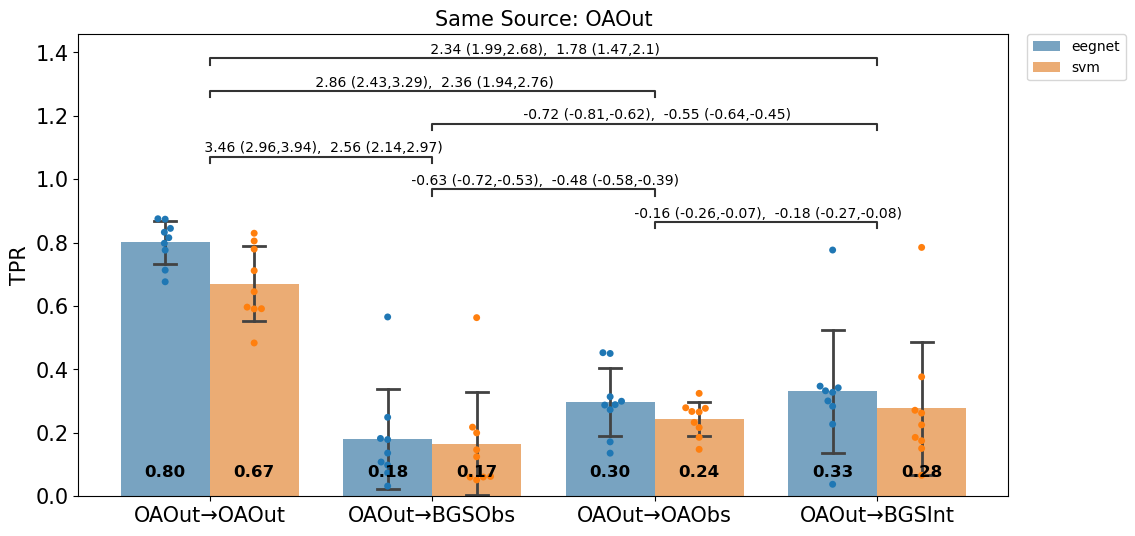

['OAObs-OAObs' 'OAObs-BGSObs' 'OAObs-BGSInt' 'OAObs-OAOut']
('OAObs-BGSInt', 'OAObs-BGSObs') [2] [1]
('OAObs-BGSInt', 'OAObs-OAObs') [2] [0]
('OAObs-BGSObs', 'OAObs-OAObs') [1] [0]


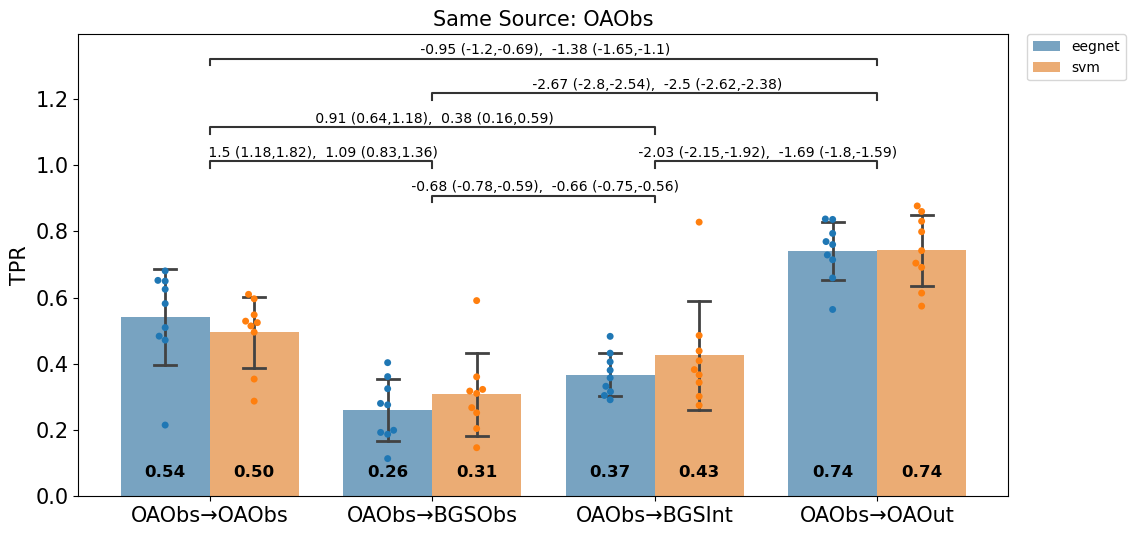

['BGSInt-BGSInt' 'BGSInt-BGSObs' 'BGSInt-OAObs' 'BGSInt-OAOut']


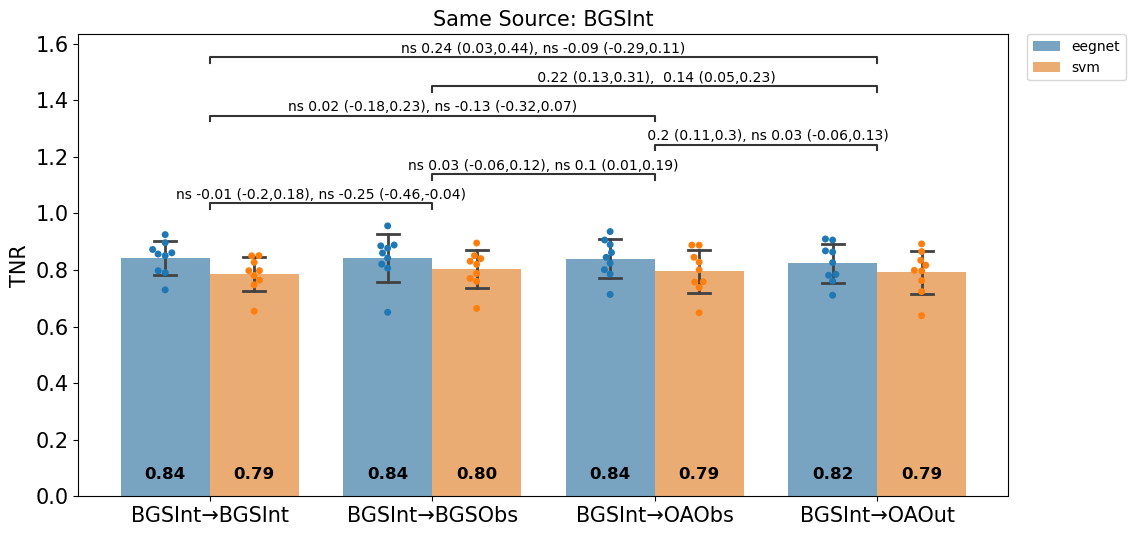

['BGSObs-BGSObs' 'BGSObs-BGSInt' 'BGSObs-OAObs' 'BGSObs-OAOut']
('BGSObs-BGSInt', 'BGSObs-BGSObs') [1] [0]


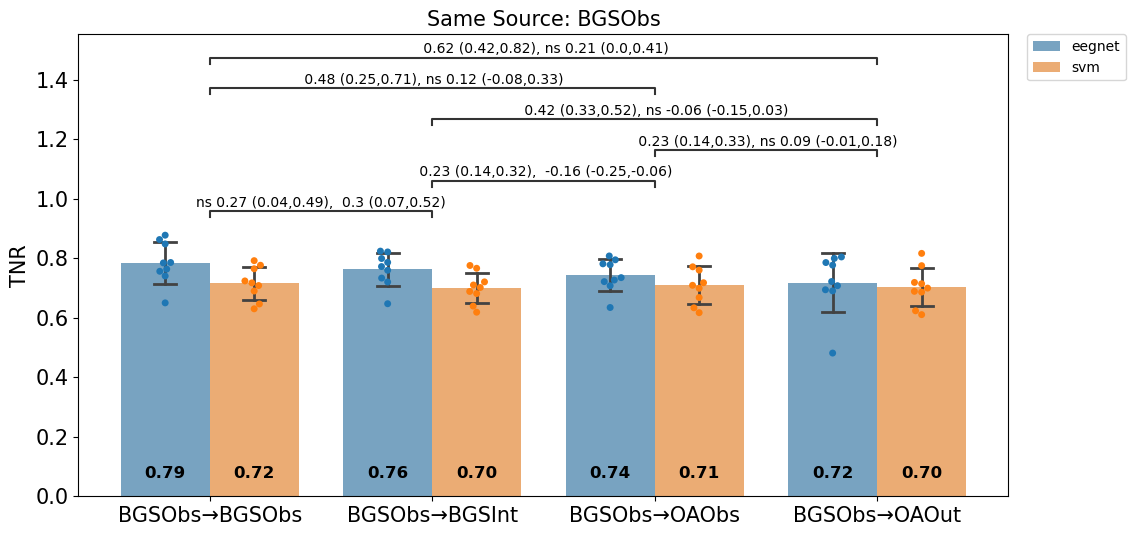

['OAOut-OAOut' 'OAOut-BGSObs' 'OAOut-OAObs' 'OAOut-BGSInt']
('OAOut-BGSInt', 'OAOut-BGSObs') [3] [1]
('OAOut-BGSInt', 'OAOut-OAObs') [3] [2]
('OAOut-BGSInt', 'OAOut-OAOut') [3] [0]
('OAOut-BGSObs', 'OAOut-OAOut') [1] [0]
('OAOut-OAObs', 'OAOut-OAOut') [2] [0]


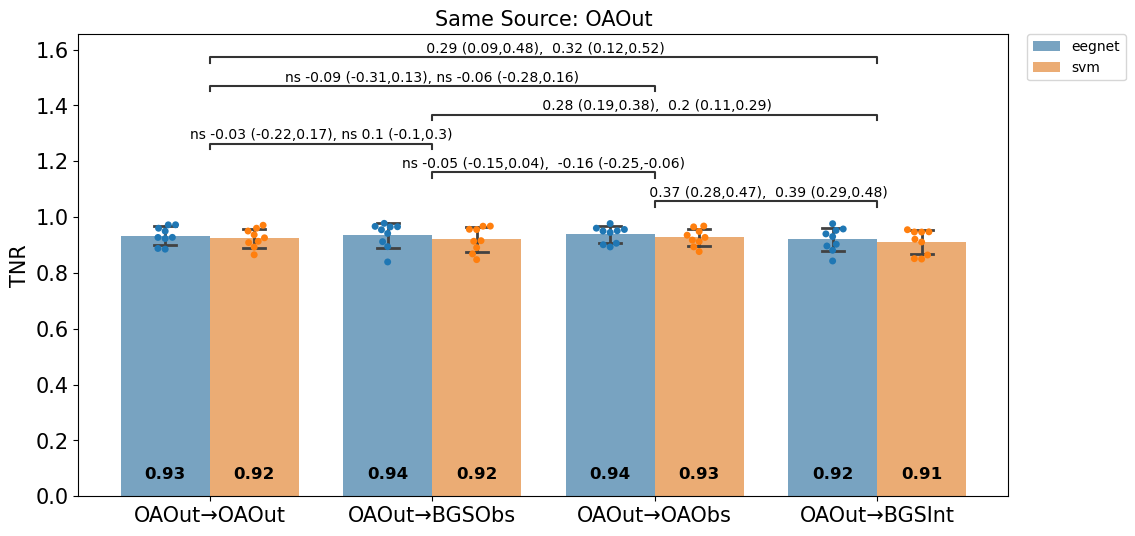

['OAObs-OAObs' 'OAObs-BGSObs' 'OAObs-BGSInt' 'OAObs-OAOut']
('OAObs-BGSInt', 'OAObs-BGSObs') [2] [1]
('OAObs-BGSInt', 'OAObs-OAObs') [2] [0]
('OAObs-BGSObs', 'OAObs-OAObs') [1] [0]


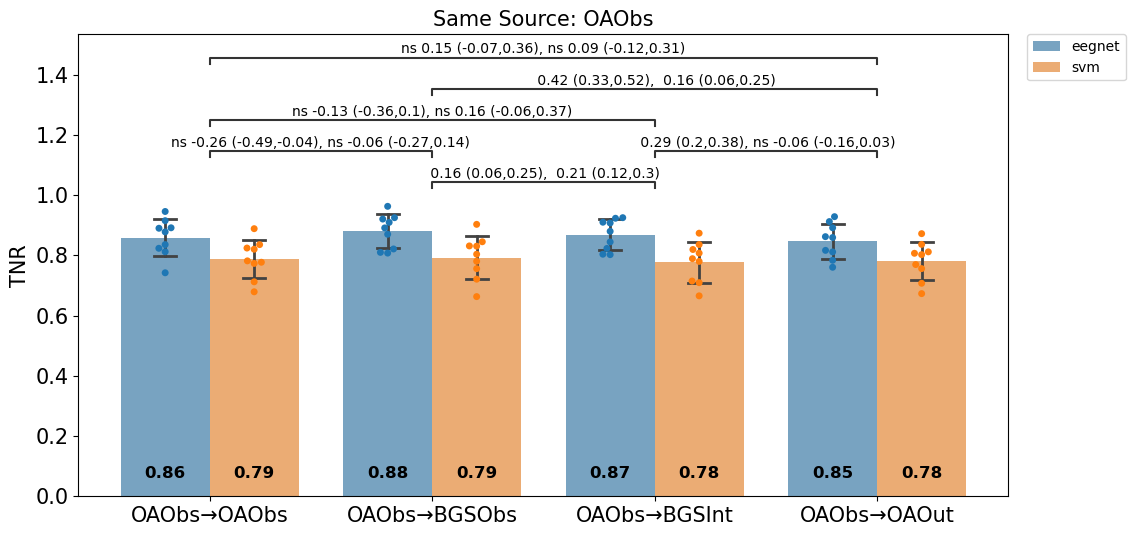

['BGSInt-BGSInt' 'BGSInt-BGSObs' 'BGSInt-OAObs' 'BGSInt-OAOut']


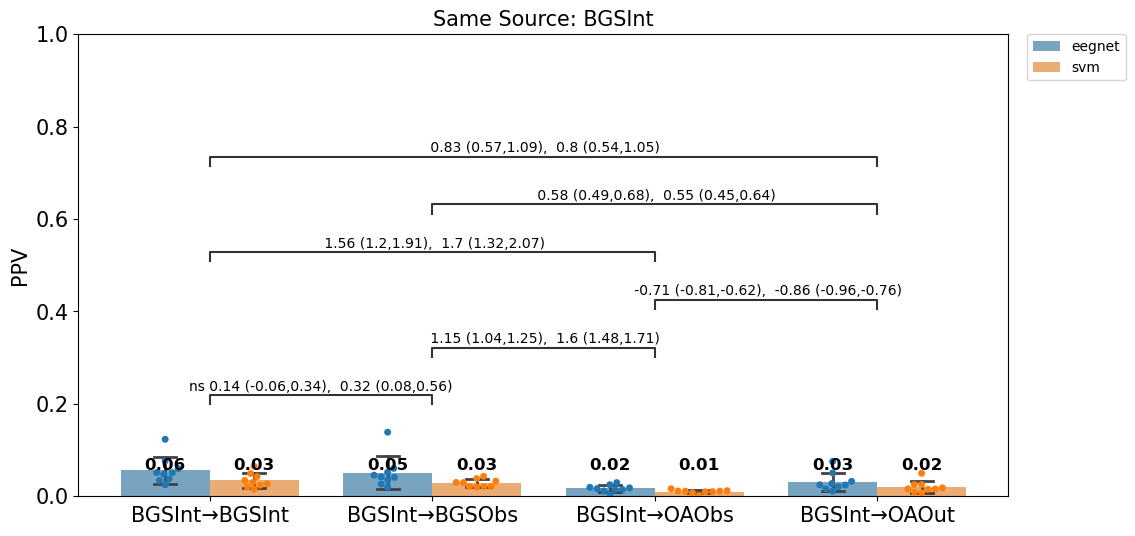

['BGSObs-BGSObs' 'BGSObs-BGSInt' 'BGSObs-OAObs' 'BGSObs-OAOut']
('BGSObs-BGSInt', 'BGSObs-BGSObs') [1] [0]


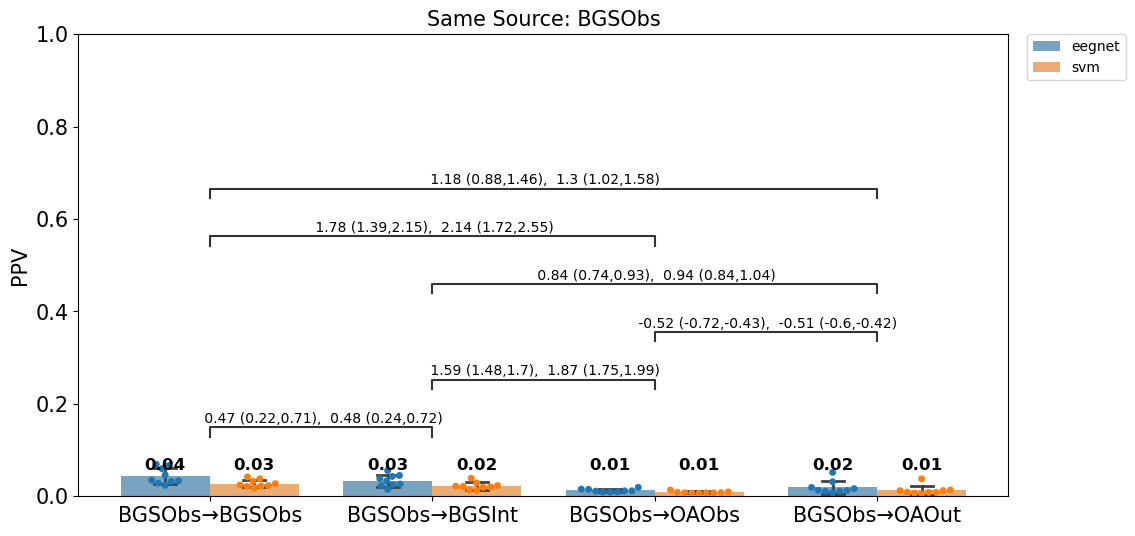

['OAOut-OAOut' 'OAOut-BGSObs' 'OAOut-OAObs' 'OAOut-BGSInt']
('OAOut-BGSInt', 'OAOut-BGSObs') [3] [1]
('OAOut-BGSInt', 'OAOut-OAObs') [3] [2]
('OAOut-BGSInt', 'OAOut-OAOut') [3] [0]
('OAOut-BGSObs', 'OAOut-OAOut') [1] [0]
('OAOut-OAObs', 'OAOut-OAOut') [2] [0]


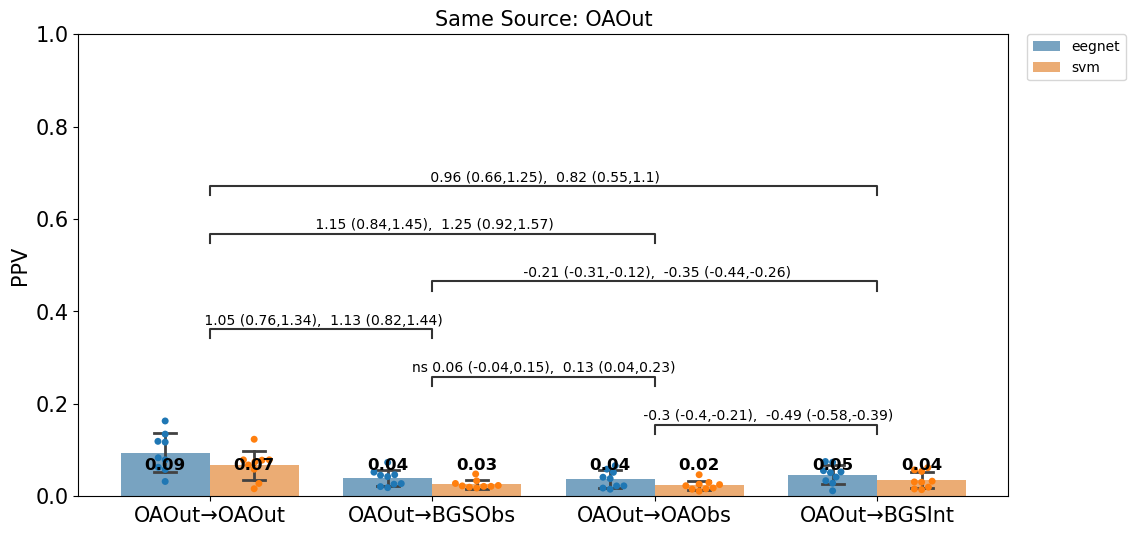

['OAObs-OAObs' 'OAObs-BGSObs' 'OAObs-BGSInt' 'OAObs-OAOut']
('OAObs-BGSInt', 'OAObs-BGSObs') [2] [1]
('OAObs-BGSInt', 'OAObs-OAObs') [2] [0]
('OAObs-BGSObs', 'OAObs-OAObs') [1] [0]


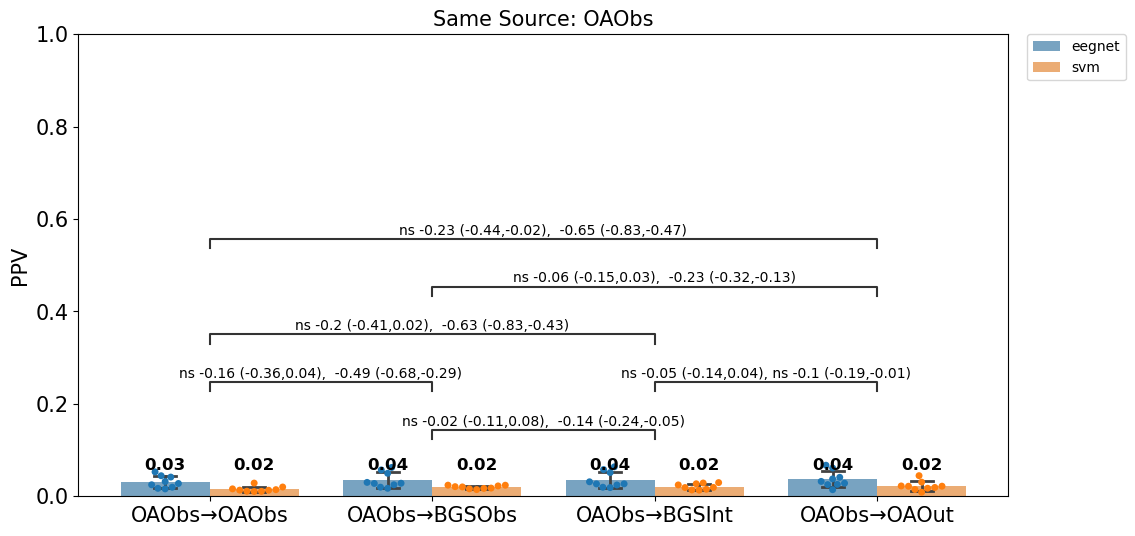

In [33]:
same_set = 'source'

bp_kwargs = get_bar_plot_kwargs()
# Defaults
bp_kwargs['loc_func'] = get_same_set_locs(same_set=same_set)
bp_kwargs['task_plot_vars'] = dict(
    plot1='BGSInt', 
    plot2='BGSObs', 
    plot3='OAOut',
    plot4='OAObs'
)
bp_kwargs['order_func'] = source_task_first
bp_kwargs['filename_func'] = same_source_test_filename
bp_kwargs['save_path'] = strn_plots_path

if not render_paper_plots:
    # Default kwargs when rending detailed plots (annotation plots)
    bp_kwargs['add_annotations_func'] = partial(
        add_annotations, 
        pdf=same_source_analysis,
        rep=None,
        show_effect_size_value=True,
        show_effect_size_ci=True,
    )
    bp_kwargs['legend'] = True
    bp_kwargs['title_func'] = partial(same_source_test_title, same_set=same_set)
else:
    # Default kwargs when rending plots for paper (minimal plots)
    bp_kwargs['add_annotations_func'] = partial(
        add_annotations, 
        pdf=same_source_analysis,
        show_effect_size=False,
    )
    
mean_bar_plot(**bp_kwargs)

#### Save Results

In [34]:
save_results(strn_path, same_source_analysis)

### Within Task

#### Forest Plots

In [35]:
def within_task_forest_plot(df, save_path=None, file_ext='jpg'):
    df = df.copy()
    groups = df.groupby(['score'])
    
    for name, gdf in groups:
        gdf = gdf.reset_index(drop=False)
        gdf = gdf.sort_values(['group1', 'group2',])

        labels = make_labels(
            df=gdf,
            tmplt="{}\n {} vs {}\n(m1={}, m2={}, p={})",
            use_columns=['exps', 'group1', 'group2', 'mean1', 'mean2', 'p']
        )
        
        p, ax = forest_plot(
            labels=labels,
            measure=gdf['Hedges_g'].values,
            lcl=gdf['CI_low'].values,
            ucl=gdf['CI_high'].values,
            subtitle=f"Score: {name} {same_set.capitalize()}",
            ci=.95,
            measure_label='g*',
            table_adjust=0.04,
            figsize=(10,10)
        )
        ax.axhline(5.5, 0, 1)
        
        if save_path is not None:
            filename = f"FOREST_{name}" + f'.{file_ext}'
            filepath = os.path.join(save_path, filename)
            plt.savefig(filepath, bbox_inches='tight')


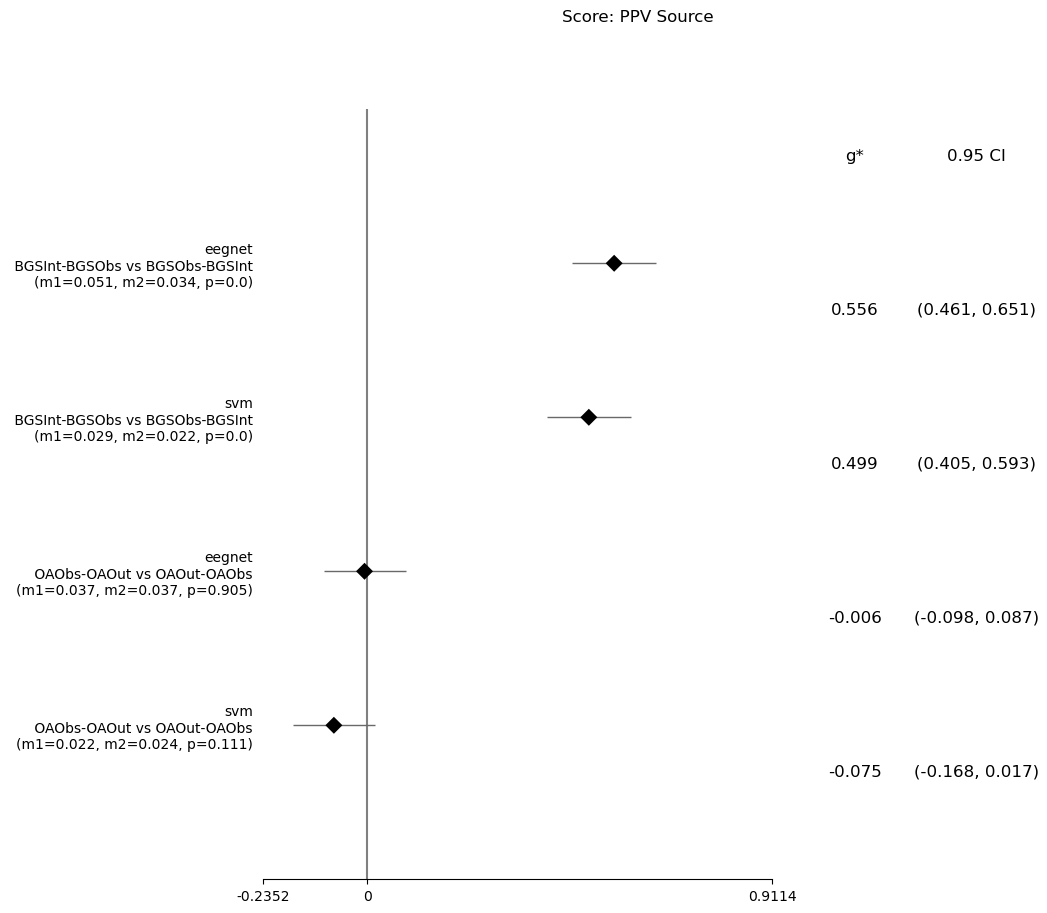

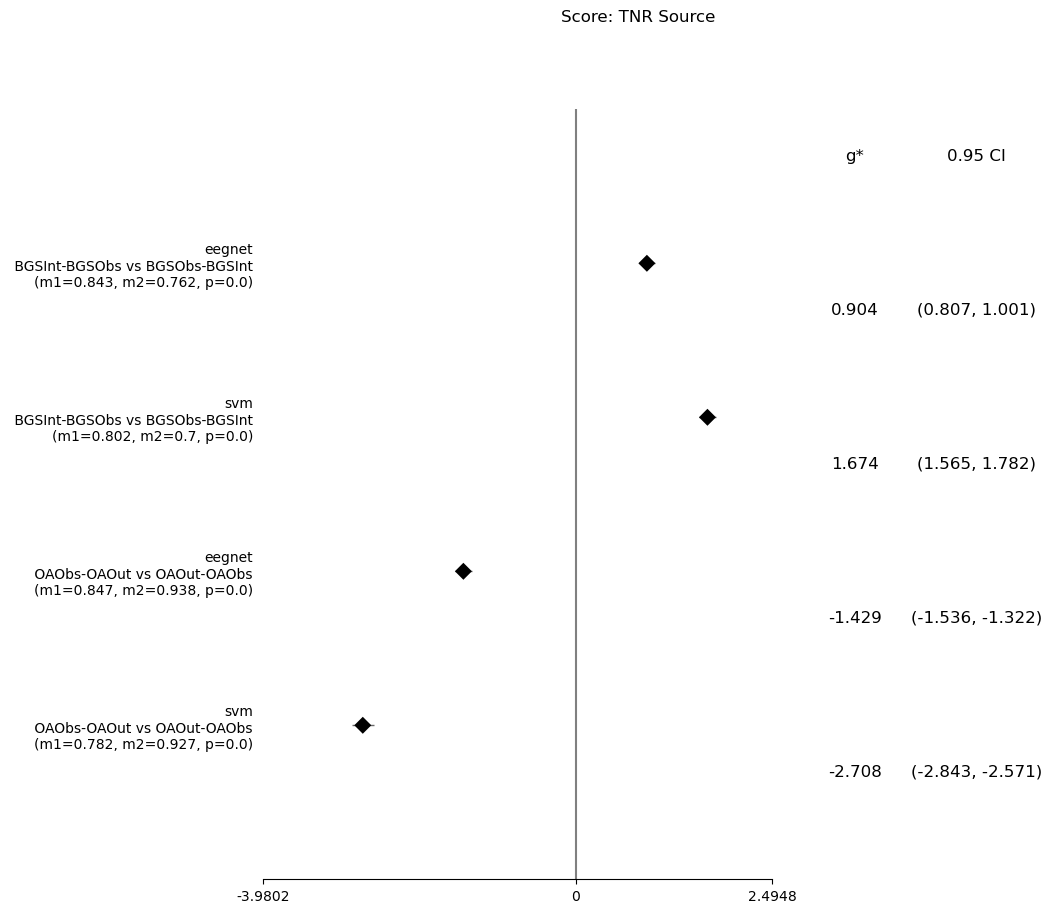

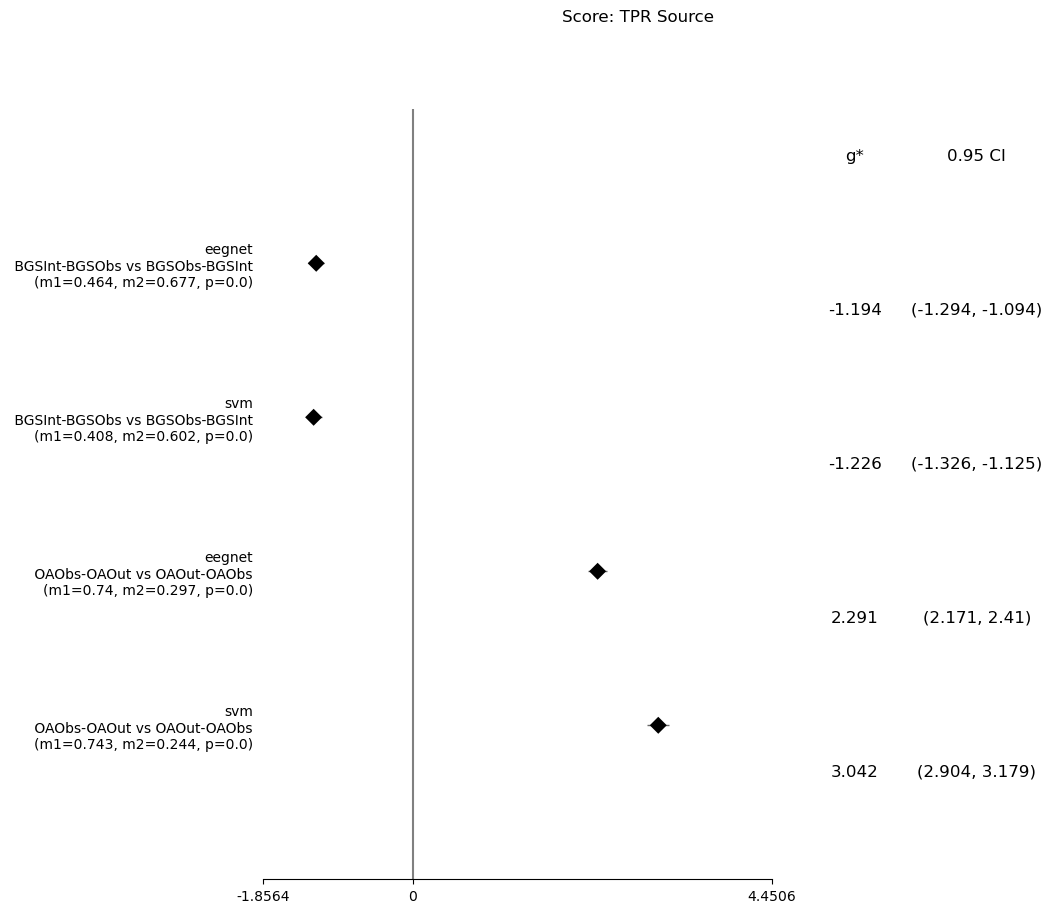

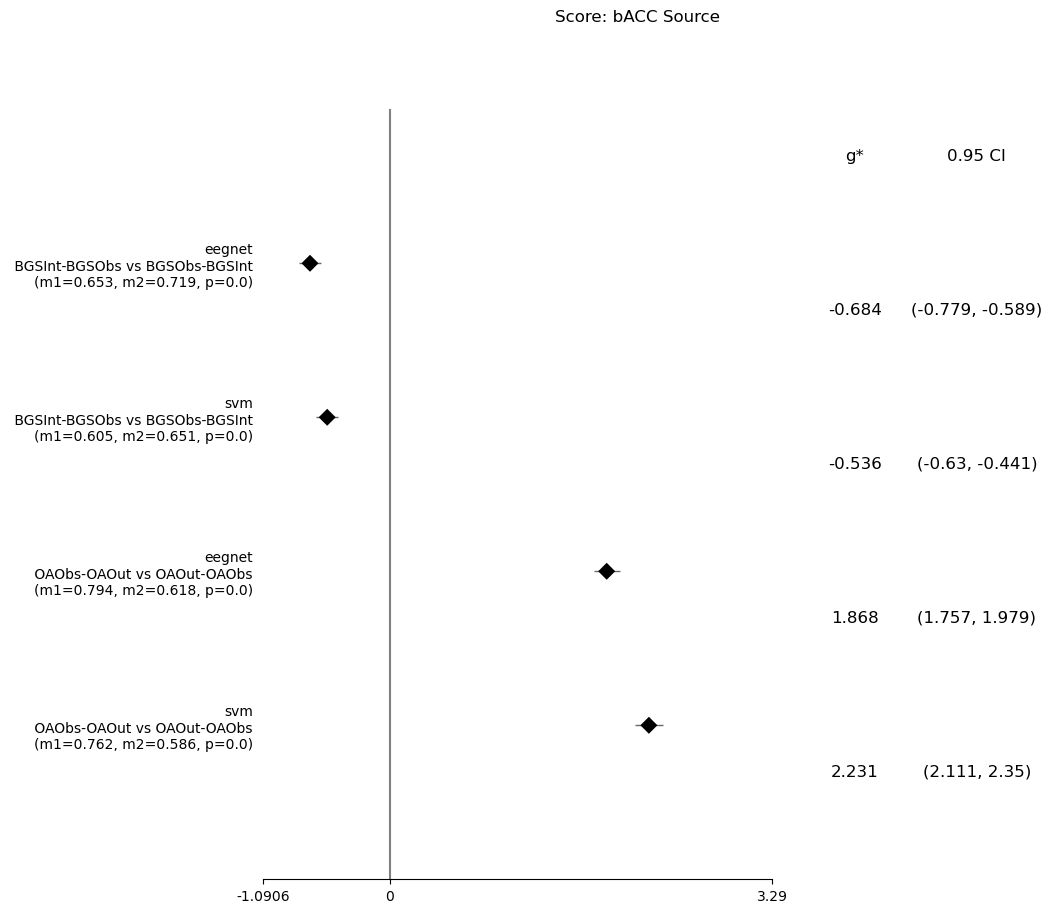

In [36]:
within_task_forest_plot(within_task_analysis, save_path=stask_plots_path, file_ext='pdf');

#### Bar Plots

['BGSInt-BGSObs' 'BGSObs-BGSInt' 'OAObs-OAOut' 'OAOut-OAObs']


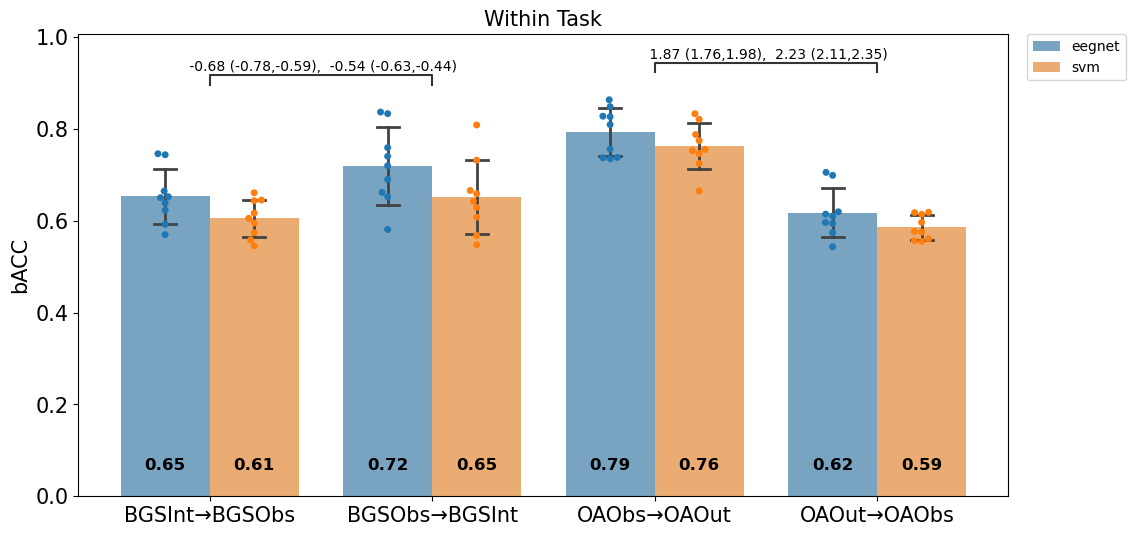

['BGSInt-BGSObs' 'BGSObs-BGSInt' 'OAObs-OAOut' 'OAOut-OAObs']


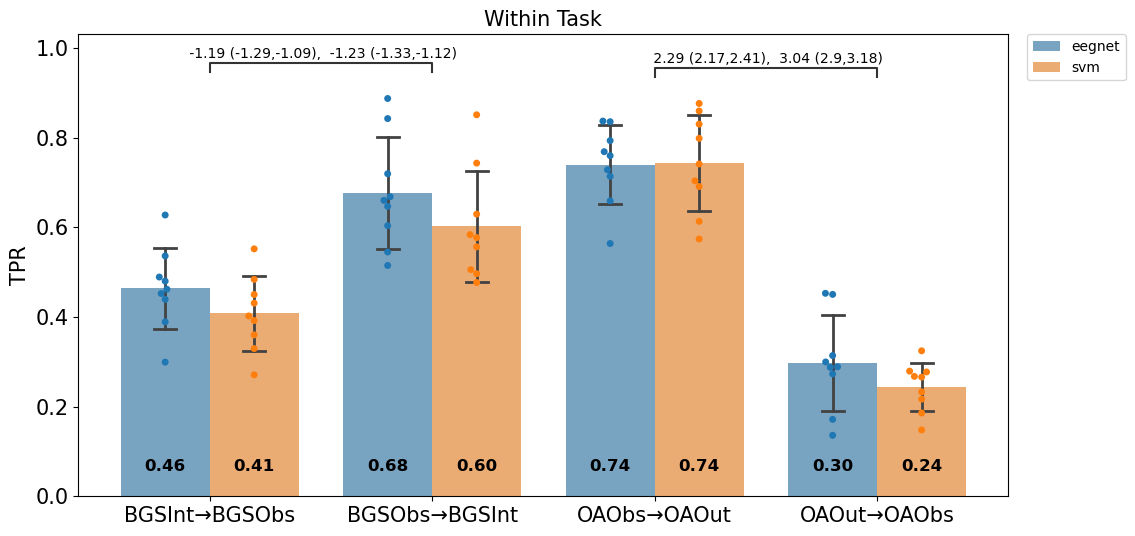

['BGSInt-BGSObs' 'BGSObs-BGSInt' 'OAObs-OAOut' 'OAOut-OAObs']


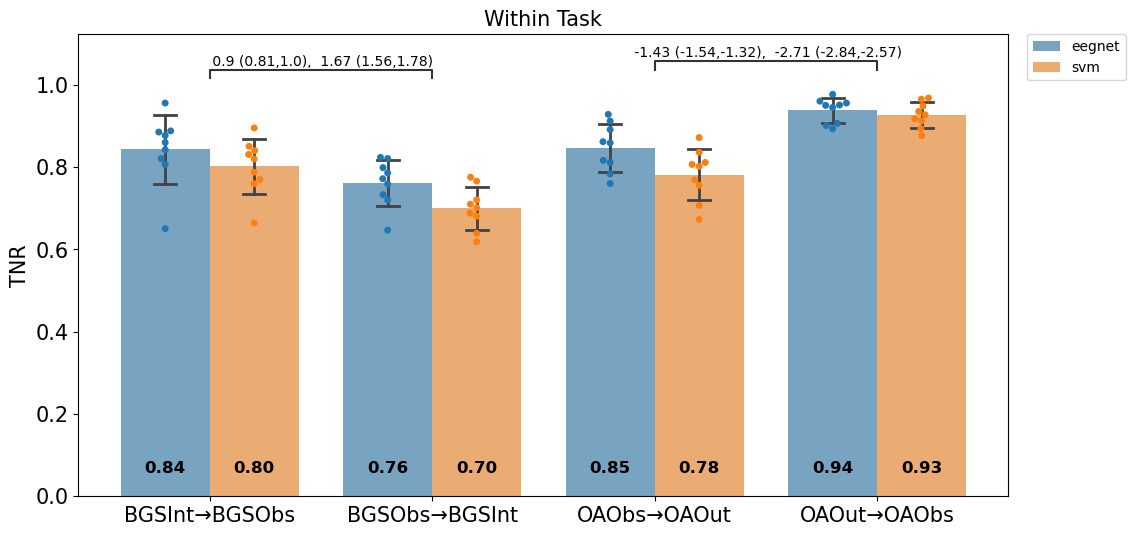

['BGSInt-BGSObs' 'BGSObs-BGSInt' 'OAObs-OAOut' 'OAOut-OAObs']


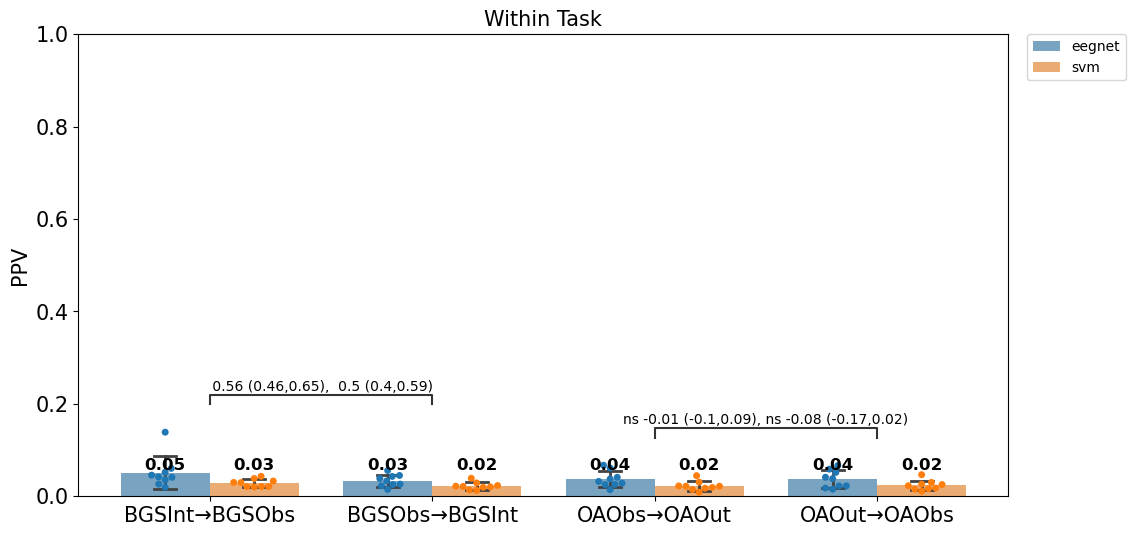

In [37]:
def get_within_task_set_locs(df, **kwargs):
    task = kwargs['task']
    if len(task) % 2:
        raise ValueError("'task' must contain 2 or more tasks and be divisible by 2")
    condi = None
    for i in range(len(task)//2):
        j = i*2
        k = i*2+1
        condi1 = (df['tst_dataset'] == task[j]) & (df['dataset'] == task[k]) 
        condi2 = (df['tst_dataset'] == task[k]) & (df['dataset'] == task[j]) 
        
        if condi is None:
            condi = condi1 | condi2
        else:
            condi = condi | condi1 | condi2
            
    return condi

def within_task_title(**kwargs):
    return "Within Task"

def within_task_filename(**kwargs):
    return f"BAR_{kwargs['dv']}"

bp_kwargs = get_bar_plot_kwargs()
# Defaults
bp_kwargs['loc_func'] = get_within_task_set_locs
bp_kwargs['task_plot_vars'] = dict(
    plot1=['BGSObs', 'BGSInt', 'OAOut', 'OAObs']
)
bp_kwargs['filename_func'] = within_task_filename
bp_kwargs['save_path'] = stask_plots_path

if not render_paper_plots:
    # Default kwargs when rending detailed plots (annotation plots)
    bp_kwargs['add_annotations_func'] = partial(
        add_annotations, 
        pdf=within_task_analysis,
        rep=None,
        show_effect_size_value=True,
        show_effect_size_ci=True,
    )
    bp_kwargs['legend'] = True
    bp_kwargs['title_func'] = within_task_title
else:
    # Default kwargs when rending plots for paper (minimal plots)
    bp_kwargs['add_annotations_func'] = partial(
        add_annotations, 
        pdf=within_task_analysis,
        show_effect_size=False,
    )
mean_bar_plot(**bp_kwargs)


#### Save Results

In [38]:
save_results(stask_path, within_task_analysis)

### Within Category

#### Forest Plots

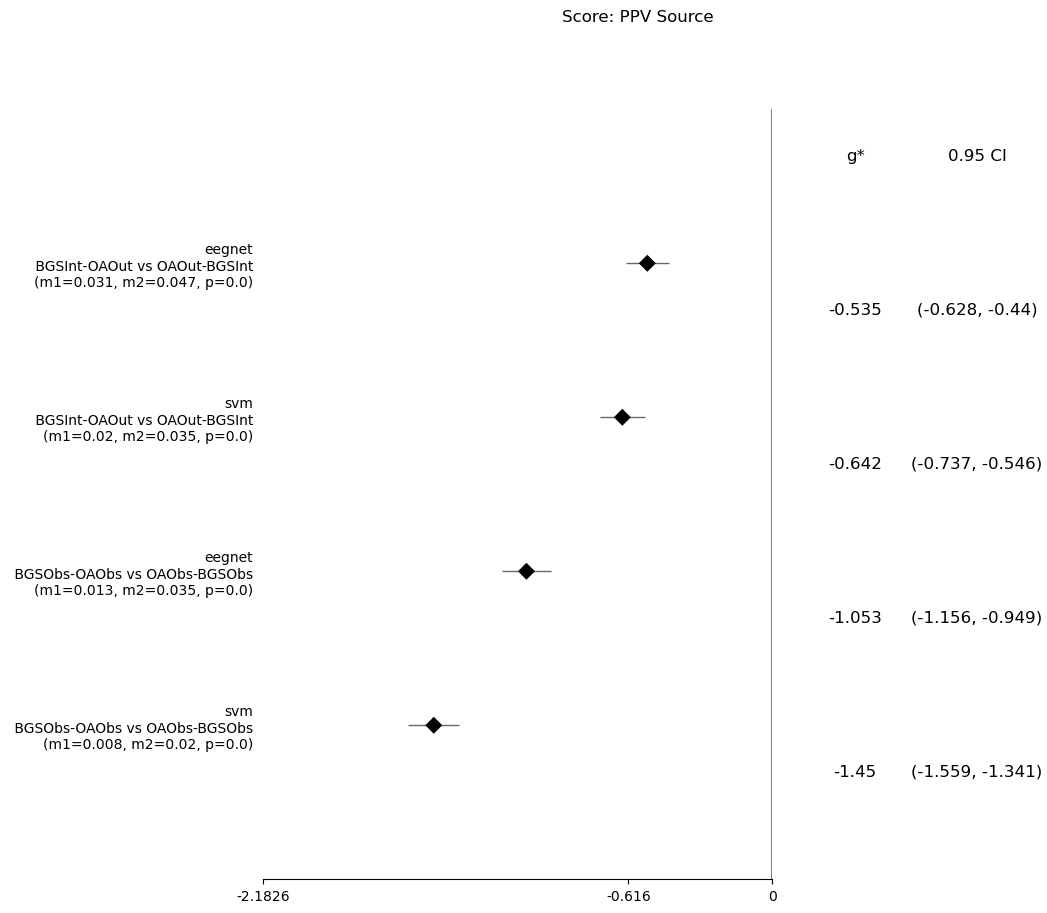

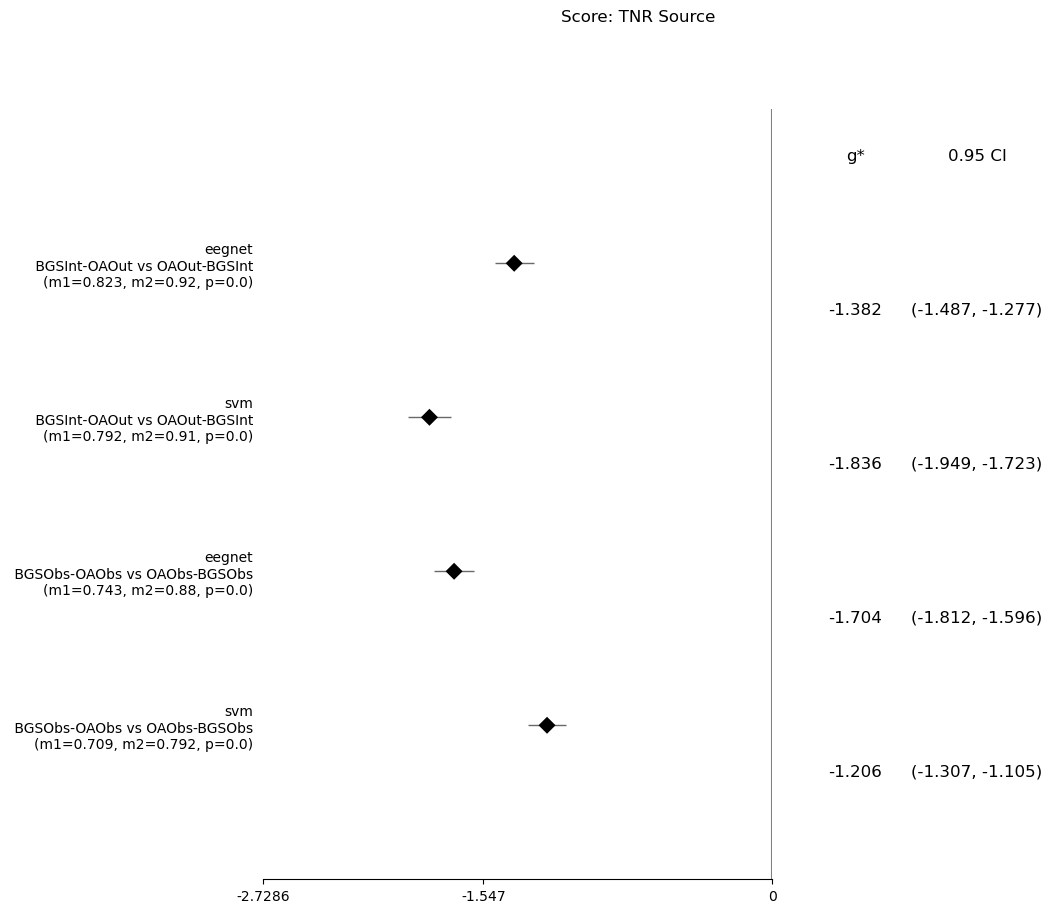

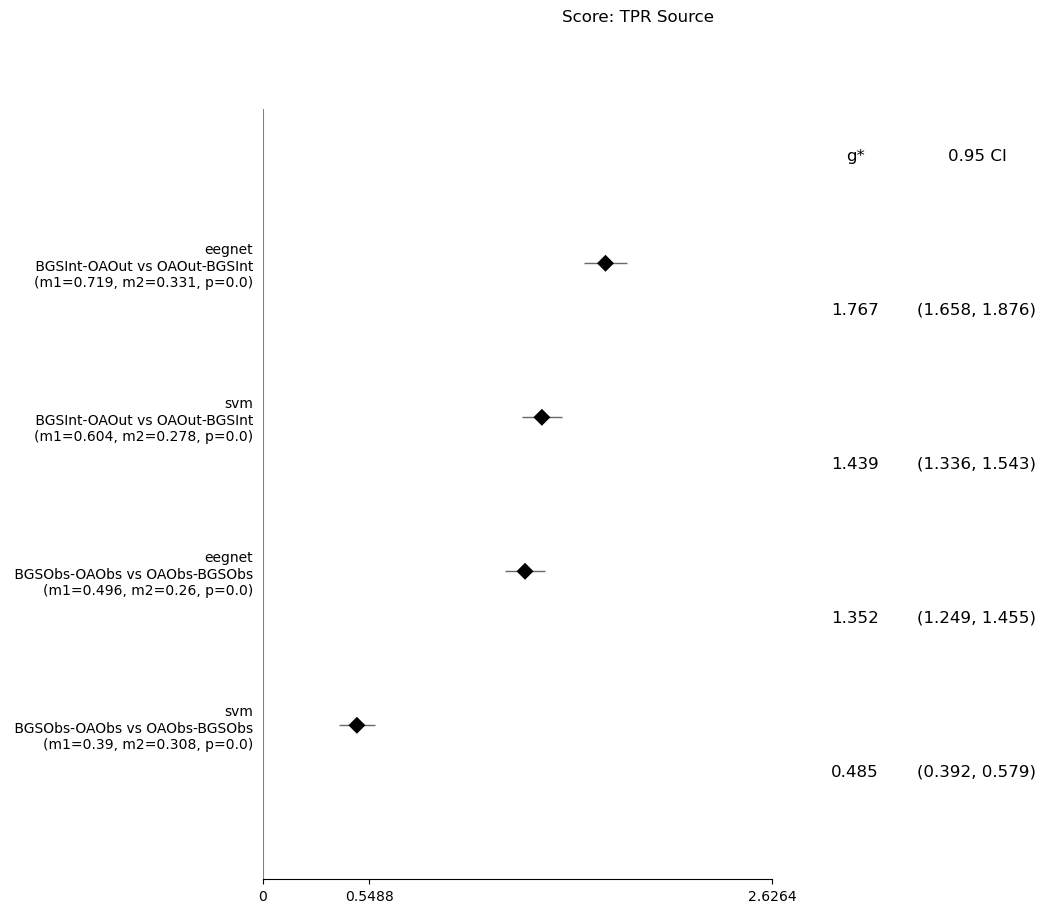

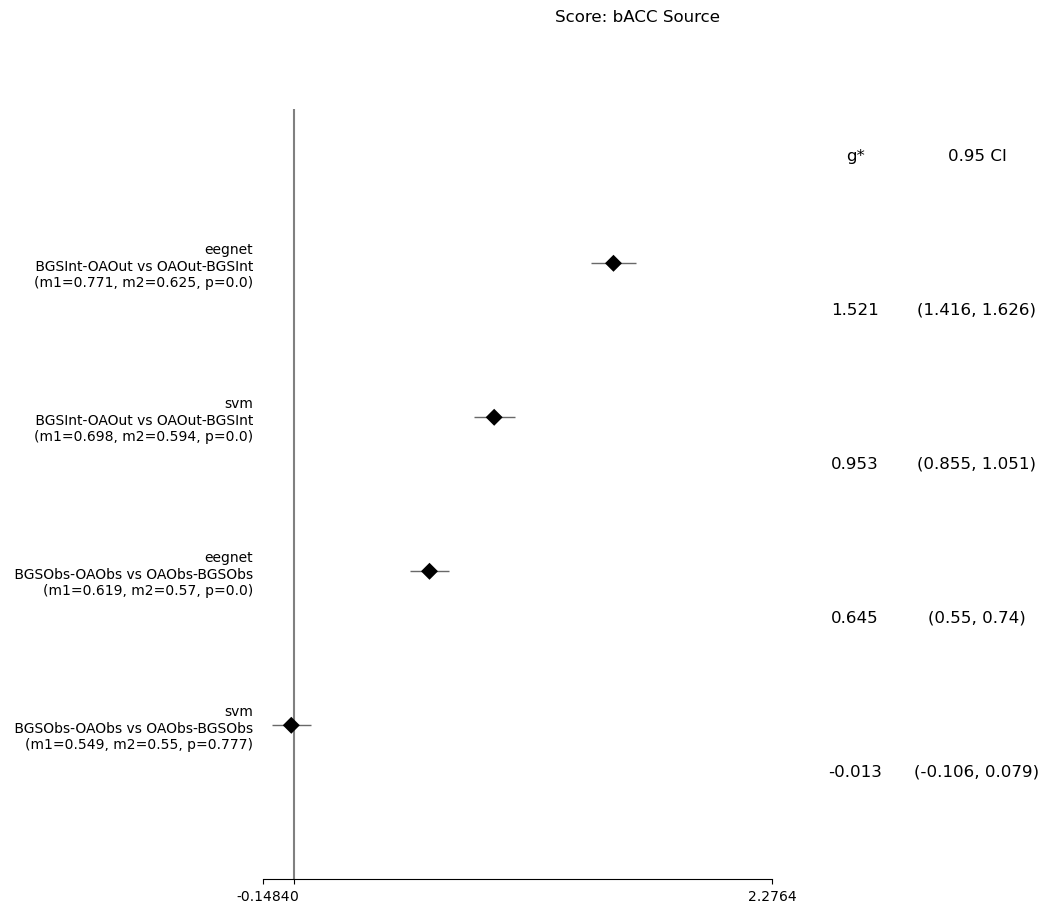

In [39]:
within_task_forest_plot(within_category_analysis, save_path=ssubtask_plots_path, file_ext='pdf');

#### Bar Plots

['BGSInt-OAOut' 'OAOut-BGSInt' 'BGSObs-OAObs' 'OAObs-BGSObs']


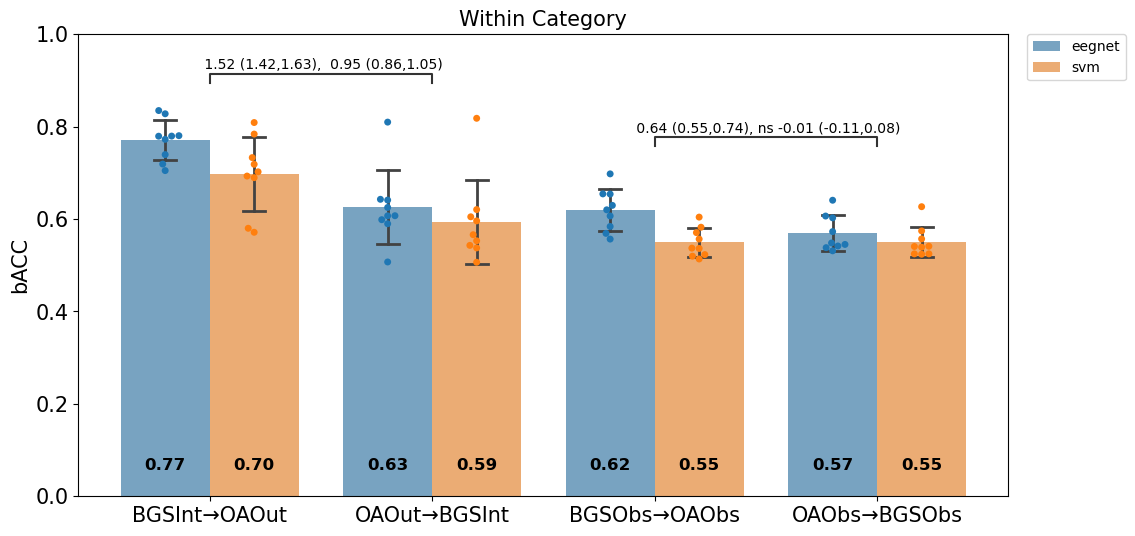

['BGSInt-OAOut' 'OAOut-BGSInt' 'BGSObs-OAObs' 'OAObs-BGSObs']


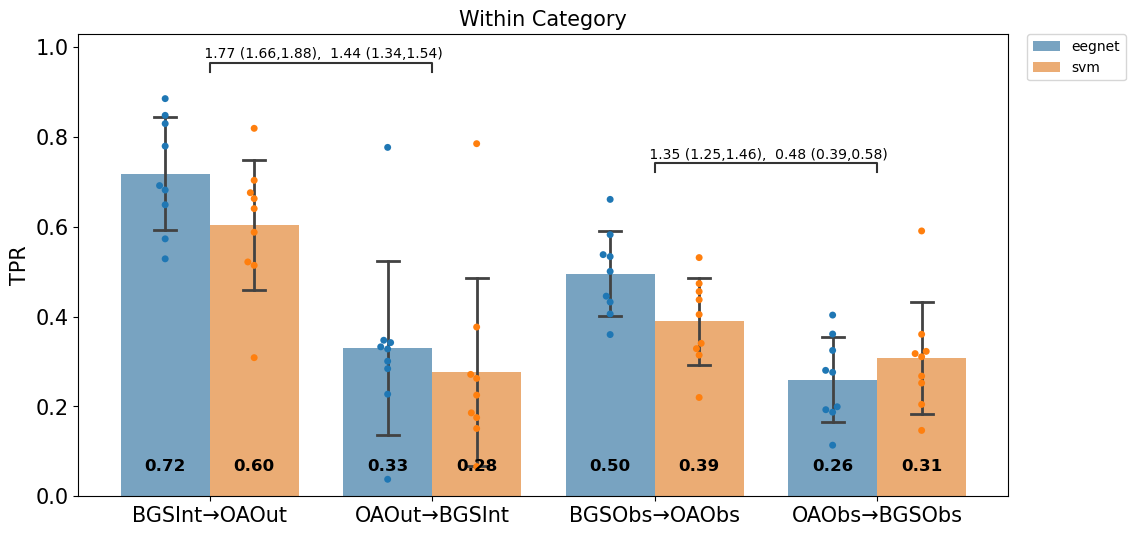

['BGSInt-OAOut' 'OAOut-BGSInt' 'BGSObs-OAObs' 'OAObs-BGSObs']


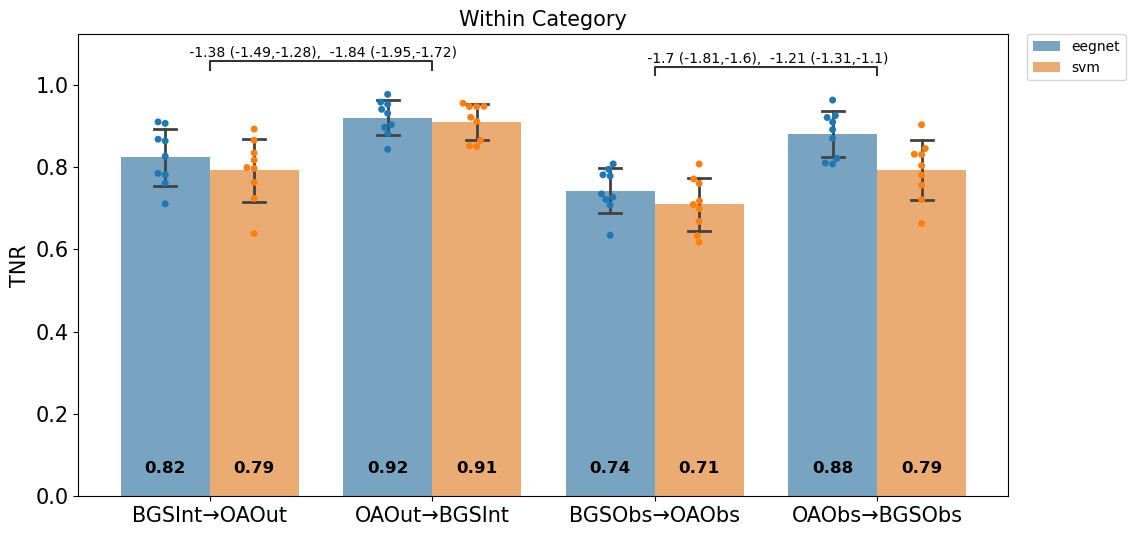

['BGSInt-OAOut' 'OAOut-BGSInt' 'BGSObs-OAObs' 'OAObs-BGSObs']


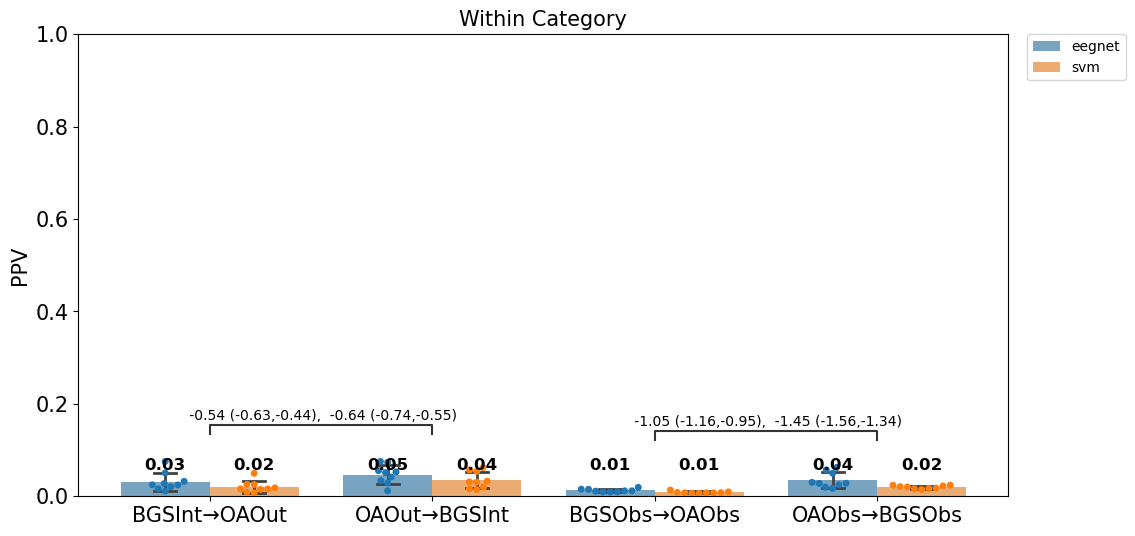

In [40]:
get_within_category_set_locs = get_within_task_set_locs

def within_category_title(**kwargs):
    return "Within Category"

def within_category_filename(**kwargs):
    return f"BAR_{kwargs['dv']}"

def group_within_category(df):
    values = df['group'].unique()
    # swap Out and BGSObs
    old = values[1]
    values[1] = values[3]
    values[3] = old
    # Swap BGSObs and OAObs
    old = values[2]
    values[2] = values[3]
    values[3] = old

    return values

bp_kwargs = get_bar_plot_kwargs()
# Defaults
bp_kwargs['loc_func'] = get_within_category_set_locs
bp_kwargs['task_plot_vars'] = dict(
    plot1=['BGSObs', 'OAObs', 'OAOut', 'BGSInt']
)
bp_kwargs['order_func'] = group_within_category
bp_kwargs['filename_func'] = within_category_filename
bp_kwargs['save_path'] = ssubtask_plots_path

if not render_paper_plots:
    # Default kwargs when rending detailed plots (annotation plots)
    bp_kwargs['add_annotations_func'] = partial(
        add_annotations, 
        pdf=within_category_analysis,
        rep=None,
        show_effect_size_value=True,
        show_effect_size_ci=True,
    )
    bp_kwargs['legend'] = True
    bp_kwargs['title_func'] = within_category_title
else:
    # Default kwargs when rending plots for paper (minimal plots)
    bp_kwargs['add_annotations_func'] = partial(
        add_annotations, 
        pdf=within_category_analysis,
        show_effect_size=False,
    )
mean_bar_plot(**bp_kwargs)

#### Save Results

In [41]:
save_results(ssubtask_path, within_category_analysis)